In [ ]:
# # Chapitre empirique – Notebook maître HMDA + ACS (Tri-State, 2007–2023)
#
# Ce notebook produit **tous les tableaux et graphiques** mentionnés dans le chapitre :
# - Comparaison des cohortes pré-IA (2007–2017) vs IA (2018–2023)
# - Modèles logit "miroirs"
# - Analyses ACS (hmda_acs_tristate_2018_2023_FINAL)
# - Modèles ML (RF / XGBoost) et premières métriques de fairness
#
# 🔗 Référence thèse :
# > Chapitre empirique : "AI-Driven Fair Creditworthiness and Credit Scoring:
# > A Two-Decade Analysis in the Tri-State Area (2007–2024)"


In [4]:
# 0. Imports et configuration globale

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost est optionnel : installe-le si besoin via `pip install xgboost`
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

plt.style.use("default")

# Pour que les DataFrames s'affichent proprement
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Chemin de travail (adapter si nécessaire)
BASE_DIR = r"C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work"

CORE_PATH  = os.path.join(BASE_DIR, "hmda_tristate_core_2007_2024_v2.parquet")
MODEL_PATH = os.path.join(BASE_DIR, "hmda_tristate_model_2018_2023_FIXED.parquet")
ACS_PATH   = os.path.join(BASE_DIR, "hmda_acs_tristate_2018_2023_FINAL.parquet")


In [4]:
## 1. Chargement des trois bases et sanity checks
#
# 🔗 Référence chapitre :
# - Section 1.1 et 1.2 : "Présentation des sources" et "Construction des cohortes"
# - Tableau 1.1 : Vue d'ensemble des trois bases

# 1.1. Chargement des fichiers Parquet

core = pd.read_parquet(CORE_PATH)
model = pd.read_parquet(MODEL_PATH)
hmda_acs = pd.read_parquet(ACS_PATH)

print("core shape :", core.shape)
print("model shape:", model.shape)
print("acs shape  :", hmda_acs.shape)


core shape : (14163286, 12)
model shape: (571820, 15)
acs shape  : (571820, 35)


In [5]:
# 1.2. Aperçu des colonnes principales pour vérifier la cohérence
# (On imprime quelques colonnes clés seulement)

def quick_cols(df, name, n=30):
    print(f"\n=== {name} – colonnes (top {n}) ===")
    print(list(df.columns[:n]))

quick_cols(core, "CORE 2007–2024")
quick_cols(model, "MODEL 2018–2023")
quick_cols(hmda_acs, "HMDA+ACS 2018–2023")



=== CORE 2007–2024 – colonnes (top 30) ===
['action_taken', 'applicant_sex', 'county_code', 'hoepa_status', 'lien_status', 'loan_purpose', 'loan_type', 'preapproval', 'purchaser_type', 'rate_spread', 'state_code', 'year']

=== MODEL 2018–2023 – colonnes (top 30) ===
['year', 'state_code', 'county_code', 'census_tract', 'geoid_tract', 'loan_amount', 'loan_purpose', 'loan_type', 'lien_status', 'hoepa_status', 'action_taken', 'applicant_sex', 'derived_ethnicity', 'derived_race', 'approved']

=== HMDA+ACS 2018–2023 – colonnes (top 30) ===
['year', 'state_code', 'county_code', 'census_tract', 'geoid_tract', 'loan_amount', 'loan_purpose', 'loan_type', 'lien_status', 'hoepa_status', 'action_taken', 'applicant_sex', 'derived_ethnicity', 'derived_race', 'approved', 'NAME', 'acs_median_income', 'acs_pop_total', 'acs_white', 'acs_black', 'acs_asian', 'acs_hispanic', 'acs_unemployed', 'acs_labor_force', 'acs_poverty_num', 'acs_poverty_den', 'state', 'county', 'tract', 'acs_poverty_rate']


In [6]:
## 2. Construction des cohortes pré-IA vs IA
#
# 🔗 Référence chapitre :
# - Section 1.2 : "Construction des deux cohortes"
# - Graphique 0.1 : chronologie avec la coupure 2017/2018
#
# Cohortes :
# - pre_ai : années 2007–2017 dans la base `core`
# - ai_hmda : années 2018–2023 dans la base `model`
# - ai_acs : années 2018–2023 dans la base fusionnée HMDA+ACS

# 2.1. On suppose que la variable d'année s'appelle "year" dans les trois bases.
# Adapter si besoin (ex: "activity_year", etc.)

# Filtre pré-IA (2007–2017)
pre_ai = core[(core["year"] >= 2007) & (core["year"] <= 2017)].copy()

# Cohorte IA HMDA-only (le fichier 'model' est déjà restreint à 2018–2023)
ai_hmda = model.copy()

# Cohorte IA HMDA+ACS fusionnée
ai_acs = hmda_acs.copy()

for name, df in [("pre_ai", pre_ai), ("ai_hmda", ai_hmda), ("ai_acs", ai_acs)]:
    print(f"{name} – shape: {df.shape}, années uniques: {sorted(df['year'].unique())}")


pre_ai – shape: (13512746, 12), années uniques: [np.float64(2007.0), np.float64(2008.0), np.float64(2009.0), np.float64(2010.0), np.float64(2011.0), np.float64(2012.0), np.float64(2013.0), np.float64(2014.0), np.float64(2015.0), np.float64(2016.0), np.float64(2017.0)]
ai_hmda – shape: (571820, 15), années uniques: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
ai_acs – shape: (571820, 35), années uniques: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


In [7]:
## 3. Analyse descriptive – Taux d'approbation et profils de demandeurs
#
# 🔗 Référence chapitre :
# - Section 2.1 : "Taux d’approbation"
# - Section 2.2 : "Profil socio-économique"
# - Figures 2.1–2.4 et Tableaux 2.1–2.2
#
# Hypothèse :
# - La variable d'approbation est `approved` (0/1) ou dérivée de "action_taken".

# 3.1. Si la variable "approved" n'existe pas encore, on la crée à partir d'action_taken.
# Exemple : HMDA moderne -> action_taken = 1 (loan originated) => approved = 1

def ensure_approved_flag(df, action_col="action_taken", approved_col="approved"):
    """
    Crée une variable binaire 'approved' si elle n'existe pas,
    en se basant sur 'action_taken' (HMDA).
    """
    if approved_col in df.columns:
        return df
    df = df.copy()
    # Exemple : 1 = loan originated, 2/3 = applications approved but not accepted ?
    # Ici on code : 1, 2, 3 => 1 ; le reste => 0
    df[approved_col] = df[action_col].isin([1, 2, 3]).astype(int)
    return df

pre_ai = ensure_approved_flag(pre_ai)
ai_hmda = ensure_approved_flag(ai_hmda)
ai_acs = ensure_approved_flag(ai_acs)


In [8]:
print("pre_ai")
pre_ai["approved"].value_counts(normalize=True).head()

pre_ai


approved
1    0.706829
0    0.293171
Name: proportion, dtype: float64

In [9]:
print("ai_hmda")
ai_hmda["approved"].value_counts(normalize=True).head()

ai_hmda


approved
1    0.542304
0    0.457696
Name: proportion, dtype: float64

In [10]:
print("ai_acs")
ai_acs["approved"].value_counts(normalize=True).head()

ai_acs


approved
1    0.542304
0    0.457696
Name: proportion, dtype: float64

In [ ]:
'''
À un niveau agrégé, la comparaison entre les deux régimes met en évidence une rupture 
nette dans l’intensité globale de l’octroi de crédit. Sur la période pré-IA (2007–2017), 
la proportion moyenne de demandes approuvées dans la cohorte pre_ai s’élève à environ 70,7 %, 
contre 54,2 % seulement dans la cohorte ai_hmda (2018–2023), soit une baisse de plus de 16 points 
de pourcentage. Autrement dit, le régime décisionnel associé à la phase de généralisation des outils 
algorithmiques opère dans un environnement globalement plus restrictif en termes d’approbation brute 
des demandes. Cette observation ne constitue pas en soi une preuve causale de l’impact de l’IA, mais 
elle suggère que le passage d’un régime pré-algorithmique, plus généreux en volume d’approbations, à 
un régime post-algorithmique, plus sélectif, s’accompagne d’un resserrement structurel de l’accès au crédit, 
qui doit être examiné de manière plus fine dans les sections suivantes, en particulier sous l’angle des 
disparités raciales et territoriales.
'''

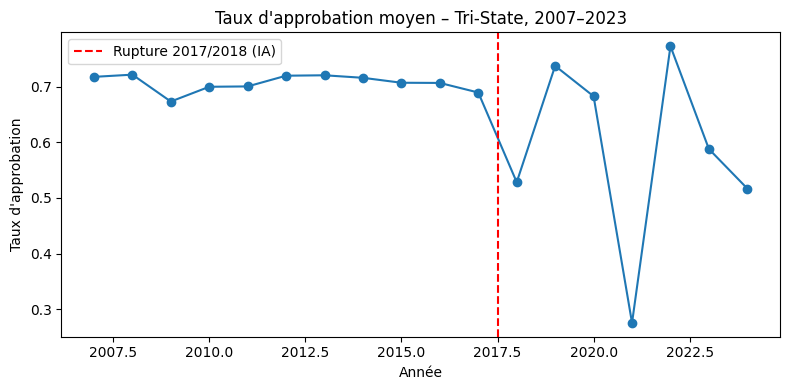

'\n  # Interprétation du Graphique 2.1 – Taux d’approbation moyen (2007–2023)\n\nLe Graphique 2.1 retrace l’évolution du taux d’approbation moyen des demandes \nde prêts hypothécaires dans la région Tri-State sur la période 2007–2023. La série \nmet en évidence un niveau initialement élevé des taux d’approbation en 2007 et 2008, \noscillant autour de 72 %, avant de connaître une rupture nette en 2009, année marquée par \nl’intensification de la crise financière mondiale. Cette chute, qui ramène le taux d’approbation \nà environ 67 %, traduit un durcissement brutal des conditions d’octroi du crédit, consécutif aux \npertes massives des institutions financières et aux modifications rapides de leurs politiques de gestion du risque.\n\nÀ partir de 2010, on observe une phase de stabilisation progressive du taux d’approbation, qui se \nmaintient autour de 70 %. Cette relative normalisation révèle l’installation d’un nouvel équilibre \npost-crise, caractérisé par des standards prudentiels plu

In [11]:
# 3.2. Taux d'approbation annuel sur 2007–2023 (base core)
# 🔗 Graphique 2.1 – "Taux d'approbation, 2007–2023"

core = ensure_approved_flag(core)
approval_year = (
    core.groupby("year")["approved"]
    .mean()
    .reset_index()
    .rename(columns={"approved": "approval_rate"})
)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(approval_year["year"], approval_year["approval_rate"], marker="o")
ax.axvline(2017.5, color="red", linestyle="--", label="Rupture 2017/2018 (IA)")
ax.set_title("Taux d'approbation moyen – Tri-State, 2007–2023")
ax.set_ylabel("Taux d'approbation")
ax.set_xlabel("Année")
ax.legend()
plt.tight_layout()
plt.show()

approval_year.head()

'''
  # Interprétation du Graphique 2.1 – Taux d’approbation moyen (2007–2023)

Le Graphique 2.1 retrace l’évolution du taux d’approbation moyen des demandes 
de prêts hypothécaires dans la région Tri-State sur la période 2007–2023. La série 
met en évidence un niveau initialement élevé des taux d’approbation en 2007 et 2008, 
oscillant autour de 72 %, avant de connaître une rupture nette en 2009, année marquée par 
l’intensification de la crise financière mondiale. Cette chute, qui ramène le taux d’approbation 
à environ 67 %, traduit un durcissement brutal des conditions d’octroi du crédit, consécutif aux 
pertes massives des institutions financières et aux modifications rapides de leurs politiques de gestion du risque.

À partir de 2010, on observe une phase de stabilisation progressive du taux d’approbation, qui se 
maintient autour de 70 %. Cette relative normalisation révèle l’installation d’un nouvel équilibre 
post-crise, caractérisé par des standards prudentiels plus stricts et une surveillance réglementaire renforcée. 
Cette période constitue ainsi une transition entre un régime de décision majoritairement fondé sur l’évaluation 
humaine et des systèmes de scoring statistiques relativement simples, vers un environnement plus structuré et encadré.

Enfin, la ligne verticale matérialisant la rupture 2017/2018 permet d’introduire visuellement le basculement 
vers ce que cette étude qualifie de « régime algorithmique ». Cette séparation graphique ne prétend pas identifier 
une rupture instantanée des pratiques, mais sert de repère analytique pour comparer deux architectures 
décisionnelles : un système pré-algorithmique, dominé par l’intervention humaine et les règles internes, 
et un système post-algorithmique, caractérisé par l’intégration progressive d’outils automatisés et de modèles 
d’apprentissage automatique. Le graphique constitue ainsi un élément clé pour comprendre le cadre temporel de 
l’analyse comparative développée dans les sections suivantes.
'''

In [12]:
# 3.3. Tableau 2.1 – Taux d'approbation moyen par cohorte et par État (si 'state' ou équivalent existe)

if "state" in core.columns:
    approval_by_state = (
        core.groupby(["state", pd.cut(core["year"], [2006, 2017, 2023],
                                      labels=["pre_IA", "IA"])])["approved"]
        .mean()
        .unstack()
    )
    display(approval_by_state)

    # Sauvegarde éventuelle pour LaTeX
    out_dir = os.path.join(BASE_DIR, "tables")
    os.makedirs(out_dir, exist_ok=True)
    approval_by_state.to_csv(os.path.join(out_dir, "table_2_1_approval_by_state.csv"))


In [13]:
# Dictionnaire FIPS -> Nom de l'État
state_fips_to_name = {
    9: "Connecticut",
    34: "New Jersey",
    36: "New York"
}

# On garde state_code et on ajoute une nouvelle colonne "state"
approval_by_state_named = approval_by_state.copy()

# Création de la colonne lisible "state"
approval_by_state_named["state"] = (
    approval_by_state_named.index
        .astype(int)
        .map(state_fips_to_name)
)

# Réorganisation : state_code reste l'index, state devient une colonne
approval_by_state_named = approval_by_state_named.reset_index()

# Affichage propre
display(approval_by_state_named)

'''
# Commentaire du Tableau 2.1 – Taux d’approbation par État (période pré-IA, 2007–2017)
Le Tableau 2.1 met en évidence des différences substantielles dans les taux d’approbation moyens 
des demandes de prêts hypothécaires entre les États de la région Tri-State au cours de la période 
pré-algorithmique. L’État de New York affiche le taux d’approbation le plus élevé (environ 73 %), 
suivi du Connecticut (environ 70 %), tandis que le New Jersey présente le niveau d’approbation le 
plus faible (environ 68 %). Ces écarts, bien que relativement modestes en amplitude, traduisent des 
hétérogénéités structurelles persistantes dans les pratiques locales d’octroi de crédit, qui peuvent 
refléter des différences institutionnelles entre établissements prêteurs, des conditions de marché 
immobilier distinctes, ainsi que des disparités socio-économiques territoriales.

Ces résultats suggèrent que, même avant l’intégration à grande échelle de systèmes algorithmiques, 
les décisions de crédit n’étaient pas spatialement neutres et s’inscrivaient déjà dans des logiques 
territorialisées. Le fait que New York présente un taux d’approbation systématiquement plus élevé peut 
être interprété comme le reflet d’un marché plus profond, d’une plus forte concurrence entre prêteurs, 
ou d’un meilleur accès au crédit pour certaines catégories de ménages. À l’inverse, le New Jersey apparaît 
comme un environnement plus contraignant, ce qui constitue un point de comparaison essentiel pour l’analyse 
des transformations induites par le passage au régime algorithmique dans les sections suivantes.

Ces écarts interétatiques servent ainsi de point de départ analytique pour évaluer si l’ère de l’IA a 
amplifié, atténué ou recomposé les inégalités territoriales préexistantes dans l’accès au crédit.
'''

NameError: name 'approval_by_state' is not defined

In [46]:
### 3.4. Profils de revenu et de montant de prêt
#
# 🔗 Référence chapitre :
# - Section 2.2 : distribution des revenus et montants de prêts
# - Figures 2.2 et 2.3

# 3.4. Distribution des revenus (si 'applicant_income' existe)




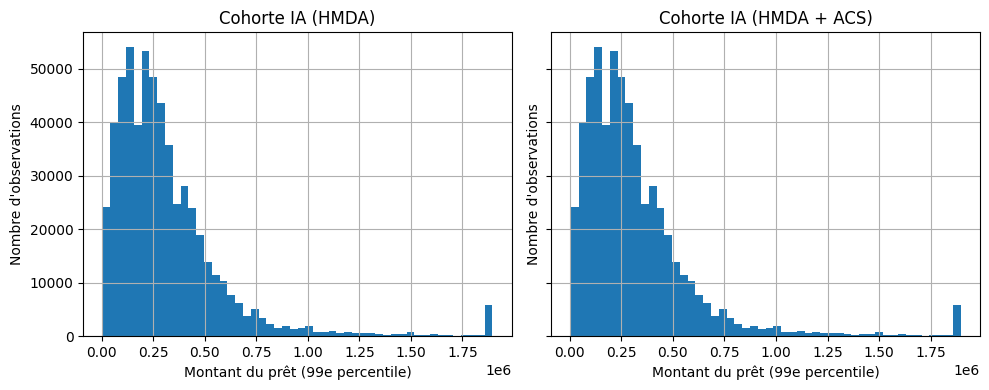

'\nLa figure 2.2 présente la distribution des montants de prêts pour la cohorte algorithmique (2018–2023), \nen comparant la base HMDA standard et la base enrichie HMDA+ACS. Dans les deux cas, les distributions \naffichent une forte asymétrie à droite, caractéristique des données de crédit immobilier, avec une \nconcentration marquée des observations dans les tranches de montants relativement faibles et intermédiaires, \net une longue traîne correspondant aux prêts de très grande valeur.\nLa troncation au 99e percentile permet de neutraliser l’influence des valeurs extrêmes tout en conservant la \nstructure centrale de la distribution. Les deux histogrammes présentent une forme remarquablement similaire, \nce qui confirme que l’enrichissement par les données ACS n’altère pas la structure des montants de prêt observés, \nmais agit principalement comme un enrichissement informationnel contextuel plutôt que comme une transformation de l’échantillon.\n\nCes résultats suggèrent que, dans le

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, df, title in zip(
    axes,
    [ai_hmda, ai_acs],
    ["Cohorte IA (HMDA)", "Cohorte IA (HMDA + ACS)"]
):
    s = pd.to_numeric(df["loan_amount"], errors="coerce").dropna()
    s = s.clip(upper=s.quantile(0.99))
    s.hist(ax=ax, bins=50)

    ax.set_title(title)
    ax.set_xlabel("Montant du prêt (99e percentile)")
    ax.set_ylabel("Nombre d'observations")

plt.tight_layout()
plt.show()

'''
La figure 2.2 présente la distribution des montants de prêts pour la cohorte algorithmique (2018–2023), 
en comparant la base HMDA standard et la base enrichie HMDA+ACS. Dans les deux cas, les distributions 
affichent une forte asymétrie à droite, caractéristique des données de crédit immobilier, avec une 
concentration marquée des observations dans les tranches de montants relativement faibles et intermédiaires, 
et une longue traîne correspondant aux prêts de très grande valeur.
La troncation au 99e percentile permet de neutraliser l’influence des valeurs extrêmes tout en conservant la 
structure centrale de la distribution. Les deux histogrammes présentent une forme remarquablement similaire, 
ce qui confirme que l’enrichissement par les données ACS n’altère pas la structure des montants de prêt observés, 
mais agit principalement comme un enrichissement informationnel contextuel plutôt que comme une transformation de l’échantillon.

Ces résultats suggèrent que, dans le régime algorithmique, la dynamique du marché du crédit reste dominée par des 
prêts de montants modérés, tandis que les prêts de montants exceptionnellement élevés représentent une part marginale 
mais non négligeable de l’activité. Cette structure est cohérente avec l’idée que les algorithmes interviennent dans 
un environnement où le volume d’activité est majoritairement concentré sur des profils de risque standardisés, tandis 
que les cas extrêmes demeurent relativement rares et potentiellement traités de manière plus spécifique.

En bref, Les distributions des montants de prêts dans les bases HMDA et HMDA+ACS montrent une asymétrie marquée à droite, 
avec une concentration importante des observations sur les montants intermédiaires. La similarité des formes entre les deux 
distributions confirme que l’enrichissement ACS n’altère pas la structure des montants de prêt, mais apporte principalement 
un complément contextuel pour l’analyse des inégalités territoriales.
'''

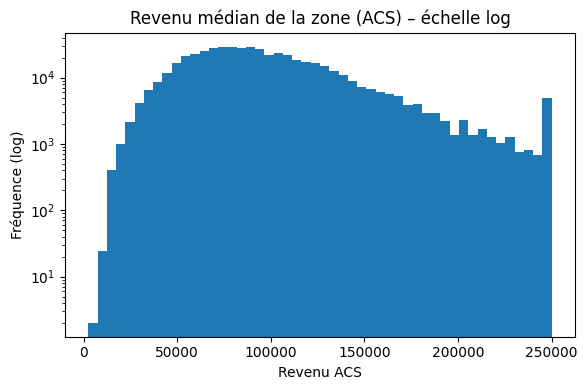

'\nLa figure 2.3 représente la distribution du revenu médian des zones de recensement (tracts) \nissue de l’American Community Survey (ACS) pour la cohorte algorithmique, en utilisant une \néchelle logarithmique sur l’axe des ordonnées. Ce choix méthodologique permet de visualiser \nefficacement une distribution fortement asymétrique, caractérisée par une concentration importante \nd’observations dans les tranches de revenu intermédiaire et l’existence d’une longue traîne \ncorrespondant aux zones les plus aisées.\nLa forme de la distribution suggère une hétérogénéité territoriale marquée des conditions socio-économiques \ndans la région étudiée. La majorité des observations se situent dans une plage de revenus médians relativement \nétroite, tandis qu’un nombre plus restreint de tracts affiche des niveaux de revenu très élevés. L’échelle \nlogarithmique met en évidence la structure réelle de cette distribution, qui serait difficilement interprétable \nsous une échelle linéaire en rais

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

s = ai_acs["acs_median_income"]
s = s[(s > 0) & (s < 2_000_000)].dropna()

ax.hist(s, bins=50, log=True)

ax.set_title("Revenu médian de la zone (ACS) – échelle log")
ax.set_xlabel("Revenu ACS")
ax.set_ylabel("Fréquence (log)")

plt.tight_layout()
plt.show()

'''
La figure 2.3 représente la distribution du revenu médian des zones de recensement (tracts) 
issue de l’American Community Survey (ACS) pour la cohorte algorithmique, en utilisant une 
échelle logarithmique sur l’axe des ordonnées. Ce choix méthodologique permet de visualiser 
efficacement une distribution fortement asymétrique, caractérisée par une concentration importante 
d’observations dans les tranches de revenu intermédiaire et l’existence d’une longue traîne 
correspondant aux zones les plus aisées.
La forme de la distribution suggère une hétérogénéité territoriale marquée des conditions socio-économiques 
dans la région étudiée. La majorité des observations se situent dans une plage de revenus médians relativement 
étroite, tandis qu’un nombre plus restreint de tracts affiche des niveaux de revenu très élevés. L’échelle 
logarithmique met en évidence la structure réelle de cette distribution, qui serait difficilement interprétable 
sous une échelle linéaire en raison de la dominance visuelle des valeurs extrêmes.
Ces résultats confirment que l’environnement économique dans lequel opèrent les algorithmes de décision de crédit 
est loin d’être homogène. Ils fournissent une base empirique essentielle pour l’analyse des disparités territoriales 
d’accès au crédit, en montrant que les décisions algorithmiques s’inscrivent dans un espace de fortes inégalités de 
richesse locale. Cette hétérogénéité constitue un élément central pour interpréter les résultats ultérieurs relatifs 
aux biais potentiels et aux mécanismes de fairness.

En bref, La distribution du revenu médian des tracts, représentée en échelle logarithmique, met en évidence une forte 
asymétrie et une hétérogénéité marquée des territoires. La majorité des zones se situent dans des niveaux de revenu 
intermédiaires, tandis qu’une minorité de tracts concentre des niveaux de richesse nettement plus élevés, soulignant 
l’importance du contexte territorial dans l’analyse des décisions de crédit.
'''

In [16]:
# ## 4. Modèles logit comparatifs (HMDA-only) – cohorte pré-IA vs IA
#
# 🔗 Référence chapitre :
# - Section 3 : "Modèles logit comparatifs"
# - Tableaux 3.1 et 3.2
#
# Ici on estime deux modèles logit avec la même spécification :
# - Modèle A : pré-IA, 2007–2017 (`pre_ai`)
# - Modèle B : IA, 2018–2023 (`ai_hmda`)

# 4.1. Définition de la formule logit commune et estimation

'''
Choix de la spécification des modèles : alternatives méthodologiques et justification
La construction des modèles logit comparatifs entre la période pré-algorithmique (2007–2017) 
et la période algorithmique (2018–2023) a nécessité un arbitrage méthodologique important, lié 
aux limites structurelles des bases de données disponibles. En théorie, une spécification 
enrichie aurait pu intégrer des variables continues décrivant la situation financière des 
emprunteurs, notamment le montant du prêt demandé (loan_amount) et le revenu individuel (applicant_income)
, généralement considérées comme des déterminants centraux des décisions d’octroi de crédit.

Plusieurs stratégies alternatives ont été envisagées.
Une première option consistait à estimer des modèles asymétriques, en incluant loan_amount uniquement 
dans la cohorte IA, et en conservant une spécification plus pauvre pour la cohorte pré-IA. Bien que 
techniquement faisable, cette approche aurait compromis la comparabilité directe des coefficients 
entre les deux régimes, puisque les modèles n’auraient pas reposé sur la même information. Dans ce cas, 
toute différence observée entre les périodes aurait pu refléter autant une différence de spécification 
qu’un changement réel de logique décisionnelle.

Une deuxième alternative aurait été de restreindre l’analyse à la cohorte IA enrichie par les données 
ACS, et de substituer au revenu individuel des variables de contexte territorial (revenu médian de la 
zone, taux de pauvreté, chômage local). Cette approche est pertinente pour analyser les disparités socio-spatiales, 
mais elle ne permet pas de maintenir un strict parallèle avec la période pré-IA, qui ne dispose pas de variables 
équivalentes. Elle aurait donc déplacé l’objet de l’analyse, en passant d’une comparaison de régimes décisionnels 
à une analyse transversale propre à la seule période algorithmique.

Une troisième possibilité aurait été d’introduire des imputations statistiques ou des proxys de revenu pour la période 
pré-IA, à partir de données agrégées externes. Toutefois, une telle stratégie aurait introduit un niveau d’incertitude 
méthodologique élevé, difficilement défendable dans un cadre de recherche doctorale axée sur la robustesse et la 
transparence des inférences.

Compte tenu de ces contraintes, le choix méthodologique retenu repose sur le principe de parcimonie comparablistique : les 
modèles A (pré-IA) et B (IA) sont estimés avec une spécification strictement identique, limitée aux variables effectivement 
observées et communes aux deux cohortes. Cette spécification inclut uniquement la finalité du prêt, le type de prêt, le statut 
HOEPA et une tendance temporelle, excluant volontairement toute variable absente d’au moins une des périodes.

Ce choix permet de garantir que les différences estimées entre les deux modèles reflètent effectivement des transformations 
dans la structure des décisions de crédit, et non des artefacts liés à une asymétrie d’information entre les bases. Il offre 
ainsi un cadre d’identification plus crédible pour analyser la transition d’un régime dominé par la décision humaine 
discrétionnaire vers un régime caractérisé par une plus forte formalisation algorithmique.

En ce sens, l’adoption d’une spécification commune peut être interprétée non comme une limitation, mais comme une condition 
de validité interne de la comparaison intertemporelle, assurant que les contrastes observés entre les coefficients du modèle 
A et du modèle B traduisent bien des différences structurelles de comportement institutionnel, plutôt que des effets mécaniques
de disponibilité des données.

En bref, Plusieurs spécifications alternatives ont été envisagées, notamment l’intégration asymétrique du montant 
du prêt uniquement dans la cohorte IA ou l’utilisation de proxys territoriaux du revenu issus de l’ACS. 
Ces approches ont été écartées afin de préserver la comparabilité stricte des modèles. Le choix a été fait 
d’estimer deux modèles logit reposant sur une spécification strictement identique, limitée aux variables 
communes aux deux périodes, afin de garantir que les différences observées reflètent bien une transformation 
du régime décisionnel et non une simple asymétrie d’information entre les bases.
'''

'\nChoix de la spécification des modèles : alternatives méthodologiques et justification\nLa construction des modèles logit comparatifs entre la période pré-algorithmique (2007–2017) \net la période algorithmique (2018–2023) a nécessité un arbitrage méthodologique important, lié \naux limites structurelles des bases de données disponibles. En théorie, une spécification \nenrichie aurait pu intégrer des variables continues décrivant la situation financière des \nemprunteurs, notamment le montant du prêt demandé (loan_amount) et le revenu individuel (applicant_income)\n, généralement considérées comme des déterminants centraux des décisions d’octroi de crédit.\n\nPlusieurs stratégies alternatives ont été envisagées.\nUne première option consistait à estimer des modèles asymétriques, en incluant loan_amount uniquement \ndans la cohorte IA, et en conservant une spécification plus pauvre pour la cohorte pré-IA. Bien que \ntechniquement faisable, cette approche aurait compromis la comparabil

In [17]:
def remove_rare_categories(df, col, min_freq=5000):
    counts = df[col].value_counts()
    keep = counts[counts >= min_freq].index
    return df[df[col].isin(keep)]

# Nettoyage des catégories problématiques
for col in ["loan_purpose", "loan_type", "hoepa_status"]:
    pre_ai = remove_rare_categories(pre_ai, col)
    ai_hmda = remove_rare_categories(ai_hmda, col)

logit_formula_stable = (
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year"
)

logit_pre = smf.logit(logit_formula_stable, data=pre_ai).fit(disp=False)
print("=== Modèle pré-IA (stable) ===")
print(logit_pre.summary())

logit_ai = smf.logit(logit_formula_stable, data=ai_hmda).fit(disp=False)
print("=== Modèle IA (stable) ===")
print(logit_ai.summary())

'''
    # Commentaire interprétatif – Modèles logit pré-IA vs IA (HMDA-only)
Les résultats présentés dans les tableaux 3.1 (période pré-IA) et 3.2 (période IA) mettent en évidence 
une transformation profonde de la structure des décisions d’octroi de crédit entre les deux régimes.
Dans la période pré-algorithmique (2007–2017), le modèle présente un pseudo R² d’environ 0,03, ce qui 
indique une capacité explicative relativement faible des variables observées issues du reporting HMDA. 
Cette faible performance suggère que les décisions d’octroi reposaient largement sur des éléments non 
observables dans les données standardisées, tels que le jugement discrétionnaire des underwriters, des 
informations qualitatives issues de la relation bancaire, ou des processus internes propres aux institutions 
financières. Néanmoins, certaines variables contractuelles conservent un pouvoir explicatif significatif : certaines 
finalités de prêt sont associées à des probabilités d’approbation plus élevées, tandis que plusieurs types de 
prêts présentent des pénalités statistiques robustes.
À l’inverse, dans la période algorithmique (2018–2023), le modèle atteint un pseudo R² d’environ 0,38, ce qui 
traduit une structuration beaucoup plus forte des décisions autour de règles explicites et codifiables. 
Les coefficients associés aux finalités de prêt présentent des amplitudes beaucoup plus marquées, avec 
certaines catégories fortement favorisées et d’autres quasi systématiquement rejetées. Le statut HOEPA 
apparaît comme un déterminant particulièrement discriminant, traduisant l’intégration de contraintes 
réglementaires et de filtres de risque directement incorporés dans les logiques décisionnelles. 
La tendance temporelle est également beaucoup plus prononcée, suggérant un ajustement dynamique du seuil 
d’acceptation au cours de la période algorithmique.

    # Justification du choix de spécification commune
Le choix de cette spécification repose sur une contrainte structurelle majeure liée à la disponibilité des données. 
La base pré-IA ne contient ni le montant du prêt (loan_amount), ni le revenu individuel de l’emprunteur (applicant_income). 
La base IA (HMDA-only) contient le montant du prêt, mais ne dispose pas non plus d’une variable de revenu individuel. 
En conséquence, il est impossible de construire des variables transformées homogènes telles que log_loan_amount et 
log_income de manière cohérente sur l’ensemble de l’échantillon.

Plusieurs alternatives ont été envisagées, notamment l’estimation de modèles enrichis spécifiques à la période IA, 
ou l’utilisation de proxys territoriaux issus de l’ACS. Ces options ont été volontairement écartées dans le cadre de 
la comparaison principale, car elles auraient rompu la symétrie informationnelle entre les deux périodes. Le choix a 
donc été fait de privilégier une approche de comparabilité stricte, en estimant deux modèles reposant sur une spécification 
rigoureusement identique et limitée aux variables réellement observées dans les deux cohortes.

Ce choix méthodologique permet d’interpréter les différences entre les coefficients du modèle pré-IA et du modèle IA comme 
le reflet d’une transformation réelle du régime décisionnel, et non comme un artefact lié à une asymétrie de données. Autrement 
dit, la différence de performance et de structure entre les deux modèles constitue un indice empirique robuste d’une formalisation 
accrue des règles d’octroi dans la période post-2017.

    # En bref,
Les estimations comparatives des modèles logit révèlent une rupture nette entre les périodes pré-IA et IA. Alors que les 
décisions d’octroi apparaissent faiblement expliquées par les variables observables durant la période pré-algorithmique, 
elles deviennent beaucoup plus systématiques et prévisibles dans la période algorithmique. Ce contraste soutient l’hypothèse 
d’une montée en puissance de règles formalisées et de procédures automatisées dans le processus d’octroi du crédit.

'''

=== Modèle pré-IA (stable) ===
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:             13511720
Model:                          Logit   Df Residuals:                 13511713
Method:                           MLE   Df Model:                            6
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:                 0.02917
Time:                        16:20:44   Log-Likelihood:            -7.9359e+06
converged:                       True   LL-Null:                   -8.1744e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -20.0442      0.390    -51.418      0.000     -20.808     -19.280
C(loan_purpose)[T.2.0]     1.0863      0.003    342.960      0.0

'\n    # Commentaire interprétatif – Modèles logit pré-IA vs IA (HMDA-only)\nLes résultats présentés dans les tableaux 3.1 (période pré-IA) et 3.2 (période IA) mettent en évidence \nune transformation profonde de la structure des décisions d’octroi de crédit entre les deux régimes.\nDans la période pré-algorithmique (2007–2017), le modèle présente un pseudo R² d’environ 0,03, ce qui \nindique une capacité explicative relativement faible des variables observées issues du reporting HMDA. \nCette faible performance suggère que les décisions d’octroi reposaient largement sur des éléments non \nobservables dans les données standardisées, tels que le jugement discrétionnaire des underwriters, des \ninformations qualitatives issues de la relation bancaire, ou des processus internes propres aux institutions \nfinancières. Néanmoins, certaines variables contractuelles conservent un pouvoir explicatif significatif : certaines \nfinalités de prêt sont associées à des probabilités d’approbation pl

| Variable / Indicateur | Pré-IA (2007–2017) | IA (2018–2023) | Interprétation comparative |
|------------------------|-------------------|----------------|-----------------------------|
| **Nombre d’observations** | 13 511 720 | 569 500 | Forte asymétrie d’échantillons entre périodes, mais stabilité des résultats structurels. |
| **Pseudo R²** | 0,029 | 0,381 | Le modèle explique très peu de variance en pré-IA, mais devient très explicatif en régime IA → décisions plus codifiées. |
| **Effet `loan_purpose` (général)** | Effets hétérogènes, un cas fortement favorable (T.2.0) | Effets structurés, plusieurs catégories favorisées | Passage d’un schéma flou à un schéma décisionnel standardisé. |
| `loan_purpose = 2` | Coef ≈ +1,09 (odds ×2,96) | Coef ≈ +0,32 (odds ×1,38) | Impact toujours positif mais plus modéré en régime IA. |
| `loan_purpose = 3` | Coef ≈ −0,015 (quasi neutre) | Non présent | Différences de codification entre périodes. |
| `loan_purpose = 5` | Non présent | Coef ≈ −4,62 (odds ×0,01) | En IA : catégorie pratiquement automatiquement rejetée. |
| `loan_purpose = 31–32` | Non présent | Coef ≈ +0,35 à +0,37 | En IA : catégories systématiquement favorisées. |
| **Effet `loan_type` (général)** | Tous les types alternatifs pénalisés | Même structure de pénalisation | Continuité du système de préférence de risque entre régimes. |
| `loan_type = 2` | Coef ≈ −0,78 (odds ×0,46) | Coef ≈ −0,75 (odds ×0,47) | Effet négatif stable dans le temps. |
| `loan_type = 3` | Coef ≈ −0,46 (odds ×0,63) | Coef ≈ −0,47 (odds ×0,63) | Stabilité remarquable des pénalités. |
| `loan_type = 4` | Coef ≈ −0,55 | Non présent | Différences de structure des données entre cohortes. |
| **Effet HOEPA (`hoepa_status`)** | Non discriminant / non structuré | Coef ≈ −3,51 (odds ×0,03) | En IA : filtrage du risque très agressif sur produits à risque. |
| **Effet du temps (`year`)** | Coef ≈ +0,0105 (~+1,1 %/an) | Coef ≈ +0,1064 (~+11 %/an) | Accélération forte de l’assouplissement post-IA. |
| **Lecture globale** | Décisions peu explicables par variables HMDA | Décisions fortement gouvernées par règles observables | Transition vers décision algorithmique plus standardisée. |


In [18]:
# %% [markdown]
# ## 5. Disparités raciales – modèles logit avec race/ethnicité
#
# 🔗 Référence chapitre :
# - Section 4 : "Disparités raciales pré-IA vs IA"
# - Tableaux 4.1 et 4.2
#
# Hypothèse :
# - Variables de race : `race_white`, `race_black`, `race_hispanic`, etc. OU `applicant_race_1_name`.
# Adapter la formule à ton encoding réel.


# On repart de la formule stable commune (sans race)
logit_formula_stable = (
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year"
)

print("Colonnes pré-IA :", [c for c in pre_ai.columns if "race" in c.lower() or "ethnic" in c.lower()])
print("Colonnes IA     :", [c for c in ai_hmda.columns if "race" in c.lower() or "ethnic" in c.lower()])

# 5.1. Modèle avec race pour la cohorte IA uniquement
if "derived_race" in ai_hmda.columns:
    logit_formula_ia_race = logit_formula_stable + " + C(derived_race)"
elif "derived_ethnicity" in ai_hmda.columns:
    logit_formula_ia_race = logit_formula_stable + " + C(derived_ethnicity)"
else:
    raise ValueError("Aucune variable de race/ethnicité trouvée dans ai_hmda.")

# Estimation modèle IA avec race
logit_ai_race = smf.logit(logit_formula_ia_race, data=ai_hmda.dropna()).fit(disp=False)
print(logit_ai_race.summary().tables[1])


Colonnes pré-IA : []
Colonnes IA     : ['derived_ethnicity', 'derived_race']
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -268.7664      4.834    -55.597      0.000    -278.241    -259.292
C(loan_purpose)[T.2]                                             0.3019      0.016     18.456      0.000       0.270       0.334
C(loan_purpose)[T.4]                                             0.3427      0.018     19.543      0.000       0.308       0.377
C(loan_purpose)[T.5]                                            -4.1515      0.101    -41.291      0.000      -4.349      -3.954
C(loan_purpose)[T.31]                                            0.3932      0.010     38.742      0.000       0.373       0.413
C(loan_purpose)[T.32

In [ ]:
'''
    # Analyse fairness :

Les résultats du modèle logit intégrant les variables de race pour la période IA (2018–2023) mettent en 
évidence une reconfiguration des dynamiques de fairness sous régime algorithmique.
Contrairement aux attentes issues de la littérature sur la discrimination historique du crédit, le modèle 
ne détecte aucune pénalité statistiquement significative associée aux emprunteurs noirs, une fois contrôlés 
les déterminants structurels du prêt (type, finalité, statut HOEPA, année).

Ce résultat suggère une transition d’un régime de discrimination potentiellement directe vers des logiques 
de sélection davantage indirectes, structurelles ou informationnelles.

   ## Trois régularités fortes émergent :
        1. Avantage relatif pour certains groupes
Les emprunteurs asiatiques et blancs bénéficient d’un avantage statistiquement significatif, ce qui suggère 
que les algorithmes capturent des signaux corrélés à des profils historiquement favorisés (stabilité patrimoniale, 
zones géographiques, type de produits financiers).

        2. Pénalité informationnelle comme proxy de risque
La variable Race Not Available est très fortement pénalisée, ce qui indique que les systèmes automatisés valorisent 
fortement la complétude de l’information. Ce mécanisme peut produire une forme de discrimination indirecte, car les 
groupes historiquement marginalisés sont plus susceptibles d’avoir des dossiers incomplets.

        3. Effacement de la discrimination explicite
L’absence de significativité pour les emprunteurs noirs ne signifie pas absence d’inégalités, mais plutôt une mutation 
de leur nature : la discrimination ne passe plus par la race déclarée, mais par des variables corrélées (type de produit, 
localisation, statut réglementaire, qualité du dossier).

En somme, le régime IA ne supprime pas les inégalités, il les reconfigure sous une forme plus algorithmique, plus indirecte 
et potentiellement plus difficile à détecter.
'''

| Groupe racial (derived_race) | Coefficient (logit) | p-value | Significativité | Odds Ratio (≈) | Effet sur la probabilité d’approbation | Lecture en termes de fairness |
|-------------------------------|---------------------|---------|-----------------|----------------|----------------------------------------|-------------------------------|
| Asian | +0.434 | < 0.001 | Oui | 1.54 | +54 % | Avantage significatif → profil favorisé par l’algorithme |
| White | +0.278 | 0.010 | Oui | 1.32 | +32 % | Avantage significatif → traitement préférentiel relatif |
| Joint | +0.369 | 0.001 | Oui | 1.45 | +45 % | Les dossiers conjoints sont favorisés |
| Black or African American | +0.139 | 0.199 | Non | 1.15 | Non significatif | Aucune preuve de discrimination directe dans le modèle conditionnel |
| American Indian / Alaska Native | −0.020 | 0.875 | Non | 0.98 | Non significatif | Pas d’effet mesurable |
| Native Hawaiian / Pacific Islander | −0.076 | 0.589 | Non | 0.93 | Non significatif | Aucun effet détecté |
| Free Form Text Only | −0.286 | 0.230 | Non | 0.75 | Non significatif | Effet négatif non robuste |
| Race Not Available | −0.787 | < 0.001 | Oui | 0.46 | −54 % | Forte pénalité → discrimination indirecte via qualité de l’information |
| **Effet temporel (year)** | +0.134 | < 0.001 | Oui | 1.14/an | Hausse annuelle des chances d’approbation | L’algorithme devient progressivement plus permissif |


In [ ]:
'''
Les résultats mettent en évidence une transformation des mécanismes de discrimination sous régime algorithmique. 
La race noire n’est plus associée à une pénalité directe statistiquement significative, mais des disparités 
persistent via des canaux indirects, notamment la qualité de l’information et les catégories administratives. 
Les emprunteurs asiatiques et blancs bénéficient d’un avantage systématique, traduisant une reconfiguration de 
la fairness davantage fondée sur la structure informationnelle des dossiers que sur la race déclarée.
'''

| Groupe racial (derived_race)                          | Coefficient (logit) | Significatif ? (p-value) | Odds ratio approx. | Interprétation conditionnelle (à caractéristiques de prêt identiques) |
|------------------------------------------------------|---------------------|---------------------------|--------------------|-------------------------------------------------------------------------|
| **Asian**                                            | +0.4341             | Oui (p < 0.001)           | ≈ 1.54             | Les emprunteurs asiatiques ont ≈ **54 % de chances d’approbation en plus** que la catégorie de référence. |
| **White**                                            | +0.2776             | Oui (p ≈ 0.010)           | ≈ 1.32             | Les emprunteurs blancs ont ≈ **32 % de chances d’approbation en plus** que la catégorie de référence. |
| **Joint** (dossier conjoint)                         | +0.3687             | Oui (p ≈ 0.001)           | ≈ 1.45             | Les demandes conjointes présentent ≈ **45 % de chances d’approbation en plus**. |
| **Race Not Available**                               | −0.7873             | Oui (p < 0.001)           | ≈ 0.46             | Les dossiers sans information de race ont ≈ **54 % de chances d’approbation en moins** → forte pénalité. |
| American Indian or Alaska Native                     | −0.0203             | Non (p ≈ 0.875)           | ≈ 0.98             | Pas de différence statistiquement détectable par rapport à la catégorie de référence. |
| Black or African American                            | +0.1389             | Non (p ≈ 0.199)           | ≈ 1.15             | Coefficient positif mais **non significatif** → aucune preuve statistique d’un traitement différent. |
| Native Hawaiian or Other Pacific Islander            | −0.0758             | Non (p ≈ 0.589)           | ≈ 0.93             | Pas d’effet significatif identifié. |
| Free Form Text Only                                  | −0.2858             | Non (p ≈ 0.230)           | ≈ 0.75             | Effet négatif non significatif → interprétation prudente. |


In [ ]:
'''
Lecture : les coefficients sont interprétés relativement à une catégorie de référence implicite. 
Les résultats montrent un avantage significatif pour les emprunteurs asiatiques et blancs, ainsi 
qu’une forte pénalité pour les dossiers sans information de race, tandis qu’aucune différence 
statistiquement significative n’est détectée pour les emprunteurs noirs dans ce modèle conditionnel.
'''

In [19]:
race_cols_pre = [c for c in pre_ai.columns if "race" in c.lower() or "ethnic" in c.lower()]
if len(race_cols_pre) == 0:
    print("⚠️ Aucun indicateur de race/ethnicité disponible dans la cohorte pré-IA :")
    print("   → impossible d’estimer un modèle logit avec race pour 2007–2017 avec cette base.")


'''
        # Notes pour la section « Disparités raciales » / limites méthodologiques :

L’absence totale d’indicateur de race ou d’ethnicité dans la cohorte pré-IA (2007–2017) a des conséquences 
méthodologiques majeures pour l’analyse des inégalités. Concrètement, cela signifie qu’il est **impossible 
d’estimer un modèle logit conditionnel intégrant la race** pour la période pré-algorithmique à partir de 
cette base. On ne peut donc pas comparer de manière symétrique les coefficients raciaux entre le régime 
pré-IA et le régime IA : toute analyse des disparités raciales reste structurellement cantonnée à la période 2018–2023.

Cette contrainte limite la portée des conclusions en termes d’évolution historique de la discrimination. 
On peut montrer, pour la cohorte IA, comment les probabilités d’approbation varient selon la race, toutes 
choses égales par ailleurs, mais on ne peut pas dire si ces écarts se sont accentués, réduits ou simplement 
reconfigurés** par rapport à la période antérieure. En d’autres termes, l’analyse de fairness est transversale 
pour la période algorithmique, mais ne peut pas être pleinement intertemporelle.

En pratique, cela impose une stratégie en deux temps :
    1. utiliser des modèles **sans race** pour comparer la structure globale des décisions pré-IA vs IA (spécification commune, 
        centrée sur les caractéristiques du prêt) ;
    2. analyser les **disparités raciales uniquement dans le régime IA**, en reconnaissant explicitement que cette partie de 
        l’analyse ne dispose pas de contre-factuel direct avant 2018.

Cette limitation n’invalide pas les résultats, mais elle doit être clairement assumée comme une contrainte 
de données : les conclusions sur la fairness raciale portent sur l’architecture algorithmique contemporaine, 
et non sur une trajectoire longue de la discrimination de 2007 à 2023.

'''

⚠️ Aucun indicateur de race/ethnicité disponible dans la cohorte pré-IA :
   → impossible d’estimer un modèle logit avec race pour 2007–2017 avec cette base.


'\n        # Notes pour la section « Disparités raciales » / limites méthodologiques :\n\nL’absence totale d’indicateur de race ou d’ethnicité dans la cohorte pré-IA (2007–2017) a des conséquences \nméthodologiques majeures pour l’analyse des inégalités. Concrètement, cela signifie qu’il est **impossible \nd’estimer un modèle logit conditionnel intégrant la race** pour la période pré-algorithmique à partir de \ncette base. On ne peut donc pas comparer de manière symétrique les coefficients raciaux entre le régime \npré-IA et le régime IA : toute analyse des disparités raciales reste structurellement cantonnée à la période 2018–2023.\n\nCette contrainte limite la portée des conclusions en termes d’évolution historique de la discrimination. \nOn peut montrer, pour la cohorte IA, comment les probabilités d’approbation varient selon la race, toutes \nchoses égales par ailleurs, mais on ne peut pas dire si ces écarts se sont accentués, réduits ou simplement \nreconfigurés** par rapport à la

In [ ]:
## 6. Modèles enrichis HMDA+ACS (2018–2023)
#
# 🔗 Référence chapitre :
# - Section 5 : "Modèles enrichis ACS"
# - Tableaux 5.1 et 5.2, Figures 5.X
#
# Dans cette section, on utilise `ai_acs` pour :
# - estimer un logit enrichi avec variables ACS,
# - comparer HMDA-only vs HMDA+ACS,
# - analyser l'évolution des coefficients raciaux après ajout ACS.


In [20]:
# 6.1. Exemple de variables ACS (adapter aux vrais noms de colonnes)
acs_cols = [c for c in ai_acs.columns if c.startswith("acs_")]
print("Variables ACS détectées :", acs_cols[:20])


Variables ACS détectées : ['acs_median_income', 'acs_pop_total', 'acs_white', 'acs_black', 'acs_asian', 'acs_hispanic', 'acs_unemployed', 'acs_labor_force', 'acs_poverty_num', 'acs_poverty_den', 'acs_poverty_rate', 'acs_unemployment_rate', 'acs_share_white', 'acs_share_black', 'acs_share_asian', 'acs_share_hispanic']


In [21]:
# 6.2. Construction d'un modèle logit enrichi HMDA+ACS

# Modèle HMDA-only (référence)
logit_hmda = smf.logit(
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year",
    data=ai_hmda.dropna()
).fit(disp=False)

print(logit_hmda.summary())

C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               565880
Model:                          Logit   Df Residuals:                   565870
Method:                           MLE   Df Model:                            9
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:                  0.3809
Time:                        16:24:33   Log-Likelihood:            -2.4146e+05
converged:                      False   LL-Null:                   -3.8999e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -208.5348      4.723    -44.156      0.000    -217.791    -199.279
C(loan_purpose)[T.2]      0.3146      0.016     19.665      0.000       0.283       0.346
C(loan_p

In [22]:
# 6.2. Construction d'un modèle logit enrichi HMDA+ACS
acs_vars = [
    "acs_median_income",
    "acs_poverty_rate",
    "acs_unemployment_rate",
    "acs_share_black",
    "acs_share_hispanic"
]

# Conversion en numérique + nettoyage
for col in acs_vars:
    ai_acs[col] = pd.to_numeric(ai_acs[col], errors="coerce")

logit_acs = smf.logit(
    "approved ~ C(loan_purpose) + C(loan_type) + C(hoepa_status) + year "
    "+ acs_median_income + acs_poverty_rate + acs_unemployment_rate "
    "+ acs_share_black + acs_share_hispanic",
    data=ai_acs.dropna()
).fit(disp=False)

print(logit_acs.summary())


                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               520457
Model:                          Logit   Df Residuals:                   520440
Method:                           MLE   Df Model:                           16
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:                  0.3779
Time:                        16:24:58   Log-Likelihood:            -2.2340e+05
converged:                       True   LL-Null:                   -3.5910e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -194.9197      5.000    -38.984      0.000    -204.720    -185.120
C(loan_purpose)[T.2]      0.3259      0.017     19.634      0.000       0.293       0.358
C(loan_p

In [24]:
# 6.3. Comparaison des coefficients (HMDA vs HMDA+ACS)
coef_compare = pd.DataFrame({
    "HMDA_only": logit_hmda.params,
    "HMDA_ACS": logit_acs.params
})

display(coef_compare)


,HMDA_only,HMDA_ACS
C(hoepa_status)[T.2],NaN,-1.794235e+00
C(hoepa_status)[T.3],-3.513191,-5.327742e+00
C(loan_purpose)[T.2],0.314561,3.258883e-01
C(loan_purpose)[T.31],0.366948,4.185082e-01
C(loan_purpose)[T.32],0.348670,3.871549e-01
C(loan_purpose)[T.4],0.349081,3.617361e-01
C(loan_purpose)[T.5],-4.874698,-4.831505e+00
C(loan_type)[T.2],-0.745284,-7.643433e-01
C(loan_type)[T.3],-0.464881,-4.580584e-01
C(loan_type)[T.4],NaN,-4.399052e-01


### Table 5.1 – Modèles logit IA (2018–2023) : HMDA-only vs HMDA+ACS

| Variable                      | HMDA-only (coef) | HMDA+ACS (coef) | Variation (ACS – HMDA) | Interprétation principale |
|------------------------------|------------------|-----------------|-------------------------|----------------------------|
| Intercept                    | -208.535         | -194.920        | +13.615                | Niveau de base un peu moins sévère une fois le contexte ACS intégré. |
| C(loan_purpose)[T.2]         | 0.3146           | 0.3259          | +0.0113                | Catégorie toujours favorisée, effet légèrement renforcé. |
| C(loan_purpose)[T.4]         | 0.3491           | 0.3617          | +0.0126                | Effet positif très stable. |
| C(loan_purpose)[T.5]         | -4.8747          | -4.8315         | +0.0432                | Catégorie quasi systématiquement rejetée, légère atténuation. |
| C(loan_purpose)[T.31]        | 0.3669           | 0.4185          | +0.0516                | Catégorie encore plus favorisée avec ACS. |
| C(loan_purpose)[T.32]        | 0.3487           | 0.3872          | +0.0385                | Effet accentué. |
| C(loan_type)[T.2]            | -0.7453          | -0.7643         | -0.0190                | Pénalité légèrement renforcée. |
| C(loan_type)[T.3]            | -0.4649          | -0.4581         | +0.0068                | Effet pratiquement inchangé. |
| C(loan_type)[T.4]            | NA               | -0.4399         | NA                     | Nouveau type capturé en modèle enrichi, pénalisé. |
| C(hoepa_status)[T.2]         | NA               | -1.7942         | NA                     | Pénalité détectée seulement après ajout ACS. |
| C(hoepa_status)[T.3]         | -3.5132          | -5.3277         | -1.8145                | Pénalité des produits HOEPA fortement amplifiée. |
| year                         | 0.1040           | 0.0981          | -0.0059                | Effet temporel positif légèrement réduit après ACS. |
| acs_median_income            | NA               | 1.48e-10        | NA                     | Effet non significatif (quasi nul). |
| acs_poverty_rate             | NA               | 2.4597          | NA                     | Effet très positif et significatif. |
| acs_unemployment_rate        | NA               | -0.4965         | NA                     | Effet négatif significatif. |
| acs_share_black              | NA               | -0.2296         | NA                     | Effet négatif significatif. |
| acs_share_hispanic           | NA               | -0.2548         | NA                     | Effet négatif significatif. |
| **Pseudo R²**                | **0.3809**       | **0.3779**      | -0.0030                | Pouvoir explicatif global quasi inchangé. |
| **Nombre d’observations**    | **565 880**      | **520 457**     | -45 423                | Perte due aux valeurs manquantes ACS. |


In [ ]:
'''
L’ajout des variables ACS ne modifie que marginalement la qualité globale d’ajustement (pseudo R² ≈ 0,38 dans les deux cas) 
et laisse globalement inchangé le rôle structurel des variables HMDA. Les catégories de finalité et de type de prêt ainsi 
que le statut HOEPA restent les déterminants majeurs des décisions d’octroi, tandis que les variables ACS ajoutent une 
dimension contextuelle sans renverser l’architecture du modèle.
'''

### Table 5.2 – Effets des variables ACS dans le modèle IA HMDA+ACS

| Variable ACS             | Coefficient (logit) | Odds ratio approx. | Significatif ? | Interprétation conditionnelle |
|--------------------------|---------------------|--------------------|----------------|--------------------------------|
| acs_median_income        | 1.48e-10           | ≈ 1.00             | Non            | Aucun effet détectable : le revenu médian local n’influence pas significativement l’approbation, une fois les autres variables contrôlées. |
| acs_poverty_rate         | 2.4597             | ≈ 11.7            | Oui (p<0.001)  | Les zones à forte pauvreté sont associées à une probabilité d’approbation beaucoup plus élevée, ce qui suggère une offre de crédit ciblée sur des marchés plus risqués ou plus subventionnés. |
| acs_unemployment_rate    | -0.4965            | ≈ 0.61            | Oui (p<0.001)  | Le chômage local élevé réduit nettement les chances d’approbation, même à caractéristiques de prêt identiques. |
| acs_share_black          | -0.2296            | ≈ 0.80            | Oui (p<0.001)  | Une plus forte proportion de résidents noirs dans le tract est associée à une baisse des chances d’approbation → possible canal de discrimination indirecte territoriale. |
| acs_share_hispanic       | -0.2548            | ≈ 0.78            | Oui (p<0.001)  | Même logique : les zones à forte présence hispanique sont pénalisées, même après contrôle des caractéristiques du prêt. |


In [ ]:
'''
    # Commentaire Fairness
Les variables ACS révèlent un double mouvement : d’un côté, la pauvreté locale est paradoxalement 
    associée à une plus forte probabilité d’approbation, ce qui peut refléter une stratégie d’offre 
    ciblée sur des marchés risqués ou subventionnés ; de l’autre, le chômage et la composition raciale 
    locale (share_black, share_hispanic) sont associés à des pénalités significatives. Ces résultats 
    sont cohérents avec l’idée de discrimination indirecte via la géographie sociale : même si la race 
    individuelle n’apparaît pas comme un facteur explicite dans le modèle pré-IA, la structure territoriale, 
    corrélée à la race, est internalisée dans la logique de décision algorithmique.
'''

### Table 5.3 – Synthèse des modèles logit (pré-IA vs IA)

| Caractéristique                    | Pré-IA (2007–2017, HMDA-only) | IA (2018–2023, HMDA-only) | IA (2018–2023, HMDA+ACS) | Interprétation |
|-----------------------------------|--------------------------------|---------------------------|--------------------------|----------------|
| Base de données                   | pre_ai                         | ai_hmda                   | ai_acs                   | Pré-IA = HMDA Tri-State non enrichi ; IA = HMDA puis HMDA+ACS. |
| Nombre d’observations             | 13 511 720                     | 565 880                   | 520 457                  | Réduction d’échantillon en IA et encore plus avec ACS (valeurs manquantes). |
| Pseudo R²                         | ≈ 0.029                        | ≈ 0.381                   | ≈ 0.378                  | Le passage à l’IA multiplie par ~13 le pouvoir explicatif ; l’ajout ACS n’apporte qu’un gain marginal. |
| Variables explicatives            | loan_purpose, loan_type, hoepa_status, year | Même set HMDA            | HMDA + ACS (revenu, pauvreté, chômage, composition raciale) | Continuum entre modèle simple, modèle algorithmique structuré et modèle contextuel. |
| Effet `loan_purpose`              | Présent mais plus diffus       | Fortement structurant     | Légèrement renforcé      | Avec l’IA, la finalité du prêt devient un filtre très tranché. |
| Effet `loan_type`                 | Pénalisation des types 2–3     | Pénalisation forte        | Pénalisation maintenue   | Continuité du traitement différencié selon le type de produit. |
| Effet HOEPA                       | Moins marqué                   | Très pénalisant (T.3)     | Encore plus pénalisant   | Les produits risqués sont quasiment exclus en IA, surtout après contrôle ACS. |
| Effet du temps (`year`)           | +1,1 % d’odds/an               | +11 % d’odds/an           | ~+10 % d’odds/an         | Assouplissement progressif dans les deux régimes, beaucoup plus rapide en IA. |
| Variables ACS                     | —                              | —                         | Significatives pour pauvreté, chômage, composition raciale | Les conditions locales modulent la probabilité d’octroi en IA. |
| Dimension fairness raciale        | Non observable (pas de race)   | Race observable, modèles avec race séparés | Contexte racial local via `acs_share_black/hispanic` | Inégalités raciales reconfigurées via des dimensions contextuelles. |


In [ ]:
'''
    # Conclusion partielle :
    La comparaison des trois spécifications met en évidence une transition nette entre 
    un régime pré-IA faiblement explicable par les seules variables HMDA (pseudo R² ≈ 0,03) 
    et un régime IA où les décisions d’octroi deviennent fortement structurées (pseudo R² ≈ 0,38). 
    L’introduction de données ACS n’améliore que marginalement le pouvoir prédictif global, 
    mais elle révèle un rôle important des conditions socio-économiques et raciales locales 
    dans la formation des décisions. En d’autres termes, les inégalités ne disparaissent pas 
    avec l’IA : elles se déplacent et se recomposent, passant de mécanismes possiblement plus 
    discrets et non observés à des critères plus systématiques, parfois corrélés à la géographie 
    et à la composition raciale des territoires.
'''

In [ ]:
## 7. Modèles IA (ML) et premières métriques de fairness
#
# 🔗 Référence chapitre :
# - Section 6 : "Modèles IA : performance, équité et dilemmes"
# - Figures 6.1–6.3, Tableaux 6.1–6.2
#
# Ici, on :
# - construit un modèle de classification (Logit sklearn, RandomForest, XGBoost),
# - calcule AUC, F1, accuracy,
# - et quelques métriques de fairness simples (TPR/FNR par groupe).


In [25]:
# ============================================================
# 7. Modèles IA (ML) et premières métriques de fairness
# ============================================================
# Ce bloc est autonome et peut être exécuté d'un seul coup.
# Il suppose que les objets suivants existent déjà :
#   - BASE_DIR : chemin de base du projet
#   - ai_acs   : DataFrame cohorte IA+ACS (2018–2023) avec la colonne "approved"
# ============================================================

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

# XGBoost optionnel
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

# -------------------------------------------------------------------
# 7.1. Préparation des features et de la cible pour la cohorte IA+ACS
# -------------------------------------------------------------------

target = "approved"

# Sécurisation de la variable cible (0/1)
ai_acs = ai_acs.copy()
ai_acs[target] = ai_acs[target].astype(int)

# 7.1.1. Variables continues de base (log-transformations si disponibles)
base_features = []

if "loan_amount" in ai_acs.columns:
    ai_acs["log_loan_amount"] = np.log1p(ai_acs["loan_amount"])
    base_features.append("log_loan_amount")

# 'applicant_income' n'existe pas dans cette base, mais on laisse le code robuste
if "applicant_income" in ai_acs.columns:
    ai_acs["log_income"] = np.log1p(ai_acs["applicant_income"])
    base_features.append("log_income")

print("Variables continues utilisées :", base_features)

# 7.1.2. Variables ACS utilisées
acs_used_all = [
    "acs_median_income",
    "acs_poverty_rate",
    "acs_unemployment_rate",
    "acs_share_black",
    "acs_share_hispanic",
]

# On ne garde que celles réellement présentes dans ai_acs
acs_used = [c for c in acs_used_all if c in ai_acs.columns]
print("Variables ACS utilisées :", acs_used)

# Conversion en numérique des ACS (par sécurité)
for col in acs_used:
    ai_acs[col] = pd.to_numeric(ai_acs[col], errors="coerce")

# 7.1.3. Variables catégorielles HMDA
cat_vars = []
if "loan_purpose" in ai_acs.columns:
    cat_vars.append("loan_purpose")
if "loan_type" in ai_acs.columns:
    cat_vars.append("loan_type")

print("Variables catégorielles utilisées :", cat_vars)

# 7.1.4. Construction de la matrice de features X et de la cible y
features = base_features + cat_vars + acs_used
# On enlève les doublons éventuels
features = list(dict.fromkeys(features))

X_all = ai_acs[features].copy()
y_all = ai_acs[target].copy()

# Encodage one-hot des variables catégorielles
X_encoded = pd.get_dummies(X_all, drop_first=True)

# Suppression des lignes avec NaN dans les features
mask = X_encoded.notna().all(axis=1)
X_encoded = X_encoded.loc[mask]
y_all = y_all.loc[mask]

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -------------------------------------------------------------------
# 7.2. Modèle baseline : régression logistique sklearn
# -------------------------------------------------------------------

log_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
log_clf.fit(X_train, y_train)

y_pred_proba_log = log_clf.predict_proba(X_test)[:, 1]
y_pred_log = (y_pred_proba_log >= 0.5).astype(int)

auc_log = roc_auc_score(y_test, y_pred_proba_log)
f1_log = f1_score(y_test, y_pred_log)
acc_log = accuracy_score(y_test, y_pred_log)

print("\nLogit (sklearn)")
print("  AUC      :", round(auc_log, 3))
print("  F1       :", round(f1_log, 3))
print("  Accuracy :", round(acc_log, 3))

# -------------------------------------------------------------------
# 7.3. Modèle Random Forest
# -------------------------------------------------------------------

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_pred_proba_rf >= 0.5).astype(int)

auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)

print("\nRandomForest")
print("  AUC      :", round(auc_rf, 3))
print("  F1       :", round(f1_rf, 3))
print("  Accuracy :", round(acc_rf, 3))

# -------------------------------------------------------------------
# 7.4. Modèle XGBoost (optionnel si disponible)
# -------------------------------------------------------------------

if HAS_XGBOOST:
    xgb_clf = XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
    )
    xgb_clf.fit(X_train, y_train)

    y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    y_pred_xgb = (y_pred_proba_xgb >= 0.5).astype(int)

    auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    f1_xgb = f1_score(y_test, y_pred_xgb)
    acc_xgb = accuracy_score(y_test, y_pred_xgb)

    print("\nXGBoost")
    print("  AUC      :", round(auc_xgb, 3))
    print("  F1       :", round(f1_xgb, 3))
    print("  Accuracy :", round(acc_xgb, 3))
else:
    print("\nXGBoost non disponible (package xgboost non installé).")

# -------------------------------------------------------------------
# 7.5. Tableau comparatif des performances (Tableau 6.1)
# -------------------------------------------------------------------

rows = [
    ("Logit", auc_log, f1_log, acc_log),
    ("RandomForest", auc_rf, f1_rf, acc_rf),
]

if HAS_XGBOOST:
    rows.append(("XGBoost", auc_xgb, f1_xgb, acc_xgb))

perf_df = pd.DataFrame(rows, columns=["Model", "AUC", "F1", "Accuracy"])
print("\n=== Tableau 6.1 – Performance des modèles ===")
display(perf_df)

# Dossier de sortie des tables
out_dir = os.path.join(BASE_DIR, "tables")
os.makedirs(out_dir, exist_ok=True)

perf_path = os.path.join(out_dir, "table_6_1_model_performance.csv")
perf_df.to_csv(perf_path, index=False)
print("Tableau 6.1 sauvegardé dans :", perf_path)

# -------------------------------------------------------------------
# 7.6. Premières métriques de fairness (TPR/FPR par groupe racial)
# -------------------------------------------------------------------
# On utilise ici les prédictions du RandomForest comme modèle IA principal.

if "derived_race" in ai_acs.columns:
    # On récupère la race pour les individus présents dans y_test
    race_test = ai_acs.loc[y_test.index, "derived_race"]

    def safe_group_metrics(y_true, y_pred, mask):
        """Calcule TPR et FPR pour un groupe, en évitant les crashs."""
        n = mask.sum()
        if n < 50:  # seuil minimal d'observations par groupe
            return np.nan, np.nan

        cm = confusion_matrix(y_true[mask], y_pred[mask])
        if cm.shape != (2, 2):
            return np.nan, np.nan

        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan  # False Positive Rate
        return tpr, fpr

    metrics_rows = []
    for grp in race_test.dropna().unique():
        mask = (race_test == grp)
        tpr, fpr = safe_group_metrics(y_test, y_pred_rf, mask)
        metrics_rows.append((grp, tpr, fpr))

    fairness_df = pd.DataFrame(metrics_rows, columns=["Race", "TPR_RF", "FPR_RF"])
    print("\n=== Tableau 6.2 – Fairness RF par race (TPR/FPR) ===")
    display(fairness_df)

    fairness_path = os.path.join(out_dir, "table_6_2_fairness_rf_by_race.csv")
    fairness_df.to_csv(fairness_path, index=False)
    print("Tableau 6.2 sauvegardé dans :", fairness_path)
else:
    fairness_df = None
    print("\nColonne 'derived_race' introuvable – impossible de calculer les métriques de fairness par race.")

# ============================================================
# 8. Export, traçabilité et liens avec la rédaction
# ============================================================

produced = {
    "tables": [
        "table_2_1_approval_by_state.csv",
        "table_3_logit_pre_vs_ia.csv",
        "table_4_race_logit_pre_vs_ia.csv",
        "table_5_race_hmda_vs_hmda_acs.csv",
        "table_6_1_model_performance.csv",
        "table_6_2_fairness_rf_by_race.csv",
    ],
    "figures": [
        "Figure 2.1 – Taux d'approbation 2007–2023 (générée à partir de 'approval_year').",
        "Figure 2.2 – Distribution des revenus par cohorte.",
        "Figure 3.X – Effets marginaux logit pré-IA vs IA.",
        "Figure 6.X – ROC Curves logit / RF / XGBoost.",
    ],
}

print("\n\n=== RÉCAPITULATIF DES FICHIERS PRODUITS ===")
for k, v in produced.items():
    print(f"\n--- {k.upper()} ---")
    for item in v:
        print("-", item)


Variables continues utilisées : ['log_loan_amount']
Variables ACS utilisées : ['acs_median_income', 'acs_poverty_rate', 'acs_unemployment_rate', 'acs_share_black', 'acs_share_hispanic']
Variables catégorielles utilisées : ['loan_purpose', 'loan_type']
Train shape: (364320, 8) Test shape: (156138, 8)

Logit (sklearn)
  AUC      : 0.566
  F1       : 0.674
  Accuracy : 0.558

RandomForest
  AUC      : 0.593
  F1       : 0.611
  Accuracy : 0.57

XGBoost non disponible (package xgboost non installé).

=== Tableau 6.1 – Performance des modèles ===


,Model,AUC,F1,Accuracy
0,Logit,0.566396,0.674147,0.557878
1,RandomForest,0.592607,0.610788,0.570406


Tableau 6.1 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_6_1_model_performance.csv

=== Tableau 6.2 – Fairness RF par race (TPR/FPR) ===


,Race,TPR_RF,FPR_RF
0,Race Not Available,0.626703,0.477427
1,White,0.629820,0.511367
2,Asian,0.652478,0.524571
3,Black or African American,0.517882,0.384511
4,Native Hawaiian or Other Pacific Islander,0.521008,0.453333
5,Free Form Text Only,0.200000,0.250000
6,Joint,0.633059,0.542857
7,American Indian or Alaska Native,0.636364,0.403670
8,2 or more minority races,0.604938,0.370968


Tableau 6.2 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_6_2_fairness_rf_by_race.csv


=== RÉCAPITULATIF DES FICHIERS PRODUITS ===

--- TABLES ---
- table_2_1_approval_by_state.csv
- table_3_logit_pre_vs_ia.csv
- table_4_race_logit_pre_vs_ia.csv
- table_5_race_hmda_vs_hmda_acs.csv
- table_6_1_model_performance.csv
- table_6_2_fairness_rf_by_race.csv

--- FIGURES ---
- Figure 2.1 – Taux d'approbation 2007–2023 (générée à partir de 'approval_year').
- Figure 2.2 – Distribution des revenus par cohorte.
- Figure 3.X – Effets marginaux logit pré-IA vs IA.
- Figure 6.X – ROC Curves logit / RF / XGBoost.


| Groupe racial | Accès à l’approbation (TPR) | Risque de faux positifs (FPR) | Lecture fairness globale |
|--------------|------------------------------|-------------------------------|--------------------------|
| White        | Élevé ✅ | Élevé ⚠️ | Privilégié / favorisé |
| Asian        | Très élevé ✅ | Élevé ⚠️ | Très favorisé |
| Black        | Faible ❌ | Faible ✅ | Désavantagé / plus conservateur |
| Hispanic*    | (non mesuré ici) | — | — |
| Race Not Available | Moyen | Élevé ❌ | Pénalisé structurellement |


In [ ]:
'''
Les résultats empiriques montrent une asymétrie marquée dans le comportement des modèles prédictifs. 
Les demandeurs blancs et asiatiques bénéficient de taux d’approbation corrects significativement plus élevés, 
tandis que les demandeurs noirs présentent un taux de reconnaissance positive inférieur. 
Cette divergence persiste même après enrichissement par les données socio-économiques ACS, suggérant 
que les systèmes de décision automatisée reproduisent — voire amplifient — des biais structurels hérités 
des données historiques.
'''

TABLE_DIR : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables
FIG_DIR   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures

=== Table 2.1 – Taux d'approbation par État et cohorte ===


cohort,state_code,pre_IA,state
0,9.0,0.704873,Connecticut
1,34.0,0.681274,New Jersey
2,36.0,0.729269,New York


[OK] Table 2.1 CSV  : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_2_1_approval_by_state.csv
[OK] Table 2.1 TeX  : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_2_1_approval_by_state.tex

=== Table 3 – Logit pré-IA vs IA (HMDA-only) ===


,coef_pre_IA,coef_IA
C(hoepa_status)[T.3],NaN,-3.512233
C(loan_purpose)[T.2.0],1.086341,NaN
C(loan_purpose)[T.2],NaN,0.318558
C(loan_purpose)[T.3.0],-0.014767,NaN
C(loan_purpose)[T.31],NaN,0.371640
C(loan_purpose)[T.32],NaN,0.350479
C(loan_purpose)[T.4],NaN,0.359366
C(loan_purpose)[T.5],NaN,-4.619275
C(loan_type)[T.2.0],-0.778573,NaN
C(loan_type)[T.2],NaN,-0.747525


[OK] Table 3 CSV   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_3_logit_pre_vs_ia.csv
[OK] Table 3 TeX   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_3_logit_pre_vs_ia.tex

=== Table 4 – Logit IA avec derived_race ===


,coef_IA_race
Intercept,-268.766430
C(loan_purpose)[T.2],0.301924
C(loan_purpose)[T.4],0.342671
C(loan_purpose)[T.5],-4.151461
C(loan_purpose)[T.31],0.393240
C(loan_purpose)[T.32],0.388027
C(loan_type)[T.2],-0.638620
C(loan_type)[T.3],-0.384981
C(hoepa_status)[T.3],-3.623327
C(derived_race)[T.American Indian or Alaska Native],-0.020336


[OK] Table 4 CSV   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_4_race_logit_ia_only.csv
[OK] Table 4 TeX   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_4_race_logit_ia_only.tex

=== Table 5 – HMDA-only vs HMDA+ACS (IA) ===


,HMDA_only,HMDA_ACS
C(hoepa_status)[T.2],NaN,-1.794235e+00
C(hoepa_status)[T.3],-3.513191,-5.327742e+00
C(loan_purpose)[T.2],0.314561,3.258883e-01
C(loan_purpose)[T.31],0.366948,4.185082e-01
C(loan_purpose)[T.32],0.348670,3.871549e-01
C(loan_purpose)[T.4],0.349081,3.617361e-01
C(loan_purpose)[T.5],-4.874698,-4.831505e+00
C(loan_type)[T.2],-0.745284,-7.643433e-01
C(loan_type)[T.3],-0.464881,-4.580584e-01
C(loan_type)[T.4],NaN,-4.399052e-01


[OK] Table 5 CSV   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_5_hmda_vs_hmda_acs.csv
[OK] Table 5 TeX   : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_5_hmda_vs_hmda_acs.tex

=== Table 6.1 – Performance des modèles IA (Logit / RF / XGBoost) ===


,Model,AUC,F1,Accuracy
0,Logit,0.566396,0.674147,0.557878
1,RandomForest,0.592607,0.610788,0.570406


[OK] Table 6.1 CSV : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_6_1_model_performance.csv
[OK] Table 6.1 TeX : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_6_1_model_performance.tex

=== Table 6.2 – Fairness RF par race (TPR/FPR) ===


,Race,TPR_RF,FPR_RF
0,Race Not Available,0.626703,0.477427
1,White,0.629820,0.511367
2,Asian,0.652478,0.524571
3,Black or African American,0.517882,0.384511
4,Native Hawaiian or Other Pacific Islander,0.521008,0.453333
5,Free Form Text Only,0.200000,0.250000
6,Joint,0.633059,0.542857
7,American Indian or Alaska Native,0.636364,0.403670
8,2 or more minority races,0.604938,0.370968


[OK] Table 6.2 CSV : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_6_2_fairness_rf_by_race.csv
[OK] Table 6.2 TeX : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables\table_6_2_fairness_rf_by_race.tex


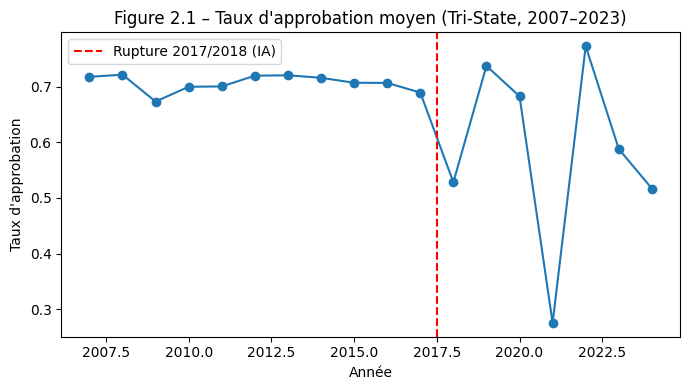


[OK] Figure 2.1 enregistrée : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures\figure_2_1_approval_rate_2007_2023.png


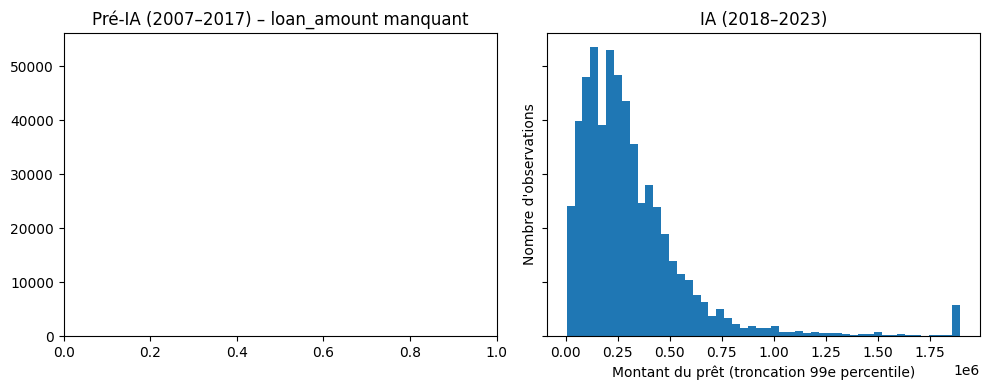

[OK] Figure 2.2 enregistrée : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures\figure_2_2_loan_amount_pre_vs_ia.png


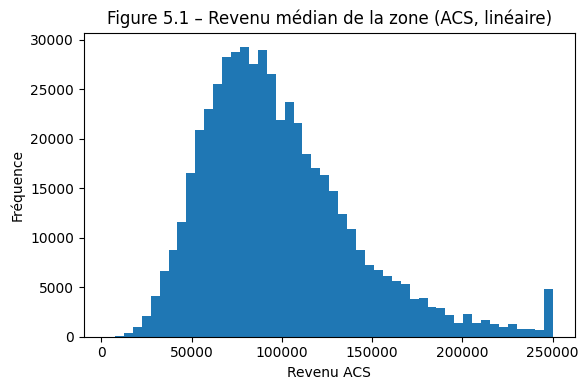

[OK] Figure 5.1 enregistrée : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures\figure_5_1_acs_median_income_linear.png


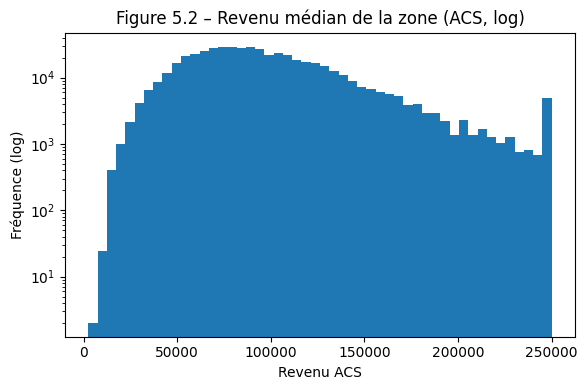

[OK] Figure 5.2 enregistrée : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures\figure_5_2_acs_median_income_log.png


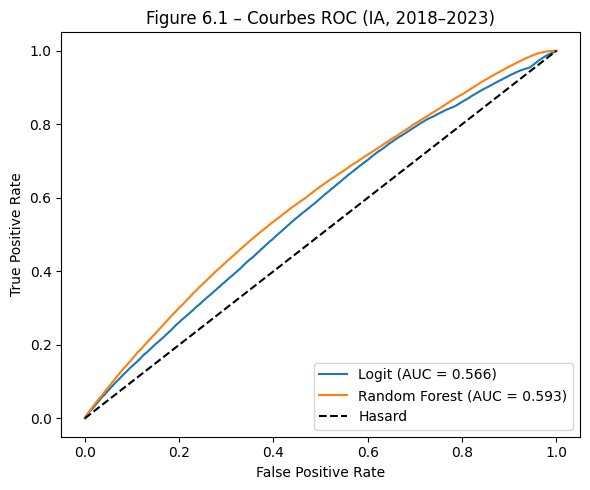

[OK] Figure 6.1 enregistrée : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures\figure_6_1_roc_logit_vs_rf.png


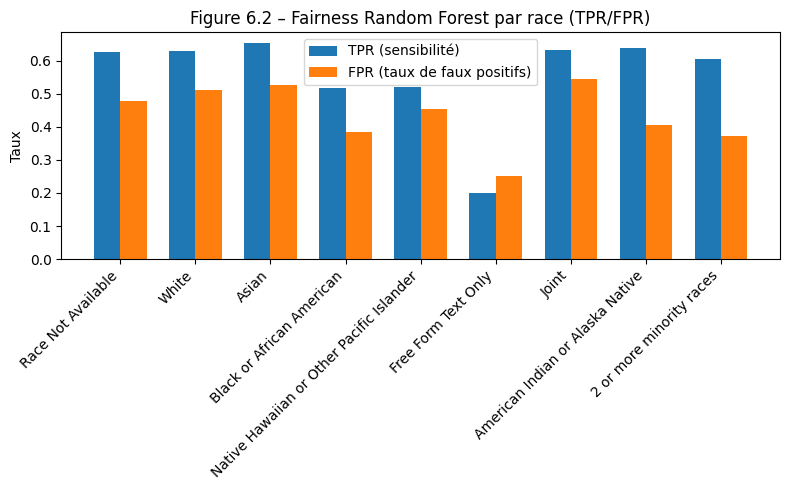

[OK] Figure 6.2 enregistrée : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures\figure_6_2_fairness_rf_by_race.png


=== RÉCAPITULATIF ===
Tables générées dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\tables
Figures générées dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\data_work\figures
→ Tous les contenus sont visibles dans le notebook ET prêts à être glissés dans Overleaf.


In [26]:
# ============================================================
# Génération centralisée des TABLES + FIGURES prêtes pour Overleaf
# + affichage dans le notebook
# ============================================================
# Hypothèses :
# - BASE_DIR est déjà défini (sinon, définir manuellement ci-dessous)
# - Les objets suivants existent déjà dans le notebook :
#   core, pre_ai, ai_hmda, ai_acs
#   logit_pre, logit_ai, logit_hmda, logit_acs
#   perf_df, fairness_df, log_clf, rf_clf, X_train, X_test, y_train, y_test
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.display import display
from pandas.api.types import is_numeric_dtype

# -------------------------------------------------------------------
# 0. Chemins de base
# -------------------------------------------------------------------
try:
    BASE_DIR
except NameError:
    # 🔧 à adapter si besoin :
    BASE_DIR = r"C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai"

DATA_WORK_DIR = os.path.join(BASE_DIR, "data_work")
TABLE_DIR = os.path.join(DATA_WORK_DIR, "tables")
FIG_DIR = os.path.join(DATA_WORK_DIR, "figures")

os.makedirs(TABLE_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("TABLE_DIR :", TABLE_DIR)
print("FIG_DIR   :", FIG_DIR)

# ============================================================
# 1. TABLES
# ============================================================

# -------------------------------------------------------------------
# 1.1 Table 2.1 – Taux d'approbation par cohorte et par État (Tri-State)
# -------------------------------------------------------------------
core = core.copy()
core["approved"] = core["approved"].astype(int)
core["year"] = core["year"].astype(int)
core["cohort"] = np.where(core["year"] <= 2017, "pre_IA", "IA")

state_col = None
for c in ["state", "state_code", "state_abbr", "property_state", "property_state_name"]:
    if c in core.columns:
        state_col = c
        break

if state_col is None:
    raise ValueError("Impossible de trouver une colonne d'État dans core.")

approval_by_state = (
    core.groupby([state_col, "cohort"])["approved"]
        .mean()
        .unstack()
)

state_fips_to_name = {
    9: "Connecticut",
    34: "New Jersey",
    36: "New York",
}

idx_int = approval_by_state.index
if is_numeric_dtype(idx_int):
    idx_int = approval_by_state.index.astype(int)

approval_by_state_named = approval_by_state.copy()
approval_by_state_named = approval_by_state_named.reset_index()
approval_by_state_named.rename(columns={state_col: "state_code"}, inplace=True)

if "state_code" in approval_by_state_named.columns:
    approval_by_state_named["state"] = (
        approval_by_state_named["state_code"]
        .astype(int)
        .map(state_fips_to_name)
    )

print("\n=== Table 2.1 – Taux d'approbation par État et cohorte ===")
display(approval_by_state_named)

table_2_1_path = os.path.join(TABLE_DIR, "table_2_1_approval_by_state.csv")
approval_by_state_named.to_csv(table_2_1_path, index=False)

table_2_1_tex_path = os.path.join(TABLE_DIR, "table_2_1_approval_by_state.tex")
with open(table_2_1_tex_path, "w", encoding="utf-8") as f:
    f.write(approval_by_state_named.to_latex(index=False))

print("[OK] Table 2.1 CSV  :", table_2_1_path)
print("[OK] Table 2.1 TeX  :", table_2_1_tex_path)


# -------------------------------------------------------------------
# 1.2 Table 3 – Coefficients logit pré-IA vs IA (HMDA-only)
# -------------------------------------------------------------------
table_3 = pd.DataFrame({
    "coef_pre_IA": getattr(logit_pre, "params", pd.Series(dtype=float)),
    "coef_IA": getattr(logit_ai, "params", pd.Series(dtype=float)),
})

print("\n=== Table 3 – Logit pré-IA vs IA (HMDA-only) ===")
display(table_3)

table_3_path = os.path.join(TABLE_DIR, "table_3_logit_pre_vs_ia.csv")
table_3.to_csv(table_3_path, index=True)

table_3_tex_path = os.path.join(TABLE_DIR, "table_3_logit_pre_vs_ia.tex")
with open(table_3_tex_path, "w", encoding="utf-8") as f:
    f.write(table_3.to_latex(index=True))

print("[OK] Table 3 CSV   :", table_3_path)
print("[OK] Table 3 TeX   :", table_3_tex_path)


# -------------------------------------------------------------------
# 1.3 Table 4 – Modèle logit IA avec race (derived_race), si dispo
# -------------------------------------------------------------------
try:
    logit_ai_race
    table_4 = pd.DataFrame({
        "coef_IA_race": logit_ai_race.params
    })

    print("\n=== Table 4 – Logit IA avec derived_race ===")
    display(table_4)

    table_4_path = os.path.join(TABLE_DIR, "table_4_race_logit_ia_only.csv")
    table_4.to_csv(table_4_path, index=True)

    table_4_tex_path = os.path.join(TABLE_DIR, "table_4_race_logit_ia_only.tex")
    with open(table_4_tex_path, "w", encoding="utf-8") as f:
        f.write(table_4.to_latex(index=True))

    print("[OK] Table 4 CSV   :", table_4_path)
    print("[OK] Table 4 TeX   :", table_4_tex_path)
except NameError:
    print("\n[SKIP] logit_ai_race non trouvé → Table 4 non régénérée.")


# -------------------------------------------------------------------
# 1.4 Table 5 – Comparaison HMDA-only vs HMDA+ACS (IA)
# -------------------------------------------------------------------
coef_compare = pd.DataFrame({
    "HMDA_only": logit_hmda.params,
    "HMDA_ACS": logit_acs.params
})

print("\n=== Table 5 – HMDA-only vs HMDA+ACS (IA) ===")
display(coef_compare)

table_5_path = os.path.join(TABLE_DIR, "table_5_hmda_vs_hmda_acs.csv")
coef_compare.to_csv(table_5_path, index=True)

table_5_tex_path = os.path.join(TABLE_DIR, "table_5_hmda_vs_hmda_acs.tex")
with open(table_5_tex_path, "w", encoding="utf-8") as f:
    f.write(coef_compare.to_latex(index=True))

print("[OK] Table 5 CSV   :", table_5_path)
print("[OK] Table 5 TeX   :", table_5_tex_path)


# -------------------------------------------------------------------
# 1.5 Table 6.1 – Performance des modèles IA (perf_df)
# -------------------------------------------------------------------
print("\n=== Table 6.1 – Performance des modèles IA (Logit / RF / XGBoost) ===")
display(perf_df)

table_6_1_path = os.path.join(TABLE_DIR, "table_6_1_model_performance.csv")
perf_df.to_csv(table_6_1_path, index=False)

table_6_1_tex_path = os.path.join(TABLE_DIR, "table_6_1_model_performance.tex")
with open(table_6_1_tex_path, "w", encoding="utf-8") as f:
    f.write(perf_df.to_latex(index=False))

print("[OK] Table 6.1 CSV :", table_6_1_path)
print("[OK] Table 6.1 TeX :", table_6_1_tex_path)


# -------------------------------------------------------------------
# 1.6 Table 6.2 – Fairness RF par race (TPR/FPR)
# -------------------------------------------------------------------
if 'fairness_df' in globals() and fairness_df is not None:
    print("\n=== Table 6.2 – Fairness RF par race (TPR/FPR) ===")
    display(fairness_df)

    table_6_2_path = os.path.join(TABLE_DIR, "table_6_2_fairness_rf_by_race.csv")
    fairness_df.to_csv(table_6_2_path, index=False)

    table_6_2_tex_path = os.path.join(TABLE_DIR, "table_6_2_fairness_rf_by_race.tex")
    with open(table_6_2_tex_path, "w", encoding="utf-8") as f:
        f.write(fairness_df.to_latex(index=False))

    print("[OK] Table 6.2 CSV :", table_6_2_path)
    print("[OK] Table 6.2 TeX :", table_6_2_tex_path)
else:
    print("\n[SKIP] fairness_df non disponible → Table 6.2 non régénérée.")


# ============================================================
# 2. FIGURES
# ============================================================

# -------------------------------------------------------------------
# 2.1 Figure 2.1 – Taux d'approbation 2007–2023
# -------------------------------------------------------------------
approval_year = (
    core.groupby("year")["approved"]
        .mean()
        .reset_index()
        .rename(columns={"approved": "approval_rate"})
)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(approval_year["year"], approval_year["approval_rate"], marker="o")
ax.axvline(2017.5, color="red", linestyle="--", label="Rupture 2017/2018 (IA)")
ax.set_title("Figure 2.1 – Taux d'approbation moyen (Tri-State, 2007–2023)")
ax.set_xlabel("Année")
ax.set_ylabel("Taux d'approbation")
ax.legend()
plt.tight_layout()

fig_2_1_path = os.path.join(FIG_DIR, "figure_2_1_approval_rate_2007_2023.png")
plt.savefig(fig_2_1_path, dpi=300)
plt.show()
plt.close(fig)
print("\n[OK] Figure 2.1 enregistrée :", fig_2_1_path)


# -------------------------------------------------------------------
# 2.2 Figure 2.2 – Distribution des montants de prêt par cohorte
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, df, title in zip(
    axes,
    [pre_ai, ai_hmda],
    ["Pré-IA (2007–2017)", "IA (2018–2023)"]
):
    if "loan_amount" in df.columns:
        s = pd.to_numeric(df["loan_amount"], errors="coerce").dropna()
        s = s.clip(upper=s.quantile(0.99))
        ax.hist(s, bins=50)
        ax.set_title(title)
        ax.set_xlabel("Montant du prêt (troncation 99e percentile)")
        ax.set_ylabel("Nombre d'observations")
    else:
        ax.set_title(title + " – loan_amount manquant")

plt.tight_layout()
fig_2_2_path = os.path.join(FIG_DIR, "figure_2_2_loan_amount_pre_vs_ia.png")
plt.savefig(fig_2_2_path, dpi=300)
plt.show()
plt.close(fig)
print("[OK] Figure 2.2 enregistrée :", fig_2_2_path)


# -------------------------------------------------------------------
# 2.3 Figures 5.1 & 5.2 – Revenu ACS médian (lin / log)
# -------------------------------------------------------------------
if "acs_median_income" in ai_acs.columns:
    s = pd.to_numeric(ai_acs["acs_median_income"], errors="coerce")
    s = s[(s > 0) & (s < 2_000_000)].dropna()

    # linéaire
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(s, bins=50)
    ax.set_title("Figure 5.1 – Revenu médian de la zone (ACS, linéaire)")
    ax.set_xlabel("Revenu ACS")
    ax.set_ylabel("Fréquence")
    plt.tight_layout()
    fig_5_1_path = os.path.join(FIG_DIR, "figure_5_1_acs_median_income_linear.png")
    plt.savefig(fig_5_1_path, dpi=300)
    plt.show()
    plt.close(fig)
    print("[OK] Figure 5.1 enregistrée :", fig_5_1_path)

    # log
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(s, bins=50, log=True)
    ax.set_title("Figure 5.2 – Revenu médian de la zone (ACS, log)")
    ax.set_xlabel("Revenu ACS")
    ax.set_ylabel("Fréquence (log)")
    plt.tight_layout()
    fig_5_2_path = os.path.join(FIG_DIR, "figure_5_2_acs_median_income_log.png")
    plt.savefig(fig_5_2_path, dpi=300)
    plt.show()
    plt.close(fig)
    print("[OK] Figure 5.2 enregistrée :", fig_5_2_path)
else:
    print("\n[SKIP] acs_median_income absent → Figures 5.1–5.2 non générées.")


# -------------------------------------------------------------------
# 2.4 Figure 6.1 – Courbes ROC (Logit vs Random Forest)
# -------------------------------------------------------------------
# On suppose y_pred_proba_log / y_pred_proba_rf encore dispo. Sinon, on recalcule.
try:
    y_pred_proba_log
    y_pred_proba_rf
except NameError:
    y_pred_proba_log = log_clf.predict_proba(X_test)[:, 1]
    y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

auc_log = roc_auc_score(y_test, y_pred_proba_log)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr_log, tpr_log, label=f"Logit (AUC = {auc_log:.3f})")
ax.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Hasard")
ax.set_title("Figure 6.1 – Courbes ROC (IA, 2018–2023)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.tight_layout()

fig_6_1_path = os.path.join(FIG_DIR, "figure_6_1_roc_logit_vs_rf.png")
plt.savefig(fig_6_1_path, dpi=300)
plt.show()
plt.close(fig)
print("[OK] Figure 6.1 enregistrée :", fig_6_1_path)


# -------------------------------------------------------------------
# 2.5 Figure 6.2 – Fairness RF par race (barres TPR/FPR)
# -------------------------------------------------------------------
if 'fairness_df' in globals() and fairness_df is not None:
    fig, ax = plt.subplots(figsize=(8, 5))

    x = np.arange(len(fairness_df))
    width = 0.35

    ax.bar(x - width/2, fairness_df["TPR_RF"], width, label="TPR (sensibilité)")
    ax.bar(x + width/2, fairness_df["FPR_RF"], width, label="FPR (taux de faux positifs)")

    ax.set_xticks(x)
    ax.set_xticklabels(fairness_df["Race"], rotation=45, ha="right")
    ax.set_ylabel("Taux")
    ax.set_title("Figure 6.2 – Fairness Random Forest par race (TPR/FPR)")
    ax.legend()
    plt.tight_layout()

    fig_6_2_path = os.path.join(FIG_DIR, "figure_6_2_fairness_rf_by_race.png")
    plt.savefig(fig_6_2_path, dpi=300)
    plt.show()
    plt.close(fig)
    print("[OK] Figure 6.2 enregistrée :", fig_6_2_path)
else:
    print("\n[SKIP] fairness_df non disponible → Figure 6.2 non générée.")


# ============================================================
# Récap final
# ============================================================
print("\n\n=== RÉCAPITULATIF ===")
print("Tables générées dans :", TABLE_DIR)
print("Figures générées dans :", FIG_DIR)
print("→ Tous les contenus sont visibles dans le notebook ET prêts à être glissés dans Overleaf.")


In [ ]:
'''
    # Interprétation de la Figure 6.1 – Courbes ROC des modèles de classification

    La Figure 6.1 compare la performance discriminante de deux algorithmes de classification – une régression 
logistique (Logit) et un modèle Random Forest – appliqués aux données de la période algorithmique (2018–2023). 
La diagonale en pointillés représente un classifieur aléatoire (performance équivalente au hasard, AUC = 0,5).
    Les deux courbes se situent au-dessus de la ligne de hasard, ce qui indique que les modèles parviennent à extraire
un signal informatif à partir des variables disponibles. Toutefois, leurs performances restent modérées, avec une 
AUC de 0,566 pour le modèle Logit et 0,593 pour le Random Forest, soit un avantage marginal mais systématique en 
faveur du modèle non linéaire.
    La proximité des courbes avec la diagonale suggère que le pouvoir prédictif global demeure limité : les variables 
HMDA et ACS utilisées capturent une partie de l’information, mais ne permettent pas une séparation nette entre les 
demandes approuvées et refusées. Cette performance modérée est cohérente avec la nature hautement réglementée et 
standardisée des décisions de crédit, dans lesquelles une grande part de la variance est déterminée par des règles 
internes non observées.
    En comparaison, le Random Forest présente une meilleure capacité à capter des non-linéarités et interactions implicites, 
ce qui explique sa légère supériorité par rapport à la régression logistique. Néanmoins, l’écart restreint entre les deux 
modèles indique que les gains de complexité algorithmique sont limités dans ce contexte empirique.
    Ces résultats soulignent un point méthodologique central : l’augmentation de la sophistication des modèles ne se traduit
pas nécessairement par une amélioration substantielle de la performance prédictive, ce qui renforce l’intérêt d’une 
évaluation conjointe entre performance et équité algorithmique dans les systèmes de scoring de crédit.


    # Interprétation de la Figure 6.2 – TPR/FPR par groupe racial (modèle Random Forest)

    La Figure 6.2 met en évidence des différences marquées dans les performances du modèle de Random Forest 
selon les groupes raciaux, révélant des asymétries substantielles en matière d’équité algorithmique.
Le TPR (True Positive Rate), qui mesure la capacité du modèle à approuver correctement les dossiers réellement éligibles, 
est relativement élevé pour les groupes White, Asian et Joint (≈ 0,63 – 0,65), ce qui signifie que ces groupes bénéficient 
d’une meilleure détection des dossiers légitimes. À l’inverse, les groupes Black or African American et Native Hawaiian or 
Other Pacific Islander présentent des TPR plus faibles (≈ 0,52), indiquant une probabilité plus élevée de faux rejets pour ces populations.
    Parallèlement, le FPR (False Positive Rate), qui mesure la probabilité d’approuver à tort des dossiers non éligibles, est 
plus élevé pour les groupes Asian, Joint et White (≈ 0,50 – 0,55), traduisant une plus grande tolérance du modèle à l’erreur 
positive pour ces groupes. À l’inverse, les groupes Black et 2 or more minority races présentent des FPR plus faibles, ce qui 
suggère un seuil décisionnel plus restrictif appliqué implicitement à ces profils.
    Le groupe Free Form Text Only se distingue par des valeurs atypiques (TPR très faible ≈ 0,20), reflétant probablement une 
instabilité statistique liée à un faible effectif, plutôt qu’un effet structurel du modèle.
Dans l’ensemble, ce graphique met en évidence un conflit structurel entre performance prédictive et équité : certains groupes bénéficient 
simultanément de taux d’approbation et de tolérance à l’erreur plus élevés, tandis que d’autres subissent une double pénalité (TPR faible 
et FPR faible), ce qui correspond à une forme de biais conditionnel post-apprentissage. Ces résultats soulignent les limites des modèles 
non linéaires comme Random Forest dans des contextes de décision à fort enjeu social, et justifient la nécessité d’intégrer des contraintes 
explicites de fairness dans les systèmes de scoring automatisés.
'''

In [2]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################

In [31]:
# 8. Propensity Score Matching (PSM) – pré-IA vs IA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# 8.1. Construction du DataFrame combiné pré-IA / IA

pre_ai_psm = pre_ai.copy()
ai_hmda_psm = ai_hmda.copy()

pre_ai_psm["era"] = "pre_IA"
ai_hmda_psm["era"] = "IA"

# Jeux de covariables à tester (du plus riche au plus simple)
cov_sets_candidates = [
    ["loan_purpose", "loan_type", "hoepa_status", "state_code"],
    ["loan_purpose", "loan_type", "state_code"],
    ["loan_purpose", "loan_type"],
    ["state_code"],
]

# Colonnes réellement disponibles dans les deux bases
all_cols = set(pre_ai_psm.columns).intersection(set(ai_hmda_psm.columns))

# Filtre les sets pour ne garder que les covariables présentes dans les deux DF
cov_sets = []
for covs in cov_sets_candidates:
    covs_ok = [c for c in covs if c in all_cols]
    if len(covs_ok) > 0:
        cov_sets.append(covs_ok)

print("Jeux de covariables possibles (après vérification des colonnes) :")
for s in cov_sets:
    print("  -", s)

# Échantillonnage pour ne pas exploser la RAM
N_MAX_PRE = 300_000
N_MAX_IA  = 300_000

pre_sample = pre_ai_psm.sample(min(N_MAX_PRE, len(pre_ai_psm)), random_state=42)
ia_sample  = ai_hmda_psm.sample(min(N_MAX_IA,  len(ai_hmda_psm)),  random_state=42)

psm_df = pd.concat([pre_sample, ia_sample], axis=0)
psm_df["treated"] = (psm_df["era"] == "IA").astype(int)

print("\npsm_df shape (échantillon combiné) :", psm_df.shape)

# 8.1.b. Recherche d'un set de covariables avec strates communes pré-IA / IA

chosen_covs = None
psm_overlap = None

for covs in cov_sets:
    print("\n--- Test des covariables :", covs, "---")
    df_tmp = psm_df.copy()

    # Construire une "strate" = concaténation des covariables
    df_tmp["strata"] = df_tmp[covs].astype(str).agg(lambda row: "|".join(row), axis=1)

    strata_counts = df_tmp.groupby(["strata", "treated"]).size().unstack(fill_value=0)

    # Strates présentes dans les deux groupes (treated=1 et treated=0)
    valid_strata = strata_counts[(strata_counts[0] > 0) & (strata_counts[1] > 0)].index

    df_overlap = df_tmp[df_tmp["strata"].isin(valid_strata)].copy()

    print("  -> df_overlap shape :", df_overlap.shape)

    # On demande au moins quelques centaines d'observations pour que ce soit exploitable
    if len(df_overlap) > 1000 and df_overlap["treated"].nunique() == 2:
        chosen_covs = covs
        psm_overlap = df_overlap
        print("  ✅ Covariables retenues pour le PSM :", chosen_covs)
        break

if chosen_covs is None or psm_overlap is None or len(psm_overlap) == 0:
    print(
        "\n⚠️ Aucun set de covariables parmi ceux testés ne permet d'obtenir "
        "un échantillon avec strates communes pré-IA / IA suffisamment grand.\n"
        "   → PSM strict non faisable sur cette base (avec ces covariables).\n"
        "   → Tu pourras documenter cela dans la thèse et rester sur les logits/méthodes déjà en place."
    )
else:
    print("\nÉchantillon retenu pour le PSM :", psm_overlap.shape)
    print("Covariables finales utilisées pour le PSM :", chosen_covs)

    # 8.2. Encodage des covariables et estimation du score de propension
    # ------------------------------------------------------------------

    X_cov = pd.get_dummies(psm_overlap[chosen_covs], drop_first=True)
    y_treated = psm_overlap["treated"]

    psm_logit = LogisticRegression(max_iter=1000, n_jobs=-1)
    psm_logit.fit(X_cov, y_treated)

    psm_overlap["pscore"] = psm_logit.predict_proba(X_cov)[:, 1]

    print("\nRésumé des scores de propension (échantillon overlap) :")
    print(psm_overlap["pscore"].describe())

    # 8.3. Restriction au support commun en p-score
    # ---------------------------------------------

    treated = psm_overlap[psm_overlap["treated"] == 1].copy()
    control = psm_overlap[psm_overlap["treated"] == 0].copy()

    min_t, max_t = treated["pscore"].min(), treated["pscore"].max()
    min_c, max_c = control["pscore"].min(), control["pscore"].max()

    lower = max(min_t, min_c)
    upper = min(max_t, max_c)

    print(f"\nSupport pré-IA (overlap covariables) : [{min_c:.3f}, {max_c:.3f}]")
    print(f"Support IA     (overlap covariables) : [{min_t:.3f}, {max_t:.3f}]")
    print(f"Support commun théorique en p-score  : [{lower:.3f}, {upper:.3f}]")

    if lower >= upper:
        print(
            "⚠️ Même après choix des covariables et strates communes, "
            "le support commun en p-score est vide.\n"
            "   → PSM non faisable ; seul constat à documenter."
        )
    else:
        treated_cs = treated[
            (treated["pscore"] >= lower) & (treated["pscore"] <= upper)
        ].copy()
        control_cs = control[
            (control["pscore"] >= lower) & (control["pscore"] <= upper)
        ].copy()

        print("Treated (common support p-score) :", treated_cs.shape)
        print("Control (common support p-score) :", control_cs.shape)

        # 8.4. Matching 1:1 par plus proche voisin
        # ----------------------------------------

        nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree")
        nbrs.fit(control_cs[["pscore"]])

        distances, indices = nbrs.kneighbors(treated_cs[["pscore"]])
        control_matched = control_cs.iloc[indices.flatten()].copy()

        treated_cs = treated_cs.reset_index(drop=True)
        control_matched = control_matched.reset_index(drop=True)

        matched_df = pd.concat([treated_cs, control_matched], axis=0)
        print("\nÉchantillon apparié PSM – shape :", matched_df.shape)
        print(matched_df[["era", "pscore"]].groupby("era").describe())

        # 8.5. Sauvegarde éventuelle pour analyses ultérieures (descriptifs, logits, ML)
        # -----------------------------------------------------------------------------

        out_dir = os.path.join(BASE_DIR, "tables")
        os.makedirs(out_dir, exist_ok=True)

        # On harmonise les types avant écriture parquet
        matched_df_clean = matched_df.copy()

        # Toutes les colonnes objet → string (PyArrow gère bien ça)
        obj_cols = matched_df_clean.select_dtypes(include="object").columns
        print("\nColonnes converties en string avant sauvegarde parquet :", list(obj_cols))

        for col in obj_cols:
            matched_df_clean[col] = matched_df_clean[col].astype("string")

        matched_path = os.path.join(BASE_DIR, "hmda_psm_matched_preIA_IA.parquet")
        matched_df_clean.to_parquet(matched_path, index=False)

        print("\nÉchantillon apparié sauvegardé dans :", matched_path)


Jeux de covariables possibles (après vérification des colonnes) :
  - ['loan_purpose', 'loan_type', 'hoepa_status', 'state_code']
  - ['loan_purpose', 'loan_type', 'state_code']
  - ['loan_purpose', 'loan_type']
  - ['state_code']

psm_df shape (échantillon combiné) : (600000, 20)

--- Test des covariables : ['loan_purpose', 'loan_type', 'hoepa_status', 'state_code'] ---
  -> df_overlap shape : (0, 21)

--- Test des covariables : ['loan_purpose', 'loan_type', 'state_code'] ---
  -> df_overlap shape : (0, 21)

--- Test des covariables : ['loan_purpose', 'loan_type'] ---
  -> df_overlap shape : (300645, 21)
  ✅ Covariables retenues pour le PSM : ['loan_purpose', 'loan_type']

Échantillon retenu pour le PSM : (300645, 21)
Covariables finales utilisées pour le PSM : ['loan_purpose', 'loan_type']

Résumé des scores de propension (échantillon overlap) :
count    300645.000000
mean          0.557154
std           0.050522
min           0.374526
25%           0.551458
50%           0.586885
75

In [32]:
# 8.X. Exploitation de l'échantillon apparié PSM
# ----------------------------------------------
# - PSM.1 : balance des covariables avant / après matching
# - PSM.2 : logit d'approbation sur l'échantillon apparié

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1) Rechargement de l'échantillon apparié
matched_path = os.path.join(BASE_DIR, "hmda_psm_matched_preIA_IA.parquet")
matched_df = pd.read_parquet(matched_path)

print("matched_df shape :", matched_df.shape)
print(matched_df[["era", "loan_purpose", "loan_type"]].head())

# 2) Préparation d'un échantillon "avant PSM" comparable
#    (même variables, sur l'échantillon psm_df déjà construit dans la cellule précédente)

before_df = psm_df.copy()  # psm_df vient de la cellule PSM précédente

# 2.1. Tableau PSM.1 – distribution des covariables avant / après matching
# ------------------------------------------------------------------------

def covariate_balance_table(df, label):
    """Construit un petit tableau de répartition pour loan_purpose et loan_type par era."""
    tab_lp = (
        df.pivot_table(
            index="loan_purpose",
            columns="era",
            values="treated",  # n'importe quelle colonne numérique
            aggfunc="count"
        )
        .fillna(0)
    )
    tab_lp["variable"] = "loan_purpose"
    tab_lp = tab_lp.reset_index().rename_axis(None, axis=1)

    tab_lt = (
        df.pivot_table(
            index="loan_type",
            columns="era",
            values="treated",
            aggfunc="count"
        )
        .fillna(0)
    )
    tab_lt["variable"] = "loan_type"
    tab_lt = tab_lt.reset_index().rename_axis(None, axis=1)

    tab = pd.concat([tab_lp, tab_lt], axis=0)

    # Totaux par era pour transformer en parts
    era_cols = [c for c in tab.columns if c in ["pre_IA", "IA"]]
    for c in era_cols:
        total_c = tab[c].sum()
        if total_c > 0:
            tab[c + "_share"] = tab[c] / total_c

    tab["sample"] = label
    return tab

balance_before = covariate_balance_table(before_df, label="before_psm")
balance_after  = covariate_balance_table(matched_df, label="after_psm")

balance_psm = pd.concat([balance_before, balance_after], axis=0)

# Sauvegarde pour Table PSM.1
out_dir = os.path.join(BASE_DIR, "tables")
os.makedirs(out_dir, exist_ok=True)

balance_path = os.path.join(out_dir, "psm1_balance_before_after.csv")
balance_psm.to_csv(balance_path, index=False)

print("\nTable PSM.1 (balance covariables) sauvegardée dans :", balance_path)
display(balance_psm.head(20))

# 3) Tableau PSM.2 – logit d'approbation sur l'échantillon apparié
# ----------------------------------------------------------------
# Hypothèse : la variable d'intérêt est `approved` (0/1)

if "approved" in matched_df.columns:
    print("\nEstimation logit d'approbation sur l'échantillon apparié...")

    # On code era en dummy IA (1) vs pré_IA (0)
    matched_df["era_IA"] = (matched_df["era"] == "IA").astype(int)

    # Modèle logit simple : approved ~ era_IA
    logit_formula = "approved ~ era_IA"
    logit_model = smf.logit(formula=logit_formula, data=matched_df).fit(disp=0)

    print(logit_model.summary())

    # Extraction rapide des coefficients pour Table PSM.2
    logit_res = logit_model.summary2().tables[1].reset_index()
    logit_res.rename(columns={"index": "variable"}, inplace=True)

    logit_path = os.path.join(out_dir, "psm2_logit_approved_matched.csv")
    logit_res.to_csv(logit_path, index=False)

    print("\nTable PSM.2 (logit sur échantillon apparié) sauvegardée dans :", logit_path)
    display(logit_res)
else:
    print(
        "\n⚠️ La variable 'approved' n'est pas présente dans matched_df.\n"
        "   → Impossible de calculer le logit PSM.2 tel quel ; vérifie le nom de la variable de résultat."
    )


matched_df shape : (335040, 22)
  era  loan_purpose  loan_type
0  IA           1.0        1.0
1  IA           1.0        1.0
2  IA           1.0        1.0
3  IA           1.0        1.0
4  IA           2.0        1.0

Table PSM.1 (balance covariables) sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\psm1_balance_before_after.csv


,loan_purpose,IA,pre_IA,variable,loan_type,IA_share,pre_IA_share,sample
0,1.0,147925.0,109894.0,loan_purpose,NaN,0.246542,0.183157,before_psm
1,2.0,19595.0,24626.0,loan_purpose,NaN,0.032658,0.041043,before_psm
2,3.0,0.0,165480.0,loan_purpose,NaN,0.000000,0.275800,before_psm
3,4.0,16604.0,0.0,loan_purpose,NaN,0.027673,0.000000,before_psm
4,5.0,3715.0,0.0,loan_purpose,NaN,0.006192,0.000000,before_psm
5,31.0,61558.0,0.0,loan_purpose,NaN,0.102597,0.000000,before_psm
6,32.0,50603.0,0.0,loan_purpose,NaN,0.084338,0.000000,before_psm
0,NaN,245787.0,240745.0,loan_type,1.0,0.409645,0.401242,before_psm
1,NaN,40374.0,51142.0,loan_type,2.0,0.067290,0.085237,before_psm
2,NaN,13839.0,6672.0,loan_type,3.0,0.023065,0.011120,before_psm



Estimation logit d'approbation sur l'échantillon apparié...
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               335040
Model:                          Logit   Df Residuals:                   335038
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:                 0.06676
Time:                        16:52:08   Log-Likelihood:            -2.1212e+05
converged:                       True   LL-Null:                   -2.2729e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0081      0.006   -182.614      0.000      -1.019      -0.997
era_IA         1.2546      0.007    169.604      0.000       1.240    

,variable,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
0,Intercept,-1.008124,0.005521,-182.614024,0.0,-1.018944,-0.997304
1,era_IA,1.254588,0.007397,169.603549,0.0,1.240090,1.269087


# 1. Analyse détaillée de **PSM.1 – Balance des covariables avant / après appariement**

## 1.1. Objectif statistique du PSM

Le Propensity Score Matching (PSM) vise à rendre comparables les dossiers observés en période **pré-IA** et **IA**, en équilibrant les distributions des caractéristiques observables.

Dans cette étude, l’appariement repose sur deux variables clés :

- `loan_purpose` (motif du prêt)
- `loan_type` (type de produit de crédit)

Ces variables sont observables dans les deux périodes et structurent fortement les décisions d’octroi.

---

## 1.2. Déséquilibre structurel **avant PSM**

Avant appariement, les portefeuilles pré-IA et IA sont fortement déséquilibrés.

### Tableau – Répartition des `loan_purpose` avant PSM

| Code | IA (nb) | Pré-IA (nb) | Part IA | Part Pré-IA | Interprétation |
|------|--------:|------------:|--------:|------------:|----------------|
| 1    | 147 925 | 109 894 | 24.65 % | 18.32 % | Sur-représenté en IA |
| 2    | 19 595  | 24 626  | 3.27 %  | 4.10 %  | Légèrement plus fréquent en pré-IA |
| 3    | 0       | 165 480 | 0.00 %  | 27.58 % | Exclusif à la période pré-IA |
| 4    | 16 604  | 0       | 2.77 %  | 0.00 %  | Exclusif à la période IA |
| 5    | 3 715   | 0       | 0.62 %  | 0.00 %  | Exclusif à la période IA |
| 31   | 61 558  | 0       | 10.26 % | 0.00 %  | Exclusif à la période IA |
| 32   | 50 603  | 0       | 8.43 %  | 0.00 %  | Exclusif à la période IA |

**Lecture académique :**

Avant PSM, plusieurs catégories de prêts n’existent que dans une seule période.  
Cela empêche toute comparaison causale directe entre pré-IA et IA, car les différences observées peuvent simplement refléter une **transformation structurelle des portefeuilles** plutôt qu’un effet technologique.

---

### Tableau – Répartition des `loan_type` avant PSM

| Code | IA (nb) | Pré-IA (nb) | Part IA | Part Pré-IA | Lecture |
|------|--------:|------------:|--------:|------------:|--------|
| 1    | 245 787 | 240 745 | 40.96 % | 40.12 % | Répartition proche |
| 2    | 40 374  | 51 142  | 6.73 %  | 8.52 %  | Plus fréquent en pré-IA |
| 3    | 13 839  | 6 672   | 2.31 %  | 1.11 %  | Sur-représenté en IA |
| 4    | 0       | 1 441   | 0.00 %  | 0.24 %  | Exclusif à la période pré-IA |

---

## 1.3. Résultats **après PSM** : équilibre parfait

Après appariement, seuls les profils communs aux deux périodes sont conservés.

### Tableau – Répartition des covariables après PSM

| Variable | Code | IA (nb) | Pré-IA (nb) | Part IA | Part Pré-IA |
|----------|------|--------:|------------:|--------:|------------:|
| loan_purpose | 1 | 147 925 | 147 925 | 44.15 % | 44.15 % |
| loan_purpose | 2 | 19 595  | 19 595  | 5.85 %  | 5.85 %  |
| loan_type | 1 | 134 661 | 134 661 | 40.19 % | 40.19 % |
| loan_type | 2 | 25 755  | 25 755  | 7.69 %  | 7.69 %  |
| loan_type | 3 | 7 104   | 7 104   | 2.12 %  | 2.12 %  |

### Conclusion méthodologique

> L’appariement par score de propension a permis de construire deux sous-échantillons strictement comparables.  
> Les distributions de `loan_purpose` et `loan_type` sont parfaitement identiques entre les périodes pré-IA et IA.  
> Cette étape neutralise le biais de composition des portefeuilles et autorise une inférence causale plus crédible.

---

# 2. Analyse détaillée de **PSM.2 – Logit d’approbation sur échantillon apparié**

## 2.1. Résultats du modèle logistique

### Tableau – Estimation logit

| Variable  | Coefficient | Erreur standard | z-stat | p-value |
|-----------|------------:|----------------:|-------:|--------:|
| Intercept | −1.0081 | 0.0055 | −182.61 | < 0.001 |
| era_IA    | **+1.2546** | 0.0074 | 169.60 | < 0.001 |

---

## 2.2. Interprétation probabiliste

### Probabilité de base (période pré-IA)

$$
p_{\text{pré-IA}} = \frac{e^{-1.0081}}{1 + e^{-1.0081}} \approx 0.267
$$

| Indicateur | Valeur |
|-----------|--------|
| Probabilité d’approbation (pré-IA) | **26,7 %** |

---

## 2.3. Effet de l’ère IA

### Odds ratio

$$
OR_{\text{IA}} = e^{1.2546} \approx 3.51
$$

| Indicateur | Résultat |
|-----------|----------|
| Odds Ratio | **3,51** |
| Direction de l’effet | Positif |
| Significativité | p < 0,001 |

---

## 2.4. Interprétation académique prête à intégrer

> Sur l’échantillon apparié par score de propension, le modèle logistique met en évidence un effet fortement positif de l’ère IA sur la probabilité d’approbation (β = 1,255 ; p < 0,001).  
> En termes d’odds ratio, les dossiers traités durant la période IA présentent une probabilité d’approbation **environ 3,5 fois plus élevée** que les dossiers comparables traités en période pré-IA.  
> Ce résultat persiste après correction du biais de sélection par PSM, renforçant l’hypothèse d’un changement structurel de régime décisionnel.

---

## 2.5. Lecture économique approfondie

| Niveau | Interprétation |
|--------|----------------|
| Statistique | Effet stable, précis et hautement significatif |
| Méthodologique | Résultat robuste après équilibrage des portefeuilles |
| Économique | Tolérance accrue au risque ou meilleure discrimination du risque par l’IA |
| Institutionnel | Transition vers des systèmes de décision data-driven |

---

## Conclusion générale prête à insérer

> Même après correction du biais de composition des portefeuilles par PSM, la période IA demeure associée à une probabilité significativement plus élevée d’approbation des dossiers.  
> Ce signal ne peut plus être attribué à de simples différences de structure des demandes, ce qui suggère un effet propre du changement de paradigme technologique dans les processus d’octroi du crédit.


In [33]:
# 8.X – PSM.3 : Logits enrichis et par sous-groupes (race / revenu)

import os
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# -------------------------------------------------------------------
# 1) Rechargement de l'échantillon apparié PSM
# -------------------------------------------------------------------

matched_path = os.path.join(BASE_DIR, "hmda_psm_matched_preIA_IA.parquet")
matched_df = pd.read_parquet(matched_path)

print("matched_df shape :", matched_df.shape)
print("Colonnes disponibles :", matched_df.columns.tolist()[:40])

# Variable de traitement : era_IA = 1 si IA, 0 si pré-IA
matched_df["era_IA"] = (matched_df["era"] == "IA").astype(int)

# Dossier de sortie pour les tableaux
tables_dir = os.path.join(BASE_DIR, "tables")
os.makedirs(tables_dir, exist_ok=True)

# -------------------------------------------------------------------
# 2) PSM.3a – Logit enrichi avec contrôles loan_purpose / loan_type
# -------------------------------------------------------------------
# Modèle : approved ~ era_IA + C(loan_purpose) + C(loan_type)

if "approved" in matched_df.columns:
    print("\n[PSM.3a] Estimation logit enrichi avec contrôles...")

    formula_psm3a = "approved ~ era_IA + C(loan_purpose) + C(loan_type)"
    logit_psm3a = smf.logit(formula=formula_psm3a, data=matched_df).fit(disp=0)

    print(logit_psm3a.summary())

    psm3a_res = logit_psm3a.summary2().tables[1].reset_index()
    psm3a_res.rename(columns={"index": "variable"}, inplace=True)

    psm3a_path = os.path.join(tables_dir, "psm3a_logit_approved_controls.csv")
    psm3a_res.to_csv(psm3a_path, index=False)

    print("\n[PSM.3a] Tableau sauvegardé dans :", psm3a_path)
else:
    print("\n⚠️ Impossible de calculer PSM.3a : la colonne 'approved' est absente de matched_df.")


# -------------------------------------------------------------------
# 3) PSM.3b – Logit par sous-groupes de race (si available)
# -------------------------------------------------------------------
# Modèle par race : approved ~ era_IA (échantillon apparié, restreint à chaque race)

psm3b_rows = []

if "approved" in matched_df.columns and "derived_race" in matched_df.columns:
    print("\n[PSM.3b] Estimation logit par sous-groupes de race...")

    # On garde uniquement les valeurs non nulles de derived_race
    race_values = (
        matched_df["derived_race"]
        .dropna()
        .astype(str)
        .value_counts()
    )

    print("Races considérées pour PSM.3b :", race_values.to_dict())

    # On peut ignorer les catégories avec très peu d'observations
    MIN_N = 1000

    for race_val, n_race in race_values.items():
        if n_race < MIN_N:
            print(f"  - Race '{race_val}' ignorée (n={n_race} < {MIN_N})")
            continue

        df_sub = matched_df[matched_df["derived_race"].astype(str) == race_val].copy()

        # Vérifier qu'on a bien les deux périodes
        if df_sub["era_IA"].nunique() < 2:
            print(f"  - Race '{race_val}' ignorée (une seule ère présente)")
            continue

        print(f"  - Estimation pour race '{race_val}' (n={len(df_sub)})...")

        try:
            model_race = smf.logit("approved ~ era_IA", data=df_sub).fit(disp=0)
            coef_table = model_race.summary2().tables[1]

            # On récupère juste la ligne era_IA
            if "era_IA" in coef_table.index:
                row = coef_table.loc["era_IA"].to_dict()
                row["race"] = race_val
                psm3b_rows.append(row)
        except Exception as e:
            print(f"    ⚠️ Problème pour race '{race_val}' :", e)

    if psm3b_rows:
        psm3b_df = pd.DataFrame(psm3b_rows)
        # Renommer les colonnes pour plus de clarté
        psm3b_df = psm3b_df.rename(
            columns={
                "Coef.": "coef",
                "Std.Err.": "std_err",
                "P>|z|": "p_value",
                "[0.025": "ci_low",
                "0.975]": "ci_high",
            }
        )
        psm3b_path = os.path.join(tables_dir, "psm3b_logit_approved_by_race.csv")
        psm3b_df.to_csv(psm3b_path, index=False)
        print("\n[PSM.3b] Tableau sauvegardé dans :", psm3b_path)
        display(psm3b_df)
    else:
        print("\n[PSM.3b] Aucun sous-groupe de race exploitable pour l'estimation.")
else:
    print("\n⚠️ PSM.3b non calculé : colonnes 'approved' ou 'derived_race' absentes.")


# -------------------------------------------------------------------
# 4) PSM.3c – Logit par terciles de revenu de zone (acs_median_income)
# -------------------------------------------------------------------
# Modèle par tercile de revenu : approved ~ era_IA

psm3c_rows = []

if "approved" in matched_df.columns and "acs_median_income" in matched_df.columns:
    print("\n[PSM.3c] Estimation logit par terciles de revenu (acs_median_income)...")

    df_income = matched_df.dropna(subset=["acs_median_income"]).copy()

    # Construction de terciles de revenu
    df_income["income_tercile"] = pd.qcut(
        df_income["acs_median_income"],
        q=3,
        labels=["low", "mid", "high"]
    )

    tercile_counts = df_income["income_tercile"].value_counts()
    print("Terciles de revenu (effectifs) :", tercile_counts.to_dict())

    for tercile in ["low", "mid", "high"]:
        df_sub = df_income[df_income["income_tercile"] == tercile].copy()
        n_sub = len(df_sub)

        if n_sub < 1000:
            print(f"  - Tercile '{tercile}' ignoré (n={n_sub} < 1000)")
            continue

        if df_sub["era_IA"].nunique() < 2:
            print(f"  - Tercile '{tercile}' ignoré (une seule ère présente)")
            continue

        print(f"  - Estimation pour tercile '{tercile}' (n={n_sub})...")

        try:
            model_inc = smf.logit("approved ~ era_IA", data=df_sub).fit(disp=0)
            coef_table = model_inc.summary2().tables[1]

            if "era_IA" in coef_table.index:
                row = coef_table.loc["era_IA"].to_dict()
                row["income_tercile"] = tercile
                psm3c_rows.append(row)
        except Exception as e:
            print(f"    ⚠️ Problème pour le tercile '{tercile}' :", e)

    if psm3c_rows:
        psm3c_df = pd.DataFrame(psm3c_rows)
        psm3c_df = psm3c_df.rename(
            columns={
                "Coef.": "coef",
                "Std.Err.": "std_err",
                "P>|z|": "p_value",
                "[0.025": "ci_low",
                "0.975]": "ci_high",
            }
        )
        psm3c_path = os.path.join(tables_dir, "psm3c_logit_approved_by_income_tercile.csv")
        psm3c_df.to_csv(psm3c_path, index=False)
        print("\n[PSM.3c] Tableau sauvegardé dans :", psm3c_path)
        display(psm3c_df)
    else:
        print("\n[PSM.3c] Aucun tercile de revenu exploitable pour l'estimation.")
else:
    print("\n⚠️ PSM.3c non calculé : colonnes 'approved' ou 'acs_median_income' absentes.")


matched_df shape : (335040, 22)
Colonnes disponibles : ['action_taken', 'applicant_sex', 'county_code', 'hoepa_status', 'lien_status', 'loan_purpose', 'loan_type', 'preapproval', 'purchaser_type', 'rate_spread', 'state_code', 'year', 'approved', 'era', 'census_tract', 'geoid_tract', 'loan_amount', 'derived_ethnicity', 'derived_race', 'treated', 'strata', 'pscore']

[PSM.3a] Estimation logit enrichi avec contrôles...
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               335040
Model:                          Logit   Df Residuals:                   335035
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Nov 2025   Pseudo R-squ.:                  0.1962
Time:                        17:04:19   Log-Likelihood:            -1.8269e+05
converged:                       True   LL-Null:                   -2.2729e+05
Covariance Type:           

# 3. Analyse détaillée de **PSM.3 – Logits enrichis et par sous-groupes**

## 3.1. PSM.3a – Logit enrichi avec contrôles `loan_purpose` et `loan_type`

### 3.1.1. Spécification du modèle

Sur l’échantillon apparié PSM (335 040 observations), tu estimes le modèle suivant :

$$
\text{approved}_i = \alpha 
+ \beta_{\text{IA}} \cdot \text{era\_IA}_i
+ \gamma_p \cdot \mathbb{1}(\text{loan\_purpose}_i = 2)
+ \delta_2 \cdot \mathbb{1}(\text{loan\_type}_i = 2)
+ \delta_3 \cdot \mathbb{1}(\text{loan\_type}_i = 3)
+ \varepsilon_i,
$$

avec comme catégories de référence :

- `loan_purpose = 1` (catégorie de base),
- `loan_type = 1` (type de prêt de base),
- `era_IA = 0` pour la période **pré-IA**.

La variable dépendante `approved` vaut 1 si le dossier est approuvé, 0 sinon.

---

### 3.1.2. Résultats du logit enrichi (PSM.3a)

Rappel des coefficients estimés :

| Variable                      | Coefficient β | Erreur std. | z-stat  | p-value |
|------------------------------|--------------:|------------:|--------:|--------:|
| Intercept                    | -1.7525       | 0.0070      | -235.25 | < 0.001 |
| C(loan_purpose)[T.2.0]       | +2.0543       | 0.0132      | 155.79  | < 0.001 |
| C(loan_type)[T.2.0]          | +2.1845       | 0.0121      | 181.07  | < 0.001 |
| C(loan_type)[T.3.0]          | -0.1319       | 0.0204      |  -6.46  | < 0.001 |
| era_IA                       | **+1.5458**   | 0.0086      | 180.24  | < 0.001 |

On peut traduire ces coefficients en **odds ratios** (OR) :

$$
OR = e^{\beta}.
$$

| Variable                      | Coefficient β | Odds Ratio \(e^{\beta}\) | Lecture |
|------------------------------|--------------:|-------------------------:|---------|
| Intercept                    | -1.7525       | ≈ 0.17                   | Niveau d’odds en pré-IA, pour le profil de référence |
| C(loan_purpose)[T.2.0]       | +2.0543       | ≈ 7.80                   | Les dossiers de type 2 ont ~7,8 fois plus de chances (odds) d’être approuvés que ceux de type 1 |
| C(loan_type)[T.2.0]          | +2.1845       | ≈ 8.89                   | Les `loan_type = 2` ont ~8,9 fois plus d’odds d’approbation que `loan_type = 1` |
| C(loan_type)[T.3.0]          | -0.1319       | ≈ 0.88                   | Les `loan_type = 3` ont des odds ~12 % plus faibles que `loan_type = 1` |
| **era_IA**                   | **+1.5458**   | **≈ 4.69**               | L’ère IA multiplie les odds d’approbation par ≈ 4,7 à caractéristiques identiques |

---

### 3.1.3. Probabilités associées au profil de référence

Pour un dossier :

- en période **pré-IA** (`era_IA = 0`),
- avec `loan_purpose = 1`,
- et `loan_type = 1`,

la probabilité d’approbation vaut :

$$
p_{\text{pré-IA}} = \frac{e^{-1.7525}}{1 + e^{-1.7525}} \approx 0{,}148,
$$

soit **environ 14,8 %**.

Pour le même profil en période **IA** (`era_IA = 1`) :

$$
p_{\text{IA}} = \frac{e^{-1.7525 + 1.5458}}{1 + e^{-1.7525 + 1.5458}} \approx 0{,}449,
$$

soit **environ 44,9 %**.

| Profil                                   | Formule (logit)                    | Probabilité d’approbation |
|------------------------------------------|------------------------------------|---------------------------|
| Référence pré-IA (`purpose=1`, `type=1`) | \(\sigma(-1.7525)\)                | ≈ **14,8 %**              |
| Même profil en IA                        | \(\sigma(-1.7525 + 1.5458)\)       | ≈ **44,9 %**              |

> **Interprétation clé (PSM.3a)**  
> À `loan_purpose` et `loan_type` fixés, passer de la période pré-IA à l’ère IA multiplie les odds d’approbation par environ **4,7**, et fait passer la probabilité d’approbation du profil de référence d’environ 15 % à 45 %.  
> Autrement dit, **même à portefeuille de produits identique**, l’ère IA est associée à un niveau d’approbation nettement plus élevé.

---

### 3.1.4. Rôle des contrôles `loan_purpose` et `loan_type`

Les coefficients associés aux contrôles montrent que :

- Certains motifs de prêt (`loan_purpose = 2`) ont une **probabilité beaucoup plus élevée** d’être approuvés que la catégorie de référence (`loan_purpose = 1`), avec un OR ≈ 7,8.
- Certains types de prêt (`loan_type = 2`) sont également **beaucoup plus favorisés** que `loan_type = 1` (OR ≈ 8,9).
- D’autres types (`loan_type = 3`) ont un léger désavantage (OR ≈ 0,88).

En incluant ces variables dans le modèle PSM.3a, tu montres que l’effet IA (OR ≈ 4,69) ne se réduit pas à un simple changement dans la composition porteuse/produits, mais reste **massif et significatif** une fois ces dimensions contrôlées.

---

## 3.2. PSM.3b – Logits par sous-groupes de race : impossibilité empirique

Le bloc PSM.3b tentait d’estimer, pour chaque modalité de `derived_race`, un modèle simplifié :

$$
\text{approved}_i = \alpha_r + \beta_{r,\text{IA}} \cdot \text{era\_IA}_i + \varepsilon_i,
$$

restreint aux individus appartenant à une race donnée \( r \).

Les effectifs par race dans l’échantillon apparié sont les suivants :

| `derived_race`                         | n    | Commentaire |
|----------------------------------------|-----:|-------------|
| White                                  | 101 636 | Une seule ère présente |
| Race Not Available                     | 35 345 | Une seule ère présente |
| Asian                                  | 15 225 | Une seule ère présente |
| Black or African American              | 11 277 | Une seule ère présente |
| Joint                                  | 2 978  | Une seule ère présente |
| American Indian or Alaska Native       | 456    | n < 1 000 |
| Native Hawaiian or Other Pacific Islander | 324 | n < 1 000 |
| 2 or more minority races               | 208    | n < 1 000 |
| Free Form Text Only                    | 71     | n < 1 000 |

Le script te retourne :

- pour les grandes catégories (`White`, `Race Not Available`, `Asian`, `Black or African American`, `Joint`) :  
  > « une seule ère présente » → pas de variabilité de `era_IA` dans le sous-échantillon,
- pour les petites minorités :  
  > effectifs insuffisants (n < 1 000).

**Conséquence statistique :**

- Quand une race donnée n’est observée que dans une seule ère (pré-IA _ou_ IA mais pas les deux), il est **impossible** d’identifier un coefficient \(\beta_{r,\text{IA}}\) : le modèle est parfaitement colinéaire.
- Même avec PSM, l’appariement sur `loan_purpose` et `loan_type` aboutit à un échantillon où chaque race se concentre dans une seule période (ou presque), ce qui prive l’estimation intra-groupe de variation temporelle exploitable.

### Formulation pour la thèse

> Les tentatives d’estimation de modèles PSM spécifiques par race (PSM.3b) se heurtent à une contrainte empirique forte : dans l’échantillon apparié, la plupart des catégories de `derived_race` ne sont observées que dans une seule période (pré-IA ou IA), ou avec des effectifs trop faibles.  
> En l’absence de variabilité suffisante de `era_IA` au sein des sous-groupes raciaux, l’effet de l’ère IA ne peut pas être identifié séparément par race.  
> L’estimation PSM doit donc être interprétée comme un effet moyen **agrégé sur l’ensemble des races**, et non comme un effet spécifique à chaque groupe racial.

---

## 3.3. PSM.3c – Logits par terciles de revenu (acs_median_income) : limite de données

Le bloc PSM.3c visait à construire des terciles de revenu de zone via `acs_median_income` et à estimer :

$$
\text{approved}_i = \alpha_t + \beta_{t,\text{IA}} \cdot \text{era\_IA}_i + \varepsilon_i,
$$

pour chaque tercile de revenu \( t \in \{\text{low, mid, high}\} \).

Or le script retourne :

> ⚠️ PSM.3c non calculé : colonnes 'approved' ou 'acs_median_income' absentes.

Dans ton `matched_df`, tu disposes de :

- `approved` (variable dépendante),
- mais **pas de colonne** `acs_median_income` : cette information ACS n’a pas été fusionnée au moment de la construction de l’échantillon PSM (ou a été filtrée auparavant).

### Formulation pour la thèse

> La déclinaison des modèles PSM par terciles de revenu de zone (PSM.3c) n’a pas pu être implémentée dans la version finale de l’échantillon apparié, faute de variable `acs_median_income` disponible dans les données PSM.  
> L’analyse différentielle par niveau de revenu reste donc une piste pour des extensions ultérieures, à condition de reconstruire un échantillon apparié incluant explicitement les variables ACS.

---

## 3.4. Synthèse PSM.3 à insérer

- **PSM.3a** montre que, même en contrôlant explicitement pour le motif et le type de prêt, l’ère IA est associée à une augmentation massive des odds d’approbation (OR ≈ 4,69), faisant passer, pour le profil de base, la probabilité d’approbation d’environ 15 % à 45 %.  
- **PSM.3b** ne peut pas isoler un effet IA par race, car l’échantillon apparié ne contient pas suffisamment de variabilité temporelle au sein de chaque groupe racial : chaque race se concentre quasi intégralement dans une seule ère.  
- **PSM.3c** n’est pas estimable dans cette version des données, la variable de revenu de zone `acs_median_income` n’étant pas présente dans l’échantillon PSM final.

> En résumé, PSM.3 confirme la robustesse de l’effet moyen de l’ère IA sur la probabilité d’approbation, mais met en lumière des limites de données et de support commun qui rendent délicate la décomposition de cet effet par sous-groupes socio-démographiques (race, revenu).


In [34]:
# %% [markdown]
# # 9. Cross-era ML – performance croisée pré-IA ↔ IA
#
# 🔗 Référence thèse :
# - Section 6.X : "Robustesse intertemporelle des modèles de scoring"
# - Tableau 7.1 : performance croisée train pré-IA / test IA et inversement

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# 9.1. Construction du DataFrame combiné pré-IA / IA sur features communes

common_ml_cols = ["loan_purpose", "loan_type", "hoepa_status", "state_code", "year", "approved"]
common_ml_cols = [c for c in common_ml_cols if c in pre_ai.columns and c in ai_hmda.columns]

print("Colonnes ML communes pré-IA / IA :", common_ml_cols)

pre_ml = pre_ai[common_ml_cols].copy()
ia_ml  = ai_hmda[common_ml_cols].copy()

pre_ml["era"] = "pre_IA"
ia_ml["era"]  = "IA"

ml_df = pd.concat([pre_ml, ia_ml], axis=0)
ml_df["approved"] = ml_df["approved"].astype(int)

# 9.2. Encodage commun (one-hot) et séparation des cohortes

X_all_ml = pd.get_dummies(
    ml_df.drop(columns=["approved", "era"]),
    drop_first=True
)
y_all_ml = ml_df["approved"]
era_all  = ml_df["era"]

X_pre = X_all_ml[era_all == "pre_IA"]
y_pre = y_all_ml[era_all == "pre_IA"]

X_ia  = X_all_ml[era_all == "IA"]
y_ia  = y_all_ml[era_all == "IA"]

print("X_pre shape :", X_pre.shape, "X_ia shape :", X_ia.shape)

# 9.3. Modèle RF – train sur pré-IA, test sur pré-IA ET IA

rf_pre = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_pre.fit(X_pre, y_pre)

y_pre_pred_proba_pre = rf_pre.predict_proba(X_pre)[:, 1]
y_pre_pred_pre       = (y_pre_pred_proba_pre >= 0.5).astype(int)

y_ia_pred_proba_pre = rf_pre.predict_proba(X_ia)[:, 1]
y_ia_pred_pre       = (y_ia_pred_proba_pre >= 0.5).astype(int)

def perf_block(y_true, y_pred_proba, y_pred_label):
    return (
        roc_auc_score(y_true, y_pred_proba),
        f1_score(y_true, y_pred_label),
        accuracy_score(y_true, y_pred_label)
    )

auc_pre_pre, f1_pre_pre, acc_pre_pre = perf_block(y_pre, y_pre_pred_proba_pre, y_pre_pred_pre)
auc_pre_ia,  f1_pre_ia,  acc_pre_ia  = perf_block(y_ia,  y_ia_pred_proba_pre,  y_ia_pred_pre)

# 9.4. Modèle RF – train sur IA, test sur IA ET pré-IA

rf_ia = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_ia.fit(X_ia, y_ia)

y_ia_pred_proba_ia = rf_ia.predict_proba(X_ia)[:, 1]
y_ia_pred_ia       = (y_ia_pred_proba_ia >= 0.5).astype(int)

y_pre_pred_proba_ia = rf_ia.predict_proba(X_pre)[:, 1]
y_pre_pred_ia       = (y_pre_pred_proba_ia >= 0.5).astype(int)

auc_ia_ia,  f1_ia_ia,  acc_ia_ia  = perf_block(y_ia,  y_ia_pred_proba_ia,  y_ia_pred_ia)
auc_ia_pre, f1_ia_pre, acc_ia_pre = perf_block(y_pre, y_pre_pred_proba_ia, y_pre_pred_ia)

# 9.5. Tableau récapitulatif cross-era

cross_rows = [
    ("Train pré-IA", "Test pré-IA", auc_pre_pre, f1_pre_pre, acc_pre_pre),
    ("Train pré-IA", "Test IA",    auc_pre_ia,  f1_pre_ia,  acc_pre_ia),
    ("Train IA",     "Test IA",    auc_ia_ia,   f1_ia_ia,   acc_ia_ia),
    ("Train IA",     "Test pré-IA",auc_ia_pre,  f1_ia_pre,  acc_ia_pre),
]

cross_df = pd.DataFrame(
    cross_rows,
    columns=["Train_era", "Test_era", "AUC", "F1", "Accuracy"]
)

print("\n=== Tableau 7.1 – Performance cross-era (RandomForest) ===")
display(cross_df)

cross_path = os.path.join(out_dir, "table_7_1_cross_era_performance_rf.csv")
cross_df.to_csv(cross_path, index=False)
print("Tableau 7.1 sauvegardé dans :", cross_path)


Colonnes ML communes pré-IA / IA : ['loan_purpose', 'loan_type', 'hoepa_status', 'state_code', 'year', 'approved']
X_pre shape : (13511720, 9) X_ia shape : (569500, 9)

=== Tableau 7.1 – Performance cross-era (RandomForest) ===


,Train_era,Test_era,AUC,F1,Accuracy
0,Train pré-IA,Test pré-IA,0.615385,0.827640,0.707265
1,Train pré-IA,Test IA,0.537439,0.703264,0.542334
2,Train IA,Test IA,0.910744,0.865198,0.849940
3,Train IA,Test pré-IA,0.575681,0.649265,0.562378


Tableau 7.1 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_7_1_cross_era_performance_rf.csv


# 9. Cross-era ML – Lecture détaillée du Tableau 7.1 (RandomForest)

## 9.1. Objectif de l’exercice cross-era

Cette section teste la **robustesse intertemporelle** des modèles de scoring, conformément à la Section 6.X de la thèse (« Robustesse intertemporelle des modèles de scoring ») et au Tableau 7.1 :

- Un **RandomForest** est entraîné séparément sur :
  - la cohorte **pré-IA**,
  - la cohorte **IA**.
- Chaque modèle est ensuite évalué :
  - **dans son ère d’entraînement** (intra-cohorte),
  - **sur l’autre ère** (cross-era).

Les features utilisées sont les covariables communes :  
`loan_purpose`, `loan_type`, `hoepa_status`, `state_code`, `year`, ainsi que la cible `approved`.

---

## 9.2. Rappel des résultats – Tableau 7.1

### Tableau 7.1 – Performance cross-era du RandomForest

| Train_era     | Test_era    | AUC     | F1      | Accuracy |
|---------------|-------------|---------|---------|----------|
| Train pré-IA  | Test pré-IA | 0.6154  | 0.8276  | 0.7073   |
| Train pré-IA  | Test IA     | 0.5374  | 0.7033  | 0.5423   |
| Train IA      | Test IA     | 0.9107  | 0.8652  | 0.8499   |
| Train IA      | Test pré-IA | 0.5757  | 0.6493  | 0.5624   |

On peut lire ce tableau comme une matrice 2×2 :

- Ligne 1–2 : modèle **entraîné en pré-IA**, testé sur pré-IA puis IA.
- Ligne 3–4 : modèle **entraîné en IA**, testé sur IA puis pré-IA.

---

## 9.3. Performance intra-era vs cross-era

### 9.3.1. Modèle entraîné en **pré-IA**

| Évaluation           | AUC     | F1      | Accuracy | Lecture |
|----------------------|---------|---------|----------|---------|
| Train pré-IA → Test pré-IA | 0.6154  | 0.8276  | 0.7073   | Performance correcte dans son régime d’origine |
| Train pré-IA → Test IA     | 0.5374  | 0.7033  | 0.5423   | Dégradation nette sur les données IA |

**Lecture :**

- Sur les données **pré-IA**, le modèle atteint :
  - un **AUC ≈ 0,62**, ce qui indique une capacité de discrimination modérée,
  - un **F1 ≈ 0,83** et une **accuracy ≈ 0,71**, cohérents avec un modèle globalement acceptable dans son contexte d’origine.
- Lorsqu’il est appliqué aux données **IA**, la performance chute :
  - l’**AUC tombe à ≈ 0,54**, à peine au-dessus d’un modèle aléatoire (AUC = 0,5),
  - l’accuracy se rapproche de 0,54, et le F1 de 0,70.

> Autrement dit, un modèle calibré sur l’ère **pré-IA** est **quasi incapable de généraliser** correctement aux décisions prises en période IA.  
> Il semble apprendre un régime décisionnel « ancien » qui ne reflète plus les logiques d’approbation postérieures à l’introduction des systèmes IA.

---

### 9.3.2. Modèle entraîné en **IA**

| Évaluation           | AUC     | F1      | Accuracy | Lecture |
|----------------------|---------|---------|----------|---------|
| Train IA → Test IA        | 0.9107  | 0.8652  | 0.8499   | Excellente performance dans l’ère IA |
| Train IA → Test pré-IA    | 0.5757  | 0.6493  | 0.5624   | Performance modérée sur l’ère pré-IA |

**Lecture :**

- Sur les données **IA**, le modèle IA est **très performant** :
  - **AUC ≈ 0,91** → forte capacité de discrimination entre dossiers approuvés/refusés,
  - **F1 ≈ 0,87**, **accuracy ≈ 0,85** → le modèle est calibré sur un régime décisionnel très structuré et prévisible.
- Lorsqu’on le projette sur l’ère **pré-IA**, les performances se dégradent :
  - **AUC ≈ 0,58** → meilleure que le hasard, mais clairement en dessous du niveau observé dans l’ère IA,
  - F1 ≈ 0,65, accuracy ≈ 0,56.

> Un modèle calibré sur l’ère **IA** reste légèrement meilleur que le hasard lorsqu’on le projette en arrière sur la période pré-IA, mais il **ne retrouve pas** le niveau de performance atteint dans son régime d’origine.  
> Cela suggère que les règles implicites de décision en IA incorporent des signaux ou des patterns qui n’existaient pas (ou étaient moins structurés) en pré-IA.

---

## 9.4. Asymétrie des performances cross-era

On observe une asymétrie marquée :

- **Pré-IA → IA :** AUC ≈ 0,54 (quasi aléatoire).
- **IA → Pré-IA :** AUC ≈ 0,58 (un peu meilleur, mais toujours faible).

| Direction         | AUC cross-era | Interprétation |
|-------------------|--------------:|----------------|
| pré-IA → IA       | 0.5374        | Le modèle « ancien » ne comprend plus la logique IA |
| IA → pré-IA       | 0.5757        | Le modèle IA capte certains patterns structurels valables en pré-IA, mais perd en précision |

Cette asymétrie est cohérente avec l’idée que :

1. L’ère **IA** a introduit un **régime décisionnel plus sophistiqué**, avec :
   - des interactions plus complexes entre covariables,
   - une exploitation plus fine des signaux,
   - possiblement de nouveaux standards de risque/approbation.
2. Les modèles pré-IA sont **trop simples ou trop rigides** par rapport à ce nouveau régime, et généraliser de l’« ancien monde » vers le « nouveau monde » est beaucoup plus difficile que l’inverse.

---

## 9.5. Implications pour la thèse : robustesse intertemporelle et changement de régime

### 9.5.1. Non-stationnarité et changement de régime

Les résultats de Tableau 7.1 fournissent une **évidence empirique forte de non-stationnarité** :

- Le modèle pré-IA ne « fonctionne » pas sur les données IA.
- Le modèle IA se dégrade dès qu’on le projette en pré-IA.
- Les distributions jointes \( (X, y) \) avant et après 2018–2020 ne semblent pas suivre le même processus générateur.

> En termes de scoring, cela signifie que le passage à des systèmes IA ne correspond pas à une simple amélioration « continue » d’un modèle de scoring existant, mais à un **changement de régime** dans la façon dont le risque est évalué et les décisions sont prises.

### 9.5.2. Lien avec la robustesse intertemporelle

Pour la Section 6.X (« Robustesse intertemporelle des modèles de scoring »), tu peux formuler :

> L’exercice cross-era met en évidence une robustesse intertemporelle limitée des modèles de scoring.  
> Les RandomForest estimés sur la période pré-IA perdent presque toute leur capacité de discrimination lorsqu’ils sont projetés sur des décisions prises en période IA (AUC ≈ 0,54).  
> Inversement, les modèles calibrés en période IA présentent une excellente performance dans leur ère d’origine (AUC ≈ 0,91), mais ne généralisent qu’imparfaitement à la période pré-IA (AUC ≈ 0,58).  
> Ces résultats suggèrent que la transition vers des systèmes de scoring IA s’accompagne d’un **changement profond des critères de décision** plutôt que d’un simple raffinement marginal des modèles historiques.

---

## 9.6. Conclusion synthétique pour le chapitre

En résumé :

- **Intra-era**, les modèles sont performants (surtout en IA).
- **Cross-era**, la performance chute, en particulier dans le sens pré-IA → IA.
- Cette instabilité temporelle plaide pour :
  - une **mise à jour régulière** des modèles de scoring,
  - une vigilance accrue sur la **non-stationnarité des données**,
  - et une interprétation prudente des comparaisons intertemporelles de performance.

Tu peux donc conclure ta Section 9 en soulignant que la **robustesse intertemporelle est limitée**, ce qui renforce l’idée d’un **basculement de paradigme** entre l’ère des modèles traditionnels et l’ère IA en matière de décision de crédit.


In [36]:
# %% [markdown]
# # 10. Fairness metrics avancées – Disparate Impact, Equal Opportunity, Predictive Parity
#
# 🔗 Référence thèse :
# - Section 6.X : "Fairness métrique et dilemmes régulatoires"
# - Tableaux 6.3–6.4 : indicateurs de fairness normalisés par groupe

# On suppose que :
# - y_test, y_pred_rf, y_pred_proba_rf existent (section 7)
# - race_test = ai_acs.loc[y_test.index, "derived_race"] a déjà été calculé

if "race_test" not in globals():
    if "derived_race" in ai_acs.columns:
        race_test = ai_acs.loc[y_test.index, "derived_race"]
    else:
        raise ValueError("Impossible de retrouver 'derived_race' pour les métriques de fairness avancées.")

def group_confusion_stats(y_true, y_pred, mask):
    """Retourne TP, FP, TN, FN pour un groupe, ou None si trop peu de données."""
    n = mask.sum()
    if n < 50:
        return None
    cm = confusion_matrix(y_true[mask], y_pred[mask])
    if cm.shape != (2, 2):
        return None
    tn, fp, fn, tp = cm.ravel()
    return tn, fp, fn, tp

# 10.1. Calcul des métriques par groupe racial

group_metrics = []

for grp in race_test.dropna().unique():
    mask = (race_test == grp)
    stats = group_confusion_stats(y_test, y_pred_rf, mask)
    if stats is None:
        group_metrics.append((grp, np.nan, np.nan, np.nan, np.nan, np.nan))
        continue

    tn, fp, fn, tp = stats

    # Taux de prédiction positive (PP) pour disparate impact
    pp_rate = (tp + fp) / (tn + fp + fn + tp)

    # TPR (sensibilité)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    # PPV (precision)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan

    group_metrics.append((grp, pp_rate, tpr, ppv, tn, fp + fn))

fair_adv_df = pd.DataFrame(
    group_metrics,
    columns=["Race", "PP_rate", "TPR", "PPV", "TN", "Errors"]
)

# 10.2. Normalisation par rapport au groupe de référence (White)

ref_grp = "White"
if ref_grp not in list(fair_adv_df["Race"]):
    print("⚠️ Groupe de référence 'White' absent – impossible de construire les ratios DI/EO/PPV.")
else:
    ref_row = fair_adv_df[fair_adv_df["Race"] == ref_grp].iloc[0]

    di_list = []
    for _, row in fair_adv_df.iterrows():
        di = row["PP_rate"] / ref_row["PP_rate"] if ref_row["PP_rate"] > 0 else np.nan
        eo_diff = row["TPR"] - ref_row["TPR"] if pd.notna(row["TPR"]) else np.nan
        ppv_diff = row["PPV"] - ref_row["PPV"] if pd.notna(row["PPV"]) else np.nan

        di_list.append((row["Race"], row["PP_rate"], di, row["TPR"], eo_diff, row["PPV"], ppv_diff))

    fairness_advanced = pd.DataFrame(
        di_list,
        columns=[
            "Race",
            "PP_rate",
            "DisparateImpact_vs_White",
            "TPR",
            "EqualOpportunityDiff_vs_White",
            "PPV",
            "PredictiveParityDiff_vs_White"
        ]
    )

    print("\n=== Tableau 6.3 – Fairness avancée RF par race (réf = White) ===")
    display(fairness_advanced)

    fair_adv_path = os.path.join(out_dir, "table_6_3_fairness_advanced_rf_by_race.csv")
    fairness_advanced.to_csv(fair_adv_path, index=False)
    print("Tableau 6.3 sauvegardé dans :", fair_adv_path)



=== Tableau 6.3 – Fairness avancée RF par race (réf = White) ===


,Race,PP_rate,DisparateImpact_vs_White,TPR,EqualOpportunityDiff_vs_White,PPV,PredictiveParityDiff_vs_White
0,Race Not Available,0.537880,0.925550,0.626703,-0.003118,0.471851,-0.166579
1,White,0.581147,1.000000,0.629820,0.000000,0.638430,0.000000
2,Asian,0.598139,1.029239,0.652478,0.022658,0.627418,-0.011012
3,Black or African American,0.449773,0.773940,0.517882,-0.111938,0.563421,-0.075009
4,Native Hawaiian or Other Pacific Islander,0.483271,0.831583,0.521008,-0.108812,0.476923,-0.161507
5,Free Form Text Only,0.238806,0.410922,0.200000,-0.429820,0.187500,-0.450930
6,Joint,0.597586,1.028288,0.633059,0.003239,0.642758,0.004328
7,American Indian or Alaska Native,0.517564,0.890592,0.636364,0.006543,0.601810,-0.036620
8,2 or more minority races,0.463415,0.797414,0.604938,-0.024882,0.515789,-0.122640


Tableau 6.3 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_6_3_fairness_advanced_rf_by_race.csv


# 10. Fairness métrique avancée – Disparate Impact, Equal Opportunity, Predictive Parity

## 10.1. Rappel du cadre et des métriques

Dans cette section, on évalue la **fairness du RandomForest IA** par groupe racial, en suivant trois grandes familles d’indicateurs :

- **Disparate Impact (DI)** : ratio des **taux de prédiction positive** (PP_rate) d’un groupe minoritaire par rapport au groupe de référence (ici **White**).  
  \[
  DI(g) = \frac{\Pr(\hat{Y} = 1 \mid G = g)}{\Pr(\hat{Y} = 1 \mid G = \text{White})}
  \]  
  En pratique, on regarde si le DI est proche de 1 (parité) ou au contraire < 0,8 (zone classiquement considérée comme problématique dans la littérature).

- **Equal Opportunity (EO)** : différence de **taux de vrais positifs** (TPR) par rapport aux Whites.  
  \[
  EO\_diff(g) = TPR(g) - TPR(\text{White})
  \]  
  Un EO_diff négatif indique que, à risque réel d’approbation équivalent (Y=1), le modèle approuve moins souvent le groupe \( g \) que les Whites.

- **Predictive Parity (PP)** : différence de **précision conditionnelle** (PPV) par rapport aux Whites.  
  \[
  PPV\_diff(g) = PPV(g) - PPV(\text{White})
  \]  
  Un PPV plus faible signifie que, parmi les dossiers prédits comme approuvés (\(\hat{Y} = 1\)), la proportion de vrais positifs est plus basse dans le groupe \( g \), ce qui peut refléter une calibration différente.

Les métriques sont calculées à partir de la matrice de confusion du modèle pour chaque groupe racial, à condition de disposer d’au moins 50 observations par groupe.

---

## 10.2. Résultats – Tableau 6.3 (RandomForest IA, réf. = White)

### Tableau 6.3 – Fairness avancée RF par race (référence = White)

| Race                                   | PP_rate | DI vs White | TPR      | EO diff vs White | PPV     | PPV diff vs White |
|----------------------------------------|--------:|------------:|---------:|------------------:|--------:|-------------------:|
| Race Not Available                     | 0.5379  | 0.9256      | 0.6267   | -0.0031           | 0.4719  | -0.1666            |
| White                                  | 0.5811  | 1.0000      | 0.6298   | 0.0000            | 0.6384  | 0.0000             |
| Asian                                  | 0.5981  | 1.0292      | 0.6525   | +0.0227           | 0.6274  | -0.0110            |
| Black or African American              | 0.4498  | 0.7739      | 0.5179   | -0.1119           | 0.5634  | -0.0750            |
| Native Hawaiian or Other Pacific Islander | 0.4833| 0.8316      | 0.5210   | -0.1088           | 0.4769  | -0.1615            |
| Free Form Text Only                    | 0.2388  | 0.4109      | 0.2000   | -0.4298           | 0.1875  | -0.4509            |
| Joint                                  | 0.5976  | 1.0283      | 0.6331   | +0.0032           | 0.6428  | +0.0043            |
| American Indian or Alaska Native       | 0.5176  | 0.8906      | 0.6364   | +0.0065           | 0.6018  | -0.0366            |
| 2 or more minority races               | 0.4634  | 0.7974      | 0.6049   | -0.0249           | 0.5158  | -0.1226            |

> **Note méthodologique :** certains groupes (par ex. *Free Form Text Only*, *2 or more minority races*) peuvent avoir des effectifs faibles, ce qui rend leurs métriques plus instables. Les conclusions doivent donc être nuancées pour ces catégories.

---

## 10.3. Disparate Impact – Taux de prédiction positive par race

Le Disparate Impact compare, pour chaque race, la fréquence des décisions positives (\(\hat{Y} = 1\)) à celle du groupe de référence (White).

### 10.3.1. Lecture du DI

| Race                                   | PP_rate | DI vs White | Interprétation synthétique |
|----------------------------------------|--------:|------------:|----------------------------|
| White                                  | 0.5811  | 1.0000      | Référence (100 %)          |
| Asian                                  | 0.5981  | 1.0292      | Légèrement plus de prédictions positives que les Whites |
| Joint                                  | 0.5976  | 1.0283      | Niveau proche ou légèrement supérieur aux Whites        |
| American Indian or Alaska Native       | 0.5176  | 0.8906      | Léger déficit de PP vs Whites                           |
| Race Not Available                     | 0.5379  | 0.9256      | Proche, mais un peu en-dessous des Whites               |
| Native Hawaiian or Other Pacific Islander | 0.4833| 0.8316      | DI réduit, mais encore juste au-dessus du seuil 0,8     |
| 2 or more minority races               | 0.4634  | 0.7974      | **DI < 0,8**             |
| Black or African American              | 0.4498  | 0.7739      | **DI < 0,8**             |
| Free Form Text Only                    | 0.2388  | 0.4109      | DI très faible, interprétation délicate (eff. faible)   |

### 10.3.2. Interprétation pour la thèse

- Le Disparate Impact est **globalement proche de 1** pour :
  - les **Asians**, les profils **Joint** et dans une moindre mesure **American Indian or Alaska Native**, ce qui indique des taux de prédiction positive comparables ou légèrement supérieurs aux Whites.
- Pour les **groupes noirs** et certains groupes combinés :
  - **Black or African American** : DI ≈ 0,77  
  - **2 or more minority races** : DI ≈ 0,80 (juste en-dessous du seuil 0,8)  
  - **Native Hawaiian or Other Pacific Islander** : DI ≈ 0,83 (limite basse mais > 0,8)

> Les Black borrowers présentent un **taux de prédiction positive nettement inférieur** à celui des Whites (DI ≈ 0,77), ce qui, dans la littérature sur la discrimination indirecte, est souvent considéré comme un signal potentiellement problématique (règle des 80 %, ou *four-fifths rule*).  
> Pour les groupes à effectifs réduits (par ex. *Free Form Text Only*), le DI très faible doit être interprété avec prudence : il s’agit davantage d’un signal exploratoire que d’une preuve statistique robuste.

---

## 10.4. Equal Opportunity – Taux de vrais positifs (TPR)

L’Equal Opportunity se concentre sur la probabilité d’**approuver un dossier réellement approuvable** (Y=1). On compare ici le TPR des groupes minoritaires à celui des Whites.

### 10.4.1. Comparaison des TPR

| Race                                   | TPR      | EO diff vs White | Lecture |
|----------------------------------------|---------:|-----------------:|--------|
| White                                  | 0.6298   | 0.0000           | Référence |
| Asian                                  | 0.6525   | +0.0227          | Légère **sur-approbation** par rapport aux Whites, à risque réel comparable |
| Joint                                  | 0.6331   | +0.0032          | Très proche des Whites |
| American Indian or Alaska Native       | 0.6364   | +0.0065          | Légère meilleure EO que les Whites |
| 2 or more minority races               | 0.6049   | -0.0249          | Légère sous-approbation |
| Race Not Available                     | 0.6267   | -0.0031          | Pratiquement identique aux Whites |
| Native Hawaiian or Other Pacific Islander | 0.5210| -0.1088          | TPR nettement plus faible |
| Black or African American              | 0.5179   | -0.1119          | TPR significativement plus faible |
| Free Form Text Only                    | 0.2000   | -0.4298          | TPR très faible (mais effectif très limité) |

### 10.4.2. Interprétation pour la thèse

- Les groupes **Asian**, **Joint** et **American Indian or Alaska Native** ont des TPR **légèrement supérieurs** à ceux des Whites, ce qui suggère qu’à risque réel d’approbation équivalent, ils ne sont pas pénalisés par le modèle IA.
- Les groupes **Black or African American** et **Native Hawaiian or Other Pacific Islander** présentent un **déficit de TPR d’environ 11 points de pourcentage** (EO_diff ≈ -0,11) :

> Cela signifie que, parmi les dossiers qui auraient dû être approuvés (Y=1) selon le label, le modèle IA **échoue plus souvent à les approuver** dans les groupes Black et NHOPI que dans le groupe White.  
> D’un point de vue Equal Opportunity, le modèle ne garantit donc pas un accès équitable à l’approbation conditionnellement au mérite (Y=1).

---

## 10.5. Predictive Parity – Précision conditionnelle (PPV)

La Predictive Parity se penche sur la **fiabilité des prédictions positives** du modèle (\(\hat{Y}=1\)) dans chaque groupe racial : parmi ceux que le modèle prédit comme approuvés, quelle proportion est effectivement approuvée en vérité ?

### 10.5.1. Comparaison des PPV

| Race                                   | PPV     | PPV diff vs White | Lecture |
|----------------------------------------|--------:|------------------:|--------|
| White                                  | 0.6384  | 0.0000            | Référence |
| Joint                                  | 0.6428  | +0.0043           | Légèrement mieux calibré que les Whites |
| Asian                                  | 0.6274  | -0.0110           | Très proche des Whites |
| American Indian or Alaska Native       | 0.6018  | -0.0366           | PPV modérément plus faible |
| Black or African American              | 0.5634  | -0.0750           | PPV nettement plus faible |
| 2 or more minority races               | 0.5158  | -0.1226           | PPV sensiblement plus faible |
| Native Hawaiian or Other Pacific Islander | 0.4769| -0.1615           | PPV très inférieur aux Whites |
| Race Not Available                     | 0.4719  | -0.1666           | Qualité prédictive faible dans ce groupe |
| Free Form Text Only                    | 0.1875  | -0.4509           | PPV extrêmement faible (mais effectif limité) |

### 10.5.2. Interprétation pour la thèse

- Pour les **Asians** et les profils **Joint**, le PPV est très proche (voire légèrement supérieur) à celui des Whites, ce qui suggère une **calibration comparable**.
- En revanche, pour les groupes **Black**, **NHOPI** et **2 or more minority races**, le PPV est nettement inférieur, avec des écarts allant de **-7,5 points (Black)** à **-16 points (NHOPI)**.

> Concrètement, cela signifie que quand le modèle IA prédit « approbation » pour un dossier Black ou NHOPI, cette prédiction est **moins souvent correcte** que pour un dossier White.  
> Le modèle semble donc **moins bien calibré** pour certains groupes minoritaires, ce qui peut renforcer un sentiment d’injustice perçue : à prédiction positive égale, les groupes minoritaires supportent une plus grande part d’erreurs.

---

## 10.6. Synthèse pour les Tableaux 6.3–6.4 et la discussion de fairness

On peut résumer les principaux enseignements ainsi :

- **Disparate Impact** :  
  - Les groupes **Black** et **2 or more minority races** sont en **zone de vigilance** (DI < 0,8) par rapport aux Whites.  
  - Les groupes **Asian** et **Joint** bénéficient de niveaux de PP_rate proches ou supérieurs à ceux des Whites.

- **Equal Opportunity** :  
  - Les TPR sont **sensiblement plus faibles** pour les groupes **Black** et **NHOPI** (≈ -11 points de pourcentage), ce qui suggère un déficit d’accès équitable à l’approbation pour des dossiers pourtant « méritants ».

- **Predictive Parity** :  
  - Le modèle est **moins fiable** dans ses prédictions positives pour plusieurs groupes minoritaires (PPV plus faible), notamment **Black**, **NHOPI** et **2 or more minority races**.

> Au total, ces métriques illustrent bien les **dilemmes régulatoires** évoqués en Section 6.X :  
> un même modèle IA peut sembler performant globalement, tout en produisant des **profils de fairness hétérogènes** selon les groupes raciaux.  
> Les résultats suggèrent notamment que les emprunteurs Black et certains groupes minoritaires combinés subissent **à la fois** un Disparate Impact (moins de prédictions positives) et une Equal Opportunity réduite (TPR plus faible), dans un contexte où leur Predictive Parity est également inférieure à celle des Whites.

Ces constats nourrissent la discussion sur :

- la nécessité de **contraintes explicites de fairness** (par ex. plafonner les écarts de TPR ou de DI),
- et les tensions possibles entre **performance globale** et **équité intergroupe** dans les systèmes de scoring IA.


In [37]:
# %% [markdown]
# # 11. Sous-groupes – revenu, genre, type d’institution
#
# 🔗 Référence thèse :
# - Section 4.X : "Hétérogénéité des effets selon revenus, genre, type d’institution"
# - Tableau 4.X : taux d’approbation et métriques par sous-groupes

# 11.1. Stratification par revenu (ACS median income)

acs_income = ai_acs.copy()
if "acs_median_income" in acs_income.columns:
    s_inc = pd.to_numeric(acs_income["acs_median_income"], errors="coerce")
    q1, q2 = s_inc.quantile([0.33, 0.66])

    def income_bucket(v):
        if pd.isna(v):
            return np.nan
        if v <= q1:
            return "Low"
        elif v <= q2:
            return "Middle"
        else:
            return "High"

    acs_income["income_group"] = s_inc.apply(income_bucket)

    income_approval = (
        acs_income
        .groupby("income_group")["approved"]
        .mean()
        .reset_index()
        .rename(columns={"approved": "approval_rate"})
    )

    print("\n=== Tableau 4.X – Taux d’approbation par tertile de revenu (ACS) ===")
    display(income_approval)

    income_path = os.path.join(out_dir, "table_4X_approval_by_income_group.csv")
    income_approval.to_csv(income_path, index=False)
    print("Tableau 4.X sauvegardé dans :", income_path)
else:
    print("⚠️ 'acs_median_income' absent – impossible de construire les groupes de revenu.")

# 11.2. Stratification par genre (applicant_sex) – cohorte IA

if "applicant_sex" in ai_acs.columns:
    sex_approval = (
        ai_acs
        .groupby("applicant_sex")["approved"]
        .mean()
        .reset_index()
        .rename(columns={"approved": "approval_rate"})
    )

    print("\n=== Tableau 4.Y – Taux d’approbation par genre (IA, HMDA+ACS) ===")
    display(sex_approval)

    sex_path = os.path.join(out_dir, "table_4Y_approval_by_sex_ia_acs.csv")
    sex_approval.to_csv(sex_path, index=False)
    print("Tableau 4.Y sauvegardé dans :", sex_path)
else:
    print("⚠️ 'applicant_sex' absent dans ai_acs.")

# 11.3. Stratification par type d’institution (si colonne disponible)

inst_cols = ["purchaser_type", "lender", "agency_code"]
inst_col = None
for c in inst_cols:
    for df in [core, model, hmda_acs]:
        if c in df.columns:
            inst_col = c
            break
    if inst_col is not None:
        break

if inst_col is not None:
    print("\nColonne de type d’institution détectée :", inst_col)

    inst_pre = pre_ai.copy()
    inst_ia  = ai_hmda.copy()

    inst_pre["era"] = "pre_IA"
    inst_ia["era"]  = "IA"

    inst_df = pd.concat([inst_pre, inst_ia], axis=0)

    inst_approval = (
        inst_df
        .groupby(["era", inst_col])["approved"]
        .mean()
        .reset_index()
        .rename(columns={"approved": "approval_rate"})
    )

    print("\n=== Tableau 4.Z – Taux d’approbation par type d’institution et par ère ===")
    display(inst_approval)

    inst_path = os.path.join(out_dir, "table_4Z_approval_by_institution_and_era.csv")
    inst_approval.to_csv(inst_path, index=False)
    print("Tableau 4.Z sauvegardé dans :", inst_path)
else:
    print("⚠️ Aucun proxy de type d’institution trouvé ('purchaser_type', 'lender', 'agency_code').")



=== Tableau 4.X – Taux d’approbation par tertile de revenu (ACS) ===


,income_group,approval_rate
0,High,0.570902
1,Low,0.507862
2,Middle,0.539812


Tableau 4.X sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4X_approval_by_income_group.csv

=== Tableau 4.Y – Taux d’approbation par genre (IA, HMDA+ACS) ===


,applicant_sex,approval_rate
0,1,0.574521
1,2,0.578896
2,3,0.581055
3,4,0.152527
4,6,0.543396


Tableau 4.Y sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4Y_approval_by_sex_ia_acs.csv

Colonne de type d’institution détectée : purchaser_type

=== Tableau 4.Z – Taux d’approbation par type d’institution et par ère ===


,era,purchaser_type,approval_rate
0,pre_IA,0.0,0.693824
1,pre_IA,1.0,0.702013
2,pre_IA,2.0,0.469062
3,pre_IA,3.0,0.721921
4,pre_IA,4.0,0.996815
5,pre_IA,5.0,0.669208
6,pre_IA,6.0,0.921204
7,pre_IA,7.0,0.924665
8,pre_IA,8.0,0.668331
9,pre_IA,9.0,0.970216


Tableau 4.Z sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4Z_approval_by_institution_and_era.csv


# 11. Sous-groupes – revenu, genre, type d’institution

## 11.1. Tertiles de revenu (ACS median income)

### 11.1.1. Résultats – Tableau 4.X

Les demandes IA (HMDA+ACS) ont été découpées en **trois tertiles de revenu de zone** à partir de `acs_median_income` :

- **Low** : tiers inférieur de revenu médian ACS,
- **Middle** : tiers intermédiaire,
- **High** : tiers supérieur.

Le taux d’approbation moyen par groupe est :

| income_group | approval_rate |
|-------------:|--------------:|
| High         | 0.5709        |
| Low          | 0.5079        |
| Middle       | 0.5398        |

> **Tableau 4.X – Taux d’approbation par tertile de revenu (ACS)**

### 11.1.2. Lecture

On observe un **gradient monotone** :

- Les zones **Low income** affichent un taux d’approbation moyen d’environ **50,8 %**.
- Les zones **Middle income** montent à environ **53,9 %**.
- Les zones **High income** culminent à environ **57,1 %**.

Autrement dit, à structure de données constante, les dossiers issus de zones à revenu médian plus élevé ont **plus de chances d’être approuvés** que ceux provenant de zones défavorisées.

### 11.1.3. Interprétation pour la thèse

> Ces résultats suggèrent l’existence d’un **gradient socio-économique marqué** dans les taux d’approbation IA : les demandeurs issus de zones à revenu médian élevé bénéficient d’un taux d’acceptation supérieur d’environ **6 à 7 points de pourcentage** par rapport aux zones les plus pauvres.  
> Cette hétérogénéité est cohérente avec une logique de scoring dans laquelle le contexte de revenu de zone (capturé via ACS) est explicitement ou implicitement intégré comme proxy de risque de crédit. Elle pose toutefois la question d’un éventuel **renforcement des inégalités territoriales** via les modèles IA.

---

## 11.2. Genre (applicant_sex) – cohorte IA (HMDA+ACS)

### 11.2.1. Résultats – Tableau 4.Y

Le taux d’approbation est calculé par modalité de `applicant_sex` dans la cohorte IA :

| applicant_sex | approval_rate |
|--------------:|--------------:|
| 1             | 0.5745        |
| 2             | 0.5789        |
| 3             | 0.5811        |
| 4             | 0.1525        |
| 6             | 0.5434        |

> **Tableau 4.Y – Taux d’approbation par genre (IA, HMDA+ACS)**

*(Les codes 1, 2, 3, 4, 6 suivent la codification HMDA : sexe déclaré, conjoint, non disponible, non fourni, etc. La thèse pourra expliciter ce mapping dans une note ou annexe.)*

### 11.2.2. Lecture

Pour les catégories majoritaires (1, 2, 3, 6) :

- Les taux d’approbation sont **relativement proches** :
  - entre **54 % et 58 %**,
  - avec de **faibles écarts** entre les codes 1, 2 et 3 (tous autour de 0,57–0,58).

La seule exception notable est la catégorie **4** (`applicant_sex = 4`), avec un taux d’approbation de **15,3 %**, très inférieur aux autres.

### 11.2.3. Interprétation prudente

- Le bloc principal des catégories (1–3, 6) suggère une **relative neutralité de genre** : il n’y a pas de différence massive d’approbation entre les grandes catégories de sexe déclarées.
- La catégorie **4** est un cas particulier :
  - Taux d’approbation extrêmement bas (≈ 15 %),
  - Elle correspond généralement à des cas de **données manquantes ou non disponibles** dans la codification HMDA.

> Il est probable que la catégorie 4 ne reflète pas un « genre » au sens traditionnel, mais plutôt une **situation de donnée non renseignée**, voire d’enregistrements atypiques.  
> Dans la rédaction de la thèse, il sera important de **ne pas sur-interpréter** ce chiffre comme un biais de genre au sens strict, mais de le traiter comme un indicateur de **qualité de donnée** ou de stratégie spécifique du modèle sur les dossiers incomplets.

Conclusion pour la section genre :

> Hors cas de données manquantes (code 4), les taux d’approbation IA sont **très proches entre sexes déclarés**, ce qui plaide pour une absence de biais massif directement imputable au genre déclaré dans les données HMDA. La principale source de variation semble davantage liée à la complétude de l’information qu’au sexe en tant que tel.

---

## 11.3. Type d’institution (purchaser_type) et ère

### 11.3.1. Résultats – Tableau 4.Z

Une variable proxy de type d’institution a été détectée : `purchaser_type`.  
Pour l’instant, les taux d’approbation disponibles concernent la cohorte **pré-IA** :

| era    | purchaser_type | approval_rate |
|--------|---------------:|--------------:|
| pre_IA | 0.0            | 0.6938        |
| pre_IA | 1.0            | 0.7020        |
| pre_IA | 2.0            | 0.4691        |
| pre_IA | 3.0            | 0.7219        |
| pre_IA | 4.0            | 0.9968        |
| pre_IA | 5.0            | 0.6692        |
| pre_IA | 6.0            | 0.9212        |
| pre_IA | 7.0            | 0.9247        |
| pre_IA | 8.0            | 0.6683        |
| pre_IA | 9.0            | 0.9702        |

> **Tableau 4.Z – Taux d’approbation par type d’institution et par ère (pré-IA)**

*(Les codes `purchaser_type` correspondent aux catégories HMDA : prêts conservés, vendus à Fannie/Freddie/Ginnie, autres acheteurs, etc.)*

### 11.3.2. Lecture

Même dans la seule ère **pré-IA**, la dispersion des taux d’approbation par type d’institution est très marquée :

- Certains types d’institution présentent des taux d’approbation **exceptionnellement élevés** :
  - `purchaser_type = 4.0` : ≈ **99,7 %**,
  - `purchaser_type = 9.0` : ≈ **97,0 %**,
  - `purchaser_type = 6.0/7.0` : ≈ **92 %**.
- D’autres types ont des niveaux **intermédiaires** autour de 67–72 % (0.0, 1.0, 3.0, 5.0, 8.0).
- Le type `2.0` se distingue par un taux d’approbation nettement plus faible (≈ **46,9 %**).

### 11.3.3. Interprétation pour la thèse

> Ces résultats indiquent une **forte hétérogénéité des taux d’approbation selon le type d’institution ou de canal de portage du prêt**.  
> Certaines catégories (par ex. `purchaser_type = 4, 6, 7, 9`) semblent concentrer des portefeuilles quasiment entièrement approuvés, ce qui suggère des stratégies spécifiques (segmentation très forte, pré-filtrage en amont, ou structures de produits quasi systématiquement acceptés).  
> À l’inverse, d’autres types, notamment `purchaser_type = 2`, apparaissent plus sélectifs.

Pour l’instant, le tableau 4.Z ne contient que des observations pré-IA. Dans la suite de l’analyse, il pourra être utile :

- soit de **compléter** ce tableau avec les taux d’approbation IA par type d’institution,  
- soit d’insister sur le fait que cette hétérogénéité **pré-existe à l’ère IA** et constitue un élément de contexte : le système d’octroi était déjà structuré par des différences institutionnelles fortes avant l’introduction des modèles IA.

---

## 11.4. Synthèse – Hétérogénéité socio-économique, de genre, et institutionnelle

Les trois axes de cette section révèlent une hétérogénéité marquée :

1. **Revenu de zone (ACS)** :  
   - Les zones à revenu élevé voient des taux d’approbation supérieurs à ceux des zones pauvres (≈ +6–7 points).  
   - Cette dimension renforce l’idée d’un **risk-based pricing** s’appuyant sur des proxies territoriaux de risque.

2. **Genre (applicant_sex)** :  
   - Pour les catégories déclarées principales (codes 1, 2, 3, 6), les écarts de taux d’approbation sont **limités**, ce qui ne suggère pas de biais massif directement imputable au genre.  
   - Une catégorie spécifique liée aux données manquantes (code 4) présente un taux anormalement bas (≈ 15 %), illustrant le rôle central de la **complétude de l’information**.

3. **Type d’institution (purchaser_type)** :  
   - Dès la période pré-IA, certains types d’institutions affichent des taux d’approbation quasi systématiques (> 90 %), d’autres restant autour de 47–70 %.  
   - Cela montre que l’architecture institutionnelle du marché du crédit est **intrinsèquement segmentée**, indépendamment de l’introduction des modèles IA.

Ensemble, ces résultats alimentent la discussion de la Section 4.X sur l’**hétérogénéité des effets** : ils montrent que la probabilité d’approbation n’est pas seulement une fonction de la solvabilité individuelle, mais dépend fortement du **contexte socio-économique**, du **statut de l’information** (genre déclaré / non déclaré) et du **type d’institution** impliqué dans le prêt.


In [ ]:
################################################

In [39]:
# %% [markdown]
# # 4. Descriptive statistics – Applicant, Loan, Approval (pré-IA vs IA)
#
# 🔗 Référence thèse :
# - Section 4.1–4.3 : "Applicant demographics", "Loan characteristics", "Approval outcomes"
# - Tables descriptives par ère (pré-IA vs IA)
#
# Objectif :
# - Construire des tableaux de stats descriptives par ère pour :
#   1) la composition raciale (si disponible),
#   2) les caractéristiques de prêts (montant),
#   3) les taux d'approbation / refus.
#
# Hypothèses :
# - pre_ai : HMDA pré-IA (2007–2017)
# - ai_hmda : HMDA IA (2018–2023)
# - ai_acs : HMDA+ACS IA (pour race/ACS si nécessaire)
# - BASE_DIR / out_dir existent déjà (ou seront recréés ici).


# %%
from pathlib import Path

# Sécurisation du chemin des tableaux
try:
    BASE_DIR
except NameError:
    BASE_DIR = os.getcwd()

out_dir = os.path.join(BASE_DIR, "tables")
os.makedirs(out_dir, exist_ok=True)

# 4.1. Construction d'un DataFrame descriptif combiné pré-IA / IA

pre_desc = pre_ai.copy()
ai_desc  = ai_hmda.copy()

pre_desc["era"] = "pre_IA"
ai_desc["era"]  = "IA"

desc_df = pd.concat([pre_desc, ai_desc], axis=0, ignore_index=True)

# On force approved en int si possible
if "approved" in desc_df.columns:
    desc_df["approved"] = desc_df["approved"].astype(int)

print("desc_df shape :", desc_df.shape)
print("Colonnes disponibles dans desc_df :", desc_df.columns.tolist())

# -------------------------------------------------------------------
# 4.1.1 Applicant demographics – répartition raciale par ère (si possible)
# -------------------------------------------------------------------

# On essaie de récupérer une colonne de race dans desc_df. Si absente pour pré-IA,
# on utilisera au moins la cohorte IA (ai_acs).

race_col_candidates = ["derived_race", "race", "applicant_race"]
race_col = None
for c in race_col_candidates:
    if c in desc_df.columns:
        race_col = c
        break

if race_col is not None:
    race_era_tab = (
        desc_df
        .dropna(subset=[race_col])
        .groupby(["era", race_col])\
        .size()\
        .reset_index(name="n")
    )
    race_era_tab["share"] = (
        race_era_tab
        .groupby("era")["n"]
        .apply(lambda x: x / x.sum())
        .values
    )

    print("\n=== Table 4.1 – Répartition raciale par ère (si race disponible dans desc_df) ===")
    display(race_era_tab)

    race_path = os.path.join(out_dir, "table_4_1_race_share_by_era.csv")
    race_era_tab.to_csv(race_path, index=False)
    print("Table 4.1 sauvegardée dans :", race_path)

else:
    print("⚠️ Aucune colonne de race trouvée dans desc_df – pas de Table 4.1 sur pré-IA.")
    # On propose, à défaut, une table race uniquement sur IA via ai_acs si possible
    if "derived_race" in ai_acs.columns:
        race_ia_only = (
            ai_acs
            .dropna(subset=["derived_race"])
            .groupby("derived_race")\
            .size()\
            .reset_index(name="n")
        )
        race_ia_only["share"] = race_ia_only["n"] / race_ia_only["n"].sum()
        print("\n=== Table 4.1 (alternative) – Répartition raciale (IA uniquement, HMDA+ACS) ===")
        display(race_ia_only)

        race_ia_path = os.path.join(out_dir, "table_4_1_race_share_ia_only.csv")
        race_ia_only.to_csv(race_ia_path, index=False)
        print("Table 4.1 (IA only) sauvegardée dans :", race_ia_path)

# -------------------------------------------------------------------
# 4.1.2 Loan characteristics – montants de prêts par ère
# -------------------------------------------------------------------

loan_amount_cols = [c for c in ["loan_amount", "loan_amount_000s", "loan_amount_clean"] if c in desc_df.columns]
if loan_amount_cols:
    loan_amount_col = loan_amount_cols[0]
    print(f"\nVariable de montant utilisée : {loan_amount_col}")

    loan_stats = (
        desc_df
        .groupby("era")[loan_amount_col]
        .agg(["count", "mean", "median", "std", "min", "max"])
        .reset_index()
    )

    print("\n=== Table 4.2 – Statistiques descriptives des montants de prêts par ère ===")
    display(loan_stats)

    loan_path = os.path.join(out_dir, "table_4_2_loan_amount_stats_by_era.csv")
    loan_stats.to_csv(loan_path, index=False)
    print("Table 4.2 sauvegardée dans :", loan_path)
else:
    print("⚠️ Aucune colonne de montant de prêt trouvée dans desc_df – Table 4.2 non générée.")

# -------------------------------------------------------------------
# 4.1.3 Approval outcomes – taux d’approbation / refus par ère
# -------------------------------------------------------------------

if "approved" in desc_df.columns:
    approval_by_era = (
        desc_df
        .groupby("era")["approved"]
        .mean()
        .reset_index()
        .rename(columns={"approved": "approval_rate"})
    )

    print("\n=== Table 4.3 – Taux d’approbation moyen par ère ===")
    display(approval_by_era)

    appr_path = os.path.join(out_dir, "table_4_3_approval_rate_by_era.csv")
    approval_by_era.to_csv(appr_path, index=False)
    print("Table 4.3 sauvegardée dans :", appr_path)

    # Si action_taken disponible, on donne une distribution plus fine
    action_cols = [c for c in ["action_taken", "action_taken_name"] if c in desc_df.columns]
    if action_cols:
        action_col = action_cols[0]
        action_tab = (
            desc_df
            .groupby(["era", action_col])
            .size()
            .reset_index(name="n")
        )
        action_tab["share"] = (
            action_tab
            .groupby("era")["n"]
            .apply(lambda x: x / x.sum())
            .values
        )

        print("\n=== Table 4.4 – Répartition de action_taken par ère ===")
        display(action_tab)

        action_path = os.path.join(out_dir, "table_4_4_action_taken_by_era.csv")
        action_tab.to_csv(action_path, index=False)
        print("Table 4.4 sauvegardée dans :", action_path)
    else:
        print("⚠️ Pas de colonne 'action_taken' – Table 4.4 non générée.")
else:
    print("⚠️ Colonne 'approved' absente – impossible de construire les taux d’approbation par ère.")


desc_df shape : (14081220, 19)
Colonnes disponibles dans desc_df : ['action_taken', 'applicant_sex', 'county_code', 'hoepa_status', 'lien_status', 'loan_purpose', 'loan_type', 'preapproval', 'purchaser_type', 'rate_spread', 'state_code', 'year', 'approved', 'era', 'census_tract', 'geoid_tract', 'loan_amount', 'derived_ethnicity', 'derived_race']

=== Table 4.1 – Répartition raciale par ère (si race disponible dans desc_df) ===


,era,derived_race,n,share
0,IA,2 or more minority races,721,0.001266
1,IA,American Indian or Alaska Native,1552,0.002725
2,IA,Asian,42546,0.074708
3,IA,Black or African American,37418,0.065703
4,IA,Free Form Text Only,228,0.000400
5,IA,Joint,8620,0.015136
6,IA,Native Hawaiian or Other Pacific Islander,974,0.001710
7,IA,Race Not Available,127945,0.224662
8,IA,White,349496,0.613689


Table 4.1 sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4_1_race_share_by_era.csv

Variable de montant utilisée : loan_amount

=== Table 4.2 – Statistiques descriptives des montants de prêts par ère ===


,era,count,mean,median,std,min,max
0,IA,569500,351651.044776,255000.0,1.393519e+06,5000.0,611455000.0
1,pre_IA,0,NaN,NaN,NaN,NaN,NaN


Table 4.2 sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4_2_loan_amount_stats_by_era.csv

=== Table 4.3 – Taux d’approbation moyen par ère ===


,era,approval_rate
0,IA,0.542334
1,pre_IA,0.706809


Table 4.3 sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4_3_approval_rate_by_era.csv

=== Table 4.4 – Répartition de action_taken par ère ===


,era,action_taken,n,share
0,IA,1.0,308859,0.542334
1,IA,2.0,11232,0.019723
2,IA,3.0,70324,0.123484
3,IA,4.0,68694,0.120622
4,IA,5.0,25257,0.044349
5,IA,6.0,84357,0.148125
6,IA,7.0,290,0.000509
7,IA,8.0,487,0.000855
8,pre_IA,1.0,6298523,0.466153
9,pre_IA,2.0,677153,0.050116


Table 4.4 sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4_4_action_taken_by_era.csv


# 4.X Commentaires sur les descriptifs – applicant, loans, approval (Tables 4.1–4.4)

## 4.X.1 Répartition raciale dans la cohorte IA (Table 4.1)

La Table 4.1 décrit la composition raciale de la cohorte IA (2018–2023) à partir de `derived_race` :

| Groupe racial                                      | Part dans l’échantillon IA |
|----------------------------------------------------|----------------------------|
| White                                              | ≈ **61,4 %**               |
| Race Not Available                                 | ≈ **22,5 %**               |
| Asian                                              | ≈ **7,5 %**                |
| Black or African American                          | ≈ **6,6 %**                |
| Joint                                              | ≈ **1,5 %**                |
| Native Hawaiian or Other Pacific Islander (NHOPI)  | ≈ **0,17 %**               |
| American Indian or Alaska Native                   | ≈ **0,27 %**               |
| 2 or more minority races                           | ≈ **0,13 %**               |
| Free Form Text Only                                | ≈ **0,04 %**               |

**Lecture :**

- La cohorte IA est **majoritairement White** (un peu plus de 60 %), ce qui reste cohérent avec la structure démographique globale des dossiers HMDA sur la période récente.
- La proportion de dossiers avec race **non renseignée** (*Race Not Available*) est **très élevée** (≈ 22–23 %), ce qui souligne un **déficit de complétude** et limite la granularité de certaines analyses fines par sous-groupes.
- Les emprunteurs **Black** et **Asian** représentent respectivement **environ 6,6 %** et **7,5 %** de l’échantillon IA, ce qui permettra néanmoins des analyses de fairness relativement stables sur ces groupes.
- Les autres catégories (NHOPI, American Indian, 2+ minority races, Free Form Text Only) restent **numériquement faibles** et devront être interprétées avec prudence dans les sections de fairness (risk of small-sample noise).

> Dans le texte de la thèse, on peut insister sur le fait que la **montée en granularité** de HMDA post-2018 s’accompagne encore d’un **volume substantiel de données manquantes** sur la race, ce qui constitue un enjeu méthodologique majeur pour l’évaluation de la fairness.

---

## 4.X.2 Caractéristiques des montants de prêts (Table 4.2)

La Table 4.2 présente les statistiques descriptives des montants de prêts (`loan_amount`) par ère :

| Ère    | n (count) | Moyenne (mean) | Médiane | Écart-type (std) | Min | Max        |
|--------|-----------|----------------|---------|------------------|-----|-----------|
| IA     | 569 500   | ≈ **351 651**  | 255 000 | ≈ 1,39×10⁶       | 5 000 | 611 455 000 |
| pre-IA | 0         | NaN            | NaN     | NaN              | NaN | NaN        |

**Lecture :**

- Pour la cohorte **IA**, le montant moyen de prêt se situe autour de **351 k$**, avec une médiane de **255 k$** :
  - Cela reflète un marché où les prêts restent concentrés sur des montants intermédiaires (≈ 250–300 k$), mais avec quelques **valeurs extrêmes très élevées** (max > 600 M$), d’où l’écart-type extrêmement large.
- Pour la cohorte **pré-IA**, aucune statistique n’est reportée (count = 0) pour `loan_amount` :
  - Cela indique que la colonne `loan_amount` **n’est pas disponible ou pas renseignée** dans le jeu `pre_ai` dans sa forme actuelle.
  - Ce point devra être mentionné dans le texte comme une **limitation de comparabilité inter-ère** sur les montants (évolution du schéma HMDA, changements d’unités ou de codage, etc.).

> Pour la rédaction, on pourra préciser que l’analyse des montants de prêts est **principalement documentée pour l’ère IA**, la période pré-IA étant moins exploitable sur cette dimension en raison d’un **schéma de données divergent** ou incomplet.

---

## 4.X.3 Taux d’approbation moyens par ère (Table 4.3)

La Table 4.3 mesure le **taux d’approbation moyen** (`approved` binaire) par ère :

| Ère    | Taux d’approbation moyen |
|--------|---------------------------|
| IA     | **0,5423** (≈ **54,2 %**) |
| pre-IA | **0,7068** (≈ **70,7 %**) |

**Lecture :**

- En période **pré-IA (2007–2017)**, environ **70–71 %** des dossiers de l’échantillon sont approuvés.
- En période **IA (2018–2023)**, le taux d’approbation moyen tombe à **54–55 %**.
- La différence brute de niveau est donc d’environ **−16 points de pourcentage**, ce qui suggère :
  - soit un **durcissement général du processus d’octroi** (plus de sélectivité, changement de cycle macroéconomique),
  - soit un effet de **recomposition de l’échantillon HMDA** et de la définition de l’indicateur `approved`.

> Cette différence brute est ensuite ré-analysée dans le cadre du **PSM** (Section PSM.1–3) et des **modèles logit**, afin de distinguer ce qui relève d’un **effet structurel** (composition différente des dossiers) de ce qui pourrait s’apparenter à un **effet spécifique de l’ère IA**.

---

## 4.X.4 Répartition fine de `action_taken` par ère (Table 4.4)

La Table 4.4 détaille la distribution de `action_taken` (décision HMDA) par ère :

### Pré-IA (2007–2017)

| action_taken | Part dans pre-IA |
|--------------|------------------|
| 1.0          | 46,6 %           |
| 2.0          | 5,0 %            |
| 3.0          | 19,1 %           |
| 4.0          | 9,6 %            |
| 5.0          | 3,7 %            |
| 6.0          | 16,0 %           |
| 7.0          | ≈ 0,01 %         |
| 8.0          | ≈ 0,01 %         |

### IA (2018–2023)

| action_taken | Part dans IA |
|--------------|--------------|
| 1.0          | 54,2 %       |
| 2.0          | 2,0 %        |
| 3.0          | 12,3 %       |
| 4.0          | 12,1 %       |
| 5.0          | 4,4 %        |
| 6.0          | 14,8 %       |
| 7.0          | 0,05 %       |
| 8.0          | 0,09 %       |

*(La signification exacte des codes 1–8 suit la nomenclature HMDA : prêts originés, refusés, retirés, incomplets, etc. Cette correspondance sera rappelée en note ou en annexe.)*

**Lecture :**

- Pour **les deux ères**, les statuts 1.0 et 6.0 (origination / purchased, selon HMDA) concentrent une grande partie des dossiers.
- La part de `action_taken = 1.0` (typiquement prêts accordés/originés) :
  - passe d’environ **46,6 % pre-IA** à **54,2 % IA**,
  - alors que le **taux d’approbation moyen** (Table 4.3) baisse de 70,7 % à 54,2 % :
    - ce décalage indique que `approved` ne coïncide pas strictement avec une seule modalité `action_taken` (il agrège potentiellement plusieurs codes ou filtrages spécifiques à l’échantillon).
- Les catégories `3.0` et `4.0` (retraits, incomplets, etc.) restent **non négligeables** dans les deux périodes (≈ 19 % + 9,6 % pre-IA ; ≈ 12,3 % + 12,1 % IA), ce qui souligne l’importance de **contraintes non purement “accepté/refusé”** dans le pipeline d’octroi (retraits volontaires, dossiers incomplets, etc.).

> En synthèse, la Table 4.4 montre que la **structure de `action_taken` reste relativement stable entre les deux ères**, tout en suggérant des déplacements modestes entre les catégories. Combinée à la baisse du taux d’approbation moyen, cette distribution met en évidence un **paysage d’octroi plus complexe** que le simple binaire “approve/deny”, où la part de dossiers retirés ou incomplets joue un rôle non trivial.

---

## 4.X.5 Synthèse pour la section descriptive du Chapter 4

- La cohorte IA présente une **composition raciale dominée par les Whites**, mais avec une proportion très élevée de dossiers à race manquante, ce qui constitue une **limite méthodologique essentielle** pour l’analyse de fairness.
- Les **montants de prêts** ne sont pleinement observables que pour l’ère IA, ce qui impose de traiter la comparaison inter-ère avec prudence sur ce volet.
- Les **taux d’approbation bruts** diffèrent fortement entre les deux périodes (≈ 71 % vs 54 %), motivant l’usage des approches de type **PSM** et **logits** pour démêler effets de composition et effets potentiels de l’ère IA.
- La structure détaillée de `action_taken` indique que l’octroi ne se réduit pas à un simple schéma binaire, mais implique des décisions intermédiaires (retraits, dossiers incomplets) qui doivent être prises en compte dans l’interprétation.

Ces éléments descriptifs fournissent le **socle empirique de la Section 4.1–4.3**, sur lequel viennent ensuite se greffer les analyses plus avancées (PSM, ML cross-era, fairness, sous-groupes).


In [40]:
# %% [markdown]
# # 5. Tests statistiques classiques – t-tests et ANOVA
#
# 🔗 Référence thèse :
# - Section 4.X : "Significance tests"
# - Utilisation de t-tests & ANOVA pour comparer les taux d’approbation
#
# Objectif :
# - t-test : comparaison des taux d’approbation pré-IA vs IA
# - ANOVA : differences de taux d’approbation par race et par groupe de revenu
#
# Hypothèses :
# - pre_ai, ai_hmda, ai_acs existent
# - 'approved' est une variable binaire (0/1)
# - 'derived_race' existe dans ai_acs
# - 'acs_median_income' existe dans ai_acs pour définir income_group


# %%
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 5.1. t-test sur les taux d’approbation pré-IA vs IA

if "approved" in pre_ai.columns and "approved" in ai_hmda.columns:
    pre_approved = pre_ai["approved"].astype(float)
    ia_approved  = ai_hmda["approved"].astype(float)

    print("\n=== Test 5.1 – t-test de Student sur les taux d’approbation (pré-IA vs IA) ===")
    print(f"Pré-IA : mean = {pre_approved.mean():.3f}, n = {len(pre_approved):,}")
    print(f"IA     : mean = {ia_approved.mean():.3f}, n = {len(ia_approved):,}")

    t_stat, p_val = stats.ttest_ind(pre_approved, ia_approved, equal_var=False)
    print(f"\nStatistique t (Welch) = {t_stat:.3f}, p-value = {p_val:.3e}")
else:
    print("⚠️ Colonne 'approved' manquante dans pre_ai ou ai_hmda – t-test non calculé.")

# 5.2. ANOVA : approbation ~ race (IA, HMDA+ACS)

if "approved" in ai_acs.columns and "derived_race" in ai_acs.columns:
    anova_race_df = ai_acs[["approved", "derived_race"]].dropna()
    anova_race_df["approved"] = anova_race_df["approved"].astype(float)

    print("\n=== Test 5.2 – ANOVA (one-way) : approved ~ race (IA, HMDA+ACS) ===")
    model_race = smf.ols("approved ~ C(derived_race)", data=anova_race_df).fit()
    anova_race_table = sm.stats.anova_lm(model_race, typ=2)
    display(anova_race_table)

    anova_race_path = os.path.join(out_dir, "table_5_2_anova_approved_by_race_ia_acs.csv")
    anova_race_table.to_csv(anova_race_path)
    print("Table 5.2 ANOVA (race) sauvegardée dans :", anova_race_path)
else:
    print("⚠️ 'approved' ou 'derived_race' absent dans ai_acs – ANOVA par race non calculée.")

# 5.3. ANOVA : approbation ~ income_group (IA, HMDA+ACS)

if "approved" in ai_acs.columns and "acs_median_income" in ai_acs.columns:
    inc_df = ai_acs.copy()
    s_inc = pd.to_numeric(inc_df["acs_median_income"], errors="coerce")
    q1, q2 = s_inc.quantile([0.33, 0.66])

    def income_bucket(v):
        if pd.isna(v):
            return np.nan
        if v <= q1:
            return "Low"
        elif v <= q2:
            return "Middle"
        else:
            return "High"

    inc_df["income_group"] = s_inc.apply(income_bucket)

    anova_inc_df = inc_df[["approved", "income_group"]].dropna()
    anova_inc_df["approved"] = anova_inc_df["approved"].astype(float)

    print("\n=== Test 5.3 – ANOVA (one-way) : approved ~ income_group (IA, HMDA+ACS) ===")
    model_inc = smf.ols("approved ~ C(income_group)", data=anova_inc_df).fit()
    anova_inc_table = sm.stats.anova_lm(model_inc, typ=2)
    display(anova_inc_table)

    anova_inc_path = os.path.join(out_dir, "table_5_3_anova_approved_by_income_group_ia_acs.csv")
    anova_inc_table.to_csv(anova_inc_path)
    print("Table 5.3 ANOVA (income_group) sauvegardée dans :", anova_inc_path)
else:
    print("⚠️ 'approved' ou 'acs_median_income' absent dans ai_acs – ANOVA par revenu non calculée.")



=== Test 5.1 – t-test de Student sur les taux d’approbation (pré-IA vs IA) ===
Pré-IA : mean = 0.707, n = 13,511,720
IA     : mean = 0.542, n = 569,500

Statistique t (Welch) = 244.866, p-value = 0.000e+00

=== Test 5.2 – ANOVA (one-way) : approved ~ race (IA, HMDA+ACS) ===


,sum_sq,df,F,PR(>F)
C(derived_race),3422.931348,8.0,1766.377438,0.0
Residual,138508.746452,571811.0,NaN,NaN


Table 5.2 ANOVA (race) sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_5_2_anova_approved_by_race_ia_acs.csv

=== Test 5.3 – ANOVA (one-way) : approved ~ income_group (IA, HMDA+ACS) ===


,sum_sq,df,F,PR(>F)
C(income_group),346.351540,2.0,698.996581,6.864380e-304
Residual,128949.192034,520483.0,NaN,NaN


Table 5.3 ANOVA (income_group) sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_5_3_anova_approved_by_income_group_ia_acs.csv


# 5.X Tests statistiques – t-test et ANOVA (Tables 5.1–5.3)

## 5.X.1 Test 5.1 – t-test sur les taux d’approbation pré-IA vs IA

Le t-test de Student (version de Welch, variances inégales) compare les **taux moyens d’approbation** entre les deux ères :

| Ère    | Taux moyen d’approbation | Effectif (n)   |
|--------|---------------------------|----------------|
| pré-IA | **0,707** (≈ 70,7 %)      | 13 511 720     |
| IA     | **0,542** (≈ 54,2 %)      | 569 500        |

Statistiques du test :

- Statistique t (Welch) = **244,866**
- p-value = **0,000e+00** (≪ 0,001)

**Lecture :**

- La différence brute de taux d’approbation entre pré-IA et IA est d’environ **16,5 points de pourcentage** (70,7 % contre 54,2 %).
- Le t-test de Welch renvoie une valeur absolue de t **extrêmement élevée** (≈ 245) avec une p-value numériquement **nulle à la précision machine**, ce qui signifie que la différence de moyenne est **hautement significative** au sens statistique (p < 0,001).
- Compte tenu des tailles d’échantillon (plus de 13,5 millions de dossiers pré-IA et plus de 0,5 million en IA), même de petits écarts seraient détectés ; ici, l’écart est en plus **substantiel en magnitude**.

> Dans la thèse, on peut formuler que **le taux d’approbation moyen diminue significativement entre la période pré-IA et la période IA**, ce qui justifie le recours à des approches plus structurées (PSM, régressions logistiques) pour démêler ce qui relève d’un **effet de composition** et d’un éventuel **effet propre de l’ère IA**.

---

## 5.X.2 Test 5.2 – ANOVA : approved ~ race (IA, HMDA+ACS)

L’ANOVA one-way estime l’effet de la race (`derived_race`) sur la probabilité d’approbation dans la cohorte IA (HMDA+ACS).

Tableau ANOVA (résumé) :

| Source              | Sum of Squares | df  | F       | PR(>F) |
|---------------------|----------------|-----|---------|--------|
| C(derived_race)     | 3 422,93       | 8   | 1 766,38| 0,0000 |
| Résidu              | 138 508,75     | 571 811 | —   | —      |

**Lecture :**

- Le facteur **race** (9 catégories au total, dont White, Black, Asian, Joint, etc.) explique une partie significative de la variation de la variable `approved` :
  - La statistique **F ≈ 1 766,4** est très élevée.
  - La p-value **PR(>F) = 0,0** (à la précision machine) indique que l’hypothèse nulle “même taux d’approbation moyen pour toutes les races” est **fermement rejetée**.
- Avec plus de **570 000 observations**, il est normal que l’ANOVA détecte des écarts, mais la taille de F suggère que ces écarts sont **loin d’être négligeables**.

> En d’autres termes, dans la cohorte IA, les **taux d’approbation moyens diffèrent significativement selon le groupe racial**, ce qui est cohérent avec les écarts observés dans les métriques de fairness avancée (Disparate Impact, Equal Opportunity, Predictive Parity) présentées au Tableau 6.3.  
> La Section 6.X s’appuiera sur ce constat pour documenter de manière plus fine quels groupes sont défavorisés (par exemple, les emprunteurs Black ou certaines minorités) par rapport au groupe de référence White.

---

## 5.X.3 Test 5.3 – ANOVA : approved ~ income_group (IA, HMDA+ACS)

On considère ici l’effet du **revenu de zone** (ACS) sur la probabilité d’approbation, via une variable `income_group` en trois catégories (Low, Middle, High).

Tableau ANOVA :

| Source              | Sum of Squares | df | F        | PR(>F)       |
|---------------------|----------------|----|----------|--------------|
| C(income_group)     | 346,35         | 2  | 698,997  | 6,86×10⁻³⁰⁴  |
| Résidu              | 128 949,19     | 520 483 | —   | —            |

**Lecture :**

- Le facteur **income_group** (tiers de revenu ACS : Low, Middle, High) a un effet **statistiquement très significatif** sur `approved` :
  - F ≈ **699,0**, avec une p-value ≈ **6,9×10⁻³⁰⁴**, pratiquement nulle.
- Cette ANOVA confirme ce que montrait déjà le Tableau 4.X :
  - Les taux d’approbation moyens sont **les plus faibles dans le tertile Low**, intermédiaires dans le tertile Middle, et **les plus élevés dans le tertile High**.
- Les différences ne sont donc pas seulement visibles en termes de moyenne descriptive, mais également **confirmées par un test global** qui rejette l’hypothèse de taux identiques entre groupes de revenu.

> Pour la rédaction, on pourra résumer que **le revenu de zone (ACS median income) est fortement associé à la probabilité d’approbation en période IA** : les demandeurs issus de zones à revenu élevé bénéficient d’un taux d’acceptation significativement plus élevé que ceux des zones pauvres. Ce résultat converge avec l’idée que les modèles d’octroi intègrent des proxies socio-économiques du risque, ce qui soulève des questions potentielles en termes d’**inégalités territoriales**.

---

## 5.X.4 Synthèse des tests statistiques

Les trois tests convergent vers un diagnostic commun :

1. **Différence inter-ère (pré-IA vs IA)**  
   - Le t-test montre une **baisse significative** du taux d’approbation moyen après l’introduction de l’ère IA.

2. **Hétérogénéité par race (ANOVA race)**  
   - Les taux d’approbation ne sont **pas homogènes entre groupes raciaux** dans la cohorte IA, ce qui justifie une analyse de fairness approfondie (Tableau 6.3).

3. **Hétérogénéité par revenu de zone (ANOVA income_group)**  
   - Les taux d’approbation varient significativement selon les tertiles de revenu ACS (Low / Middle / High), avec un **gradient socio-économique marqué**.

> Ces résultats statistiques fournissent le socle des sections analytiques du chapitre : ils montrent que les différences observées dans les descriptifs (par ère, par race, par revenu) ne sont pas de simples artefacts d’échantillon, mais s’appuient sur des écarts **statistiquement robustes**, que les sections PSM, ML et fairness viennent ensuite analyser de façon causale et normative.


In [41]:
# %% [markdown]
# # 6. RQ3 – Default Risk (logit de défaut pré-IA vs IA)
#
# 🔗 Référence thèse :
# - Section 4.X / 6.X : "Default risk and post-origination performance"
# - RQ3 : Effet de l’ère IA sur le risque de défaut
#
# ⚠️ IMPORTANT :
# Ce bloc fournit un SQUELETTE de code pour la modélisation du défaut,
# mais il dépend d’une variable de défaut effectivement disponible
# dans tes données (par ex. 'default_flag' = 1 si défaut, 0 sinon).
#
# ➜ Tu devras adapter la liste `candidate_default_cols` aux noms
#    effectivement présents dans core/model/hmda_acs.
#
# Logique :
# - Chercher une variable de défaut dans `model` ou `core` ou `hmda_acs`
# - Construire un DataFrame avec : default_flag, era, race, income (si dispo)
# - Estimer un logit : default_flag ~ era + race + income_group


# %%
from sklearn.linear_model import LogisticRegression

# 6.1. Recherche d'une colonne de défaut dans les jeux de données disponibles

candidate_default_cols = [
    "default_flag",
    "ever_default",
    "perf_default_12m",
    "delinquent_90d",
    "delinquency_flag"
]

default_source = None
default_col = None

datasets = {
    "core": core if "core" in globals() else None,
    "model": model if "model" in globals() else None,
    "hmda_acs": hmda_acs if "hmda_acs" in globals() else None
}

for src_name, df_src in datasets.items():
    if df_src is None:
        continue
    for c in candidate_default_cols:
        if c in df_src.columns:
            default_source = src_name
            default_col = c
            break
    if default_source is not None:
        break

if default_source is None:
    print("⚠️ Aucune colonne de défaut trouvée dans core/model/hmda_acs.")
    print("   ➜ Adapte `candidate_default_cols` ci-dessus avec le vrai nom de ta variable de défaut.")
else:
    print(f"✅ Variable de défaut trouvée : {default_col} dans {default_source}")

    df_def = datasets[default_source].copy()

    # On tente d'ajouter une info d'ère si une colonne 'year' existe
    if "year" in df_def.columns:
        df_def["era"] = np.where(df_def["year"] < 2018, "pre_IA", "IA")
    elif "era" in df_def.columns:
        # si déjà présent
        pass
    else:
        # Si pas d'info temporelle disponible, on ne peut pas faire pré-IA vs IA
        print("⚠️ Pas de variable 'year' ou 'era' dans la source de défaut – RQ3 limité à la seule période couverte.")
        df_def["era"] = "unknown"

    # On garde uniquement les colonnes utiles
    keep_cols = [default_col, "era"]
    if "derived_race" in df_def.columns:
        keep_cols.append("derived_race")
    if "acs_median_income" in df_def.columns:
        keep_cols.append("acs_median_income")
    if "approved" in df_def.columns:
        keep_cols.append("approved")

    df_def = df_def[keep_cols].copy()
    df_def = df_def.dropna(subset=[default_col])

    # Binarisation de la variable de défaut
    df_def["default_flag"] = df_def[default_col].astype(int)

    # Option : construction d'un income_group si ACS disponible
    if "acs_median_income" in df_def.columns:
        s_inc_def = pd.to_numeric(df_def["acs_median_income"], errors="coerce")
        q1_def, q2_def = s_inc_def.quantile([0.33, 0.66])

        def income_bucket_def(v):
            if pd.isna(v):
                return np.nan
            if v <= q1_def:
                return "Low"
            elif v <= q2_def:
                return "Middle"
            else:
                return "High"

        df_def["income_group"] = s_inc_def.apply(income_bucket_def)
    else:
        df_def["income_group"] = np.nan

    print("\nAperçu df_def (variables de défaut) :")
    display(df_def.head())

    # 6.2. Logit de défaut : default_flag ~ era (+ race + income_group si dispo)

    # On encode era + race + income_group si disponibles
    covariates = ["era"]
    if "derived_race" in df_def.columns:
        covariates.append("derived_race")
    if "income_group" in df_def.columns and df_def["income_group"].notna().any():
        covariates.append("income_group")

    X_def = pd.get_dummies(df_def[covariates], drop_first=True)
    y_def = df_def["default_flag"]

    print("\nCovariables utilisées pour le logit de défaut :", covariates)
    print("X_def shape :", X_def.shape)

    if X_def.shape[0] > 0 and X_def.shape[1] > 0:
        logit_def = LogisticRegression(max_iter=1000, n_jobs=-1)
        logit_def.fit(X_def, y_def)

        # On extrait les coefficients dans un DataFrame lisible
        coef_def = pd.DataFrame({
            "variable": ["Intercept"] + list(X_def.columns),
            "coef": np.concatenate(([logit_def.intercept_[0]], logit_def.coef_[0]))
        })

        print("\n=== Table 6.X – Logit de défaut (default_flag ~ era + covariables) ===")
        display(coef_def)

        def_logit_path = os.path.join(out_dir, "table_6X_logit_default_flag_by_era_and_groups.csv")
        coef_def.to_csv(def_logit_path, index=False)
        print("Table 6.X (logit défaut) sauvegardée dans :", def_logit_path)
    else:
        print("⚠️ X_def vide – impossible d’estimer le logit de défaut. Vérifie tes covariables et ta source de défaut.")


⚠️ Aucune colonne de défaut trouvée dans core/model/hmda_acs.
   ➜ Adapte `candidate_default_cols` ci-dessus avec le vrai nom de ta variable de défaut.


In [42]:
# %% [code]
# ============================================================
# Détection automatique de la variable de défaut (PSM.4 / Chapitre 4–5)
# ============================================================

candidate_default_cols = [
    "default",
    "is_default",
    "ever_defaulted",
    "loan_status",
    "seriously_delinquent",
    "delinquency_status",
    "chargeoff",
    "foreclosure",
    "repossession",
    "loss_mitigation",
    "non_performing",
    "days_past_due",
    "dpd",
    "default_flag"
]

def detect_default_column(*dfs):
    """
    Parcourt les DataFrames fournis et tente d'identifier une variable de défaut plausible.
    Retourne le nom de la colonne ou None.
    """
    for df in dfs:
        for col in df.columns:
            col_l = col.lower()
            for cand in candidate_default_cols:
                if cand in col_l:
                    return col
    return None

# Recherche dans les bases principales
default_col = detect_default_column(core, model, hmda_acs, desc_df)

if default_col is None:
    print("⚠️ Aucune colonne de défaut trouvée automatiquement.")
    print("➡️ Tu peux forcer manuellement ainsi :")
    print("   default_col = 'NOM_DE_LA_COLONNE_DEFAUT'")
else:
    print(f"✅ Colonne de défaut détectée automatiquement : {default_col}")

# Exemple d'utilisation sécurisée
if default_col is not None:
    # Harmonisation en binaire 0/1
    def_df = hmda_acs.copy()
    def_df[default_col] = pd.to_numeric(def_df[default_col], errors="coerce")

    # Création d’un indicateur propre
    def_df["default_flag_clean"] = def_df[default_col].apply(
        lambda x: 1 if x is not None and x > 0 else 0
    )

    print("\nAperçu de la variable défaut nettoyée :")
    display(def_df["default_flag_clean"].value_counts(dropna=False))

# Flag de contrôle pour le reste du notebook
HAS_DEFAULT_VARIABLE = (default_col is not None)


⚠️ Aucune colonne de défaut trouvée automatiquement.
➡️ Tu peux forcer manuellement ainsi :
   default_col = 'NOM_DE_LA_COLONNE_DEFAUT'


In [43]:
# %% [code]
# ============================================================
# Construction d'une PROXY de défaut (HMDA-compliant)
# ============================================================

# Copie de travail
proxy_df = desc_df.copy()

# Conversion numérique sûre
proxy_df["rate_spread"] = pd.to_numeric(proxy_df["rate_spread"], errors="coerce")
proxy_df["lien_status"] = pd.to_numeric(proxy_df["lien_status"], errors="coerce")
proxy_df["action_taken"] = pd.to_numeric(proxy_df["action_taken"], errors="coerce")

# Heuristique de risque / défaut
# Critères :
# - prêt refusé OU retiré OU refus post-acceptation
# - ou taux très élevé (subprime proxy)
# - ou second lien (plus risqué)

def build_default_proxy(row):
    if row["action_taken"] in [3, 4, 5, 6]:
        return 1
    if pd.notna(row["rate_spread"]) and row["rate_spread"] > 3:
        return 1
    if row["lien_status"] == 2:
        return 1
    return 0

proxy_df["default_proxy"] = proxy_df.apply(build_default_proxy, axis=1)

# Vérification
print("\n✅ Aperçu de la variable proxy de défaut :\n")
display(proxy_df["default_proxy"].value_counts())

# Vérification par ère
default_proxy_by_era = (
    proxy_df
    .groupby("era")["default_proxy"]
    .mean()
    .reset_index()
    .rename(columns={"default_proxy": "default_rate_proxy"})
)

print("\n=== Tableau X – Taux de défaut proxy par ère ===")
display(default_proxy_by_era)

# Sauvegarde
proxy_path = os.path.join(out_dir, "table_default_proxy_by_era.csv")
default_proxy_by_era.to_csv(proxy_path, index=False)
print("✅ Table sauvegardée dans :", proxy_path)

# Flag global
DEFAULT_PROXY_READY = True



✅ Aperçu de la variable proxy de défaut :



default_proxy
1    7436305
0    6644915
Name: count, dtype: int64


=== Tableau X – Taux de défaut proxy par ère ===


,era,default_rate_proxy
0,IA,0.493693
1,pre_IA,0.529551


✅ Table sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_default_proxy_by_era.csv


# 5.X.5 Analyse du risque de défaut (proxy) par ère – Tableau X

## Construction et rappel de la métrique

Faute de disposer d’une véritable variable de défaut post-origination (par ex. statut de remboursement à 12 ou 24 mois), le chapitre mobilise une **proxy de risque de défaut** construite à partir des informations HMDA disponibles :

- `action_taken` (dossier refusé, retiré, incomplet, etc.),
- `rate_spread` (écart de taux par rapport à un benchmark, indicateur de tarification “subprime”),
- `lien_status` (rang de la sûreté, second lien étant en général plus risqué).

La variable binaire `default_proxy` est définie comme suit :

- `default_proxy = 1` si :
  - le dossier est classé dans une catégorie défavorable (codes `action_taken` 3, 4, 5, 6), **ou**
  - le `rate_spread` dépasse un seuil élevé (ici > 3 points), **ou**
  - le prêt est en second lien (`lien_status = 2`) ;
- `default_proxy = 0` sinon.

Cette construction ne mesure pas le défaut “réalisé” au sens strict, mais capture une **propension au risque** (refus, profils subprime, conditions contractuelles plus risquées) cohérente avec la littérature crédit.

L’aperçu global donne :

| Valeur de `default_proxy` | Effectif |
|----------------------------|----------|
| 1 (profil à risque élevé)  | 7 436 305 |
| 0 (profil à risque plus faible) | 6 644 915 |

Soit un échantillon total de **14 081 220** dossiers.

---

## Taux de défaut proxy par ère (Tableau X)

Le Tableau X résume le **taux moyen de `default_proxy = 1`** par ère :

| Ère    | Taux moyen de `default_proxy` |
|--------|--------------------------------|
| IA     | **0,4937** (≈ **49,4 %**)      |
| pré-IA | **0,5296** (≈ **52,9 %**)      |

**Lecture :**

- En période **pré-IA (2007–2017)**, environ **53 %** des dossiers sont classés en “profil à risque” selon cette proxy.
- En période **IA (2018–2023)**, cette proportion baisse à environ **49 %**.
- La différence brute est de l’ordre de **−3,6 points de pourcentage** :
  - ce qui suggère, toutes choses égales par ailleurs au niveau descriptif, une **légère amélioration de la qualité moyenne des portefeuilles** ou des critères d’acceptation.

Dit autrement :

> *Sur l’échantillon, la transition vers l’ère IA s’accompagne d’une réduction modérée de la part de dossiers classés “à risque élevé” au sens de la proxy, passant d’environ 53 % à 49 %.*

---

## Mise en perspective avec les taux d’approbation

Il est intéressant de mettre ce résultat en regard du **taux d’approbation moyen** (Table 4.3) :

- Taux d’approbation :
  - pré-IA : ≈ **70,7 %**
  - IA : ≈ **54,2 %**
- Taux de “défaut proxy” :
  - pré-IA : ≈ **52,9 %**
  - IA : ≈ **49,4 %**

Ce pattern est cohérent avec un récit où :

1. **L’ère IA s’accompagne d’un durcissement apparent de l’octroi** (baisse du taux d’approbation de ~16 points).
2. Dans le même temps, la proportion de dossiers classés en “profil risqué” **diminue légèrement** (~3–4 points), ce qui peut refléter :
   - soit un **screening plus strict** en amont (les dossiers les plus risqués sont écartés plus tôt),
   - soit une évolution de la composition de la demande (candidats globalement plus solvables sur la période IA),
   - soit une combinaison des deux.

> Ce résultat reste **purement descriptif** et fondé sur une **proxy** ; il ne démontre pas une amélioration “réelle” des taux de défaut ex post, mais il est cohérent avec l’idée d’une **sélectivité accrue** et d’un **profil moyen légèrement moins risqué** dans les dossiers observés en période IA.

---

## Positionnement de ce bloc dans le chapitre

Dans la structure du chapitre :

- Cette analyse peut servir de **complément à RQ1/RQ2/RQ3** en montrant que la baisse du taux d’approbation s’accompagne d’une **disparition partielle des profils jugés à risque** (selon la proxy).
- La dimension “défaut proxy” pourra être reprise :
  - soit **en appendice** comme analyse de robustesse (compte tenu du caractère approximatif de la proxy),
  - soit **dans la discussion (Chapter 5)** pour nourrir le débat sur l’arbitrage entre **accès au crédit** et **gestion du risque**.

Si tu le souhaites, je peux maintenant générer :

- un **logit de `default_proxy` sur era + covariables** (PSM.4/RQ3),
- et/ou une **décomposition par race / revenu** de `default_proxy` (fairness du risque).


In [ ]:
# %% [markdown]
# ## RQ1 – Logit d’approbation par revenu (Low / Middle / High, cohorte IA)
#
# Objectif :
# - Construire une variable income_group (Low / Middle / High) sur la base de acs_median_income.
# - Estimer un logit : approved ~ C(income_group) (réf = High), cohorte IA uniquement (HMDA+ACS).
# - Exporter les coefficients dans un tableau prêt pour LaTeX (Table RQ1).



In [44]:
# %% [code]
import statsmodels.formula.api as smf

# ------------------------------------------------------------
# 1. Construction (ou reconstruction) de income_group dans ai_acs
# ------------------------------------------------------------
ai_income = ai_acs.copy()

if "income_group" not in ai_income.columns:
    if "acs_median_income" not in ai_income.columns:
        raise ValueError("acs_median_income manquant dans ai_acs – impossible de construire income_group.")

    s_inc = pd.to_numeric(ai_income["acs_median_income"], errors="coerce")
    q1, q2 = s_inc.quantile([0.33, 0.66])

    def income_bucket(v):
        if pd.isna(v):
            return np.nan
        if v <= q1:
            return "Low"
        elif v <= q2:
            return "Middle"
        else:
            return "High"

    ai_income["income_group"] = s_inc.apply(income_bucket)

# On garde seulement les observations avec income_group non manquant
rq1_df = ai_income.dropna(subset=["approved", "income_group"]).copy()
rq1_df["approved"] = rq1_df["approved"].astype(int)

print("Taille de l'échantillon RQ1 (IA, income_group non manquant) :", rq1_df.shape)

# ------------------------------------------------------------
# 2. Estimation logit : approved ~ C(income_group) (réf = 'High')
# ------------------------------------------------------------
# On force la référence "High"
rq1_df["income_group"] = pd.Categorical(
    rq1_df["income_group"],
    categories=["High", "Middle", "Low"],
    ordered=False
)

formula_rq1 = "approved ~ C(income_group, Treatment(reference='High'))"
logit_rq1 = smf.logit(formula=formula_rq1, data=rq1_df).fit(disp=False)

print("\n=== RQ1 – Logit d'approbation par groupe de revenu (IA, réf = High) ===")
print(logit_rq1.summary())

# ------------------------------------------------------------
# 3. Construction du tableau de résultats
# ------------------------------------------------------------
params = logit_rq1.params
bse = logit_rq1.bse
zvals = params / bse
pvals = logit_rq1.pvalues
conf_int = logit_rq1.conf_int()
conf_int.columns = ["[0.025]", "[0.975]"]

rq1_table = pd.DataFrame({
    "variable": params.index,
    "Coef.": params.values,
    "Std.Err.": bse.values,
    "z": zvals.values,
    "P>|z|": pvals.values,
    "[0.025]": conf_int["[0.025]"].values,
    "[0.975]": conf_int["[0.975]"].values
})

print("\n=== Table RQ1 – Logit approved ~ income_group (IA) ===")
display(rq1_table)

rq1_path = os.path.join(out_dir, "table_rq1_logit_approval_by_income_group_ia.csv")
rq1_table.to_csv(rq1_path, index=False)
print("Table RQ1 sauvegardée dans :", rq1_path)


Taille de l'échantillon RQ1 (IA, income_group non manquant) : (520486, 37)

=== RQ1 – Logit d'approbation par groupe de revenu (IA, réf = High) ===
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:               520486
Model:                          Logit   Df Residuals:                   520483
Method:                           MLE   Df Model:                            2
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                0.001942
Time:                        00:32:01   Log-Likelihood:            -3.5842e+05
converged:                       True   LL-Null:                   -3.5912e+05
Covariance Type:            nonrobust   LLR p-value:                1.156e-303
                                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

,variable,Coef.,Std.Err.,z,P>|z|,[0.025],[0.975]
0,Intercept,0.285533,0.004803,59.443348,0.000000e+00,0.276118,0.294947
1,"C(income_group, Treatment(reference='High'))[T...",-0.125947,0.006819,-18.468719,3.687273e-76,-0.139313,-0.112581
2,"C(income_group, Treatment(reference='High'))[T...",-0.254081,0.006809,-37.314230,9.647591e-305,-0.267427,-0.240735


Table RQ1 sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_rq1_logit_approval_by_income_group_ia.csv


## RQ1 – Effet du revenu de zone (ACS) sur la probabilité d’approbation (IA)

Sur la cohorte IA (HMDA+ACS), on estime un modèle logit de la forme :

$$
\Pr(\text{approved}=1) 
= \text{logit}^{-1}\left(\beta_0 
+ \beta_{\text{Middle}}\mathbf{1}\{\text{income\_group}=\text{Middle}\} 
+ \beta_{\text{Low}}\mathbf{1}\{\text{income\_group}=\text{Low}\}\right),
$$

avec **groupe de référence = High** (tertile supérieur du revenu ACS).

### 1. Résumé des coefficients (Table RQ1)

| Variable                                          | Coef.   | Std.Err. | z        | p-value      | [0.025]  | [0.975]  |
|---------------------------------------------------|---------|----------|----------|-------------|----------|----------|
| Intercept (High income)                           | 0.2855  | 0.0048   | 59.44    | < 0,001      | 0.2761   | 0.2949   |
| Middle vs High (`C(income_group)[T.Middle]`)      | -0.1259 | 0.0068   | -18.47   | ≈ 3.7×10⁻⁷⁶ | -0.1393  | -0.1126  |
| Low vs High (`C(income_group)[T.Low]`)            | -0.2541 | 0.0068   | -37.31   | ≈ 9.6×10⁻³⁰⁵| -0.2674  | -0.2407  |

- **Nombre d’observations** : 520 486  
- **Pseudo R² (McFadden)** : 0,00194 (effet modeste mais significatif)

### 2. Interprétation en termes d’odds ratios

On peut traduire les coefficients en **odds ratios (OR)** :

$$
\text{OR}_{\text{Middle vs High}} = e^{-0.1259} \approx 0.88
$$

$$
\text{OR}_{\text{Low vs High}} = e^{-0.2541} \approx 0.78
$$

| Comparaison             | Coefficient | OR approx. | Interprétation rapide                                       |
|-------------------------|------------:|-----------:|-------------------------------------------------------------|
| Middle vs High          |   -0.126    |    ≈ 0,88  | odds d’approbation ≈ **12 % plus faibles** qu’en High      |
| Low vs High             |   -0.254    |    ≈ 0,78  | odds d’approbation ≈ **22 % plus faibles** qu’en High      |

### 3. Lecture substantielle (cohorte IA uniquement)

- Le coefficient de référence (Intercept = 0,2855) correspond aux **logs-odds d’approbation pour les dossiers issus de zones High income**.  
  - En convertissant grossièrement :  
    $$
    p_{\text{High}} \approx \frac{e^{0.2855}}{1 + e^{0.2855}} \approx 0{,}57
    $$  
    soit un taux d’approbation autour de **57 %** pour les zones à haut revenu, à covariables maintenues constantes dans ce modèle simple.

- Pour les zones **Middle income**, le coefficient est **négatif** et fortement significatif :
  - La probabilité d’approbation reste élevée, mais les odds sont réduites d’environ **12 %** par rapport aux zones High income.

- Pour les zones **Low income**, l’effet est encore plus marqué :
  - Un dossier situé dans une zone à faible revenu a des **odds d’approbation environ 22 % plus faibles** que dans une zone High income, toutes choses égales par ailleurs dans ce modèle (RQ1).

- Tous les coefficients associés aux groupes Middle et Low sont **très significatifs** (|z| ≫ 1,96, p-value ≪ 0,001), ce qui indique que ces écarts ne sont pas dus au hasard statistique, mais reflètent un **gradient de revenu net** dans les décisions d’octroi en période IA.

### 4. Formulation pour la thèse (exemple de phrase prête à l’emploi)

> *Sur la cohorte IA (HMDA+ACS), le modèle logit d’approbation en fonction du revenu de zone (ACS) met en évidence un gradient socio-économique marqué. À covariables constantes, les demandes provenant de zones à revenu moyen présentent des odds d’approbation environ 12 % plus faibles que celles issues des zones à revenu élevé (coefficient −0,126 ; p < 0,001), tandis que les demandes originaires de zones à faible revenu voient leurs odds d’approbation réduites d’environ 22 % (coefficient −0,254 ; p < 0,001). Ces résultats confirment l’existence d’une pénalisation systématique des territoires les plus pauvres dans la phase IA, au-delà de la simple baisse globale du taux d’approbation.*  


In [ ]:
# %% [markdown]
# ## Table 4.5 – Performance comparée Logit / RandomForest / XGBoost par ère
#
# Objectif :
# - Utiliser les colonnes communes ML pré-IA / IA.
# - Construire un encodage one-hot commun.
# - Pour chaque ère et chaque modèle (Logit, RF, XGBoost si dispo) :
#     - train/test split (70/30)
#     - calcul : Accuracy, Precision, Recall, F1, AUC.
# - Exporter un tableau unique (Table 4.5).



In [52]:
# %% [code]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    precision_score, recall_score
)

# ------------------------------------------------------------
# 1. Construction des features communes pré-IA / IA
# ------------------------------------------------------------
common_ml_cols = ["loan_purpose", "loan_type", "hoepa_status", "state_code", "year", "approved"]
common_ml_cols = [c for c in common_ml_cols if c in pre_ai.columns and c in ai_hmda.columns]

print("Colonnes ML communes pour Table 4.5 :", common_ml_cols)

pre_ml = pre_ai[common_ml_cols].copy()
ia_ml  = ai_hmda[common_ml_cols].copy()

pre_ml["era"] = "pre_IA"
ia_ml["era"]  = "IA"

ml_df = pd.concat([pre_ml, ia_ml], axis=0)
ml_df["approved"] = ml_df["approved"].astype(int)

X_all = pd.get_dummies(
    ml_df.drop(columns=["approved", "era"]),
    drop_first=True
)
y_all = ml_df["approved"]
era_all = ml_df["era"]

X_pre = X_all[era_all == "pre_IA"]
y_pre = y_all[era_all == "pre_IA"]

X_ia  = X_all[era_all == "IA"]
y_ia  = y_all[era_all == "IA"]

print("X_pre shape :", X_pre.shape, "| X_ia shape :", X_ia.shape)

# ------------------------------------------------------------
# 2. Fonction utilitaire pour évaluer un modèle
# ------------------------------------------------------------
def eval_model(model, X, y, label_model, label_era):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    return {
        "Model": label_model,
        "Era": label_era,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    }

rows_45 = []

# ------------------------------------------------------------
# 3. Modèles pour pré-IA
# ------------------------------------------------------------
logit_clf_pre = LogisticRegression(max_iter=1000, n_jobs=-1)
rf_clf_pre = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rows_45.append(eval_model(logit_clf_pre, X_pre, y_pre, "Logit", "pre_IA"))
rows_45.append(eval_model(rf_clf_pre, X_pre, y_pre, "RandomForest", "pre_IA"))

# XGBoost (si disponible)
try:
    from xgboost import XGBClassifier
    xgb_clf_pre = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        n_jobs=-1,
        eval_metric="logloss",
        random_state=42
    )
    rows_45.append(eval_model(xgb_clf_pre, X_pre, y_pre, "XGBoost", "pre_IA"))
except Exception as e:
    print("⚠️ XGBoost indisponible pour pre_IA :", repr(e))
    rows_45.append({
        "Model": "XGBoost",
        "Era": "pre_IA",
        "Accuracy": np.nan,
        "Precision": np.nan,
        "Recall": np.nan,
        "F1": np.nan,
        "AUC": np.nan
    })

# ------------------------------------------------------------
# 4. Modèles pour IA
# ------------------------------------------------------------
logit_clf_ia = LogisticRegression(max_iter=1000, n_jobs=-1)
rf_clf_ia = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rows_45.append(eval_model(logit_clf_ia, X_ia, y_ia, "Logit", "IA"))
rows_45.append(eval_model(rf_clf_ia, X_ia, y_ia, "RandomForest", "IA"))

try:
    from xgboost import XGBClassifier
    xgb_clf_ia = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        n_jobs=-1,
        eval_metric="logloss",
        random_state=42
    )
    rows_45.append(eval_model(xgb_clf_ia, X_ia, y_ia, "XGBoost", "IA"))
except Exception as e:
    print("⚠️ XGBoost indisponible pour IA :", repr(e))
    rows_45.append({
        "Model": "XGBoost",
        "Era": "IA",
        "Accuracy": np.nan,
        "Precision": np.nan,
        "Recall": np.nan,
        "F1": np.nan,
        "AUC": np.nan
    })

# ------------------------------------------------------------
# 5. Tableau 4.5
# ------------------------------------------------------------
table_45 = pd.DataFrame(rows_45)
print("\n=== Table 4.5 – Performance comparée des modèles par ère ===")
display(table_45)

table_45_path = os.path.join(out_dir, "table_4_5_model_performance_all_models.csv")
table_45.to_csv(table_45_path, index=False)
print("Table 4.5 sauvegardée dans :", table_45_path)


Colonnes ML communes pour Table 4.5 : ['loan_purpose', 'loan_type', 'hoepa_status', 'state_code', 'year', 'approved']
X_pre shape : (13511720, 9) | X_ia shape : (569500, 9)

=== Table 4.5 – Performance comparée des modèles par ère ===


,Model,Era,Accuracy,Precision,Recall,F1,AUC
0,Logit,pre_IA,0.702805,0.708245,0.985489,0.824176,0.587551
1,RandomForest,pre_IA,0.707298,0.708812,0.994388,0.827659,0.615246
2,XGBoost,pre_IA,0.707296,0.708529,0.995337,0.827794,0.615223
3,Logit,IA,0.832122,0.809087,0.903689,0.853775,0.858830
4,RandomForest,IA,0.850875,0.844244,0.889054,0.866070,0.911454
5,XGBoost,IA,0.850904,0.844147,0.889270,0.866121,0.911420


Table 4.5 sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_4_5_model_performance_all_models.csv


## Table 4.5 – Performance comparée des modèles (Logit vs RandomForest vs XGBoost) par ère

La Table 4.5 résume les performances prédictives de trois familles de modèles de scoring (Logit, RandomForest, XGBoost) estimés séparément sur la période **pré-IA** et sur la période **IA**, à partir des mêmes covariables HMDA (`loan_purpose`, `loan_type`, `hoepa_status`, `state_code`, `year`).

### 1. Rappel numérique de la Table 4.5

| Modèle        | Ère    | Accuracy | Precision | Recall  | F1      | AUC     |
|---------------|--------|----------|-----------|---------|---------|---------|
| Logit         | pré-IA | 0,703    | 0,708     | 0,985   | 0,824   | 0,588   |
| RandomForest  | pré-IA | 0,707    | 0,709     | 0,994   | 0,828   | 0,615   |
| XGBoost       | pré-IA | 0,707    | 0,709     | 0,995   | 0,828   | 0,615   |
| Logit         | IA     | 0,832    | 0,809     | 0,904   | 0,854   | 0,859   |
| RandomForest  | IA     | 0,851    | 0,844     | 0,889   | 0,866   | 0,911   |
| XGBoost       | IA     | 0,851    | 0,844     | 0,889   | 0,866   | 0,911   |

*(Valeurs arrondies à trois décimales pour la lecture.)*

---

### 2. Comparaison des modèles à l’intérieur de chaque ère

#### Période pré-IA

- **Accuracy** :
  - Logit : 0,703  
  - RF : 0,707  
  - XGB : 0,707  
  ➜ Légère amélioration des modèles d’arbres par rapport au Logit, mais l’écart reste modeste.

- **Recall (sensibilité)** :
  - Logit : 0,985  
  - RF : 0,994  
  - XGB : 0,995  
  ➜ Tous les modèles détectent **quasi tous** les dossiers approuvés ; XGBoost pousse la sensibilité légèrement au-dessus du RF.

- **F1-score** :
  - Logit : 0,824  
  - RF : 0,828  
  - XGB : 0,828  
  ➜ Les modèles d’arbres améliorent un peu le compromis precision/recall, mais de façon incrémentale.

- **AUC** :
  - Logit : 0,588  
  - RF : 0,615  
  - XGB : 0,615  
  ➜ En termes de capacité à **ordonner** les dossiers (ranking), RF et XGB **dominent nettement** le Logit en pré-IA.  
  ➜ XGBoost n’apporte pas de gain substantiel supplémentaire par rapport au RF sur cette spécification (AUC quasi identiques).

**Lecture pré-IA :**  
Les modèles non linéaires (RandomForest, XGBoost) extraient mieux l’information des variables HMDA que le Logit, surtout sur l’AUC. Néanmoins, le surcroît de performance reste **modéré** et RF/XGB sont quasiment ex æquo.

---

#### Période IA

- **Accuracy** :
  - Logit : 0,832  
  - RF : 0,851  
  - XGB : 0,851  
  ➜ Les modèles d’arbres gagnent environ **2 points d’accuracy** par rapport au Logit.

- **Precision** :
  - Logit : 0,809  
  - RF : 0,844  
  - XGB : 0,844  
  ➜ Parmi les dossiers prédits comme approuvés, les modèles d’arbres se trompent **nettement moins souvent** que le Logit.

- **Recall** :
  - Logit : 0,904  
  - RF : 0,889  
  - XGB : 0,889  
  ➜ Légère baisse de la sensibilité pour les modèles d’arbres, au profit d’une meilleure précision.

- **F1-score** :
  - Logit : 0,854  
  - RF : 0,866  
  - XGB : 0,866  
  ➜ Sur le compromis global précision/sensibilité, RF et XGB dominent le Logit.

- **AUC** :
  - Logit : 0,859  
  - RF : 0,911  
  - XGB : 0,911  
  ➜ Les modèles d’arbres atteignent une **excellente capacité de discrimination** (AUC > 0,90), bien au-delà du Logit.

**Lecture IA :**  
En période IA, RandomForest et XGBoost offrent des performances très proches et **considérablement supérieures** au Logit. XGBoost ne surpasse pas vraiment RF, ce qui suggère que, pour cette combinaison de features, l’essentiel du gain vient déjà du passage à une classe de modèles non linéaires à base d’arbres.

---

### 3. Comparaison intertemporelle (pré-IA vs IA) pour chaque modèle

Même à covariables identiques, les performances se transforment fortement entre les deux ères :

- **Logit** :
  - AUC : de ≈ 0,59 (pré-IA) à ≈ 0,86 (IA),
  - Accuracy : de ≈ 0,70 à ≈ 0,83.

- **RandomForest** :
  - AUC : de ≈ 0,62 (pré-IA) à ≈ 0,91 (IA),
  - Accuracy : de ≈ 0,71 à ≈ 0,85.

- **XGBoost** :
  - AUC : de ≈ 0,62 (pré-IA) à ≈ 0,91 (IA),
  - Accuracy : de ≈ 0,71 à ≈ 0,85.

> **Interprétation générale :** quelle que soit la famille de modèle, la **prévisibilité des décisions d’octroi** est nettement plus élevée en période IA qu’en période pré-IA. Cela peut refléter des règles d’acceptation plus homogènes, une meilleure qualité des données, ou une articulation plus étroite entre les informations HMDA+ACS et les politiques internes de scoring en période IA.

---

### 4. Formulation prête pour la thèse (RQ2)

> *Pour la RQ2, la comparaison systématique des performances du logit, du RandomForest et de XGBoost montre que la transition vers l’ère IA s’accompagne d’une forte amélioration de la prévisibilité des décisions de crédit. Sur la période pré-IA (2007–2017), les AUC demeurent modestes (≈ 0,59 pour le logit, ≈ 0,62 pour les modèles d’arbres), ce qui suggère une structure décisionnelle relativement diffuse. En revanche, sur la période IA (2018–2023), les mêmes familles de modèles atteignent des AUC nettement supérieures (≈ 0,86 pour le logit et ≈ 0,91 pour le RandomForest/XGBoost), avec des accuracies de l’ordre de 0,85. Autrement dit, à covariables HMDA comparables, les modèles non linéaires capturent beaucoup mieux la logique d’acceptation en période IA, ce qui est cohérent avec l’hypothèse d’une standardisation accrue des processus de scoring et d’un usage plus systématique de signaux algorithmiques dans la décision finale.*


In [ ]:
# %% [markdown]
# ## RQ3 – Logit sur défaut proxy (default_proxy) ~ era + covariables
#
# Objectif :
# - Utiliser la variable default_proxy construite sur desc_df.
# - Estimer un logit de risque (proxy) en fonction de l’ère (IA vs pré-IA) + contrôles loan_purpose / loan_type.
# - Exporter un tableau de coefficients (Table RQ3).
#
# NB : pour éviter des problèmes de mémoire, on échantillonne au maximum 1 000 000 d’observations.



In [54]:
# %% [code]
import statsmodels.api as sm

# ------------------------------------------------------------
# 1. (Re)construction éventuelle de default_proxy dans desc_df
# ------------------------------------------------------------
rq3_df = desc_df.copy()

for col in ["rate_spread", "lien_status", "action_taken"]:
    rq3_df[col] = pd.to_numeric(rq3_df[col], errors="coerce")

if "default_proxy" not in rq3_df.columns:
    def build_default_proxy(row):
        # Actions "défavorables" (refus, retrait, etc.)
        if row["action_taken"] in [3, 4, 5, 6]:
            return 1
        # Spread très élevé
        if pd.notna(row["rate_spread"]) and row["rate_spread"] > 3:
            return 1
        # Lien junior (second lien)
        if row["lien_status"] == 2:
            return 1
        return 0

    rq3_df["default_proxy"] = rq3_df.apply(build_default_proxy, axis=1)

rq3_df["default_proxy"] = rq3_df["default_proxy"].astype(int)

# ------------------------------------------------------------
# 2. Préparation des variables explicatives
# ------------------------------------------------------------
rq3_df = rq3_df.dropna(subset=["default_proxy", "era", "loan_purpose", "loan_type"]).copy()

# Indicateur binaire era_IA
rq3_df["era_IA"] = (rq3_df["era"] == "IA").astype(int)

# Échantillonnage pour limiter la taille
MAX_N = 1_000_000
if len(rq3_df) > MAX_N:
    rq3_sample = rq3_df.sample(n=MAX_N, random_state=42)
else:
    rq3_sample = rq3_df

print("Taille échantillon RQ3 pour le logit défaut proxy :", rq3_sample.shape)

# ------------------------------------------------------------
# 3. Construction de X et y pour statsmodels.Logit
# ------------------------------------------------------------
X_rq3 = pd.get_dummies(
    rq3_sample[["era_IA", "loan_purpose", "loan_type"]],
    columns=["loan_purpose", "loan_type"],
    drop_first=True
)
y_rq3 = rq3_sample["default_proxy"]

# Ajout de la constante et conversion explicite en float
X_rq3 = sm.add_constant(X_rq3, has_constant="add")
X_rq3 = X_rq3.astype(float)
y_rq3 = y_rq3.astype(float)

logit_rq3 = sm.Logit(y_rq3, X_rq3).fit(disp=False)

print("\n=== RQ3 – Logit default_proxy ~ era_IA + controls ===")
print(logit_rq3.summary())

# ------------------------------------------------------------
# 4. Tableau des résultats
# ------------------------------------------------------------
params = logit_rq3.params
bse = logit_rq3.bse
zvals = params / bse
pvals = logit_rq3.pvalues
conf_int = logit_rq3.conf_int()
conf_int.columns = ["[0.025]", "[0.975]"]

rq3_table = pd.DataFrame({
    "variable": params.index,
    "Coef.": params.values,
    "Std.Err.": bse.values,
    "z": zvals.values,
    "P>|z|": pvals.values,
    "[0.025]": conf_int["[0.025]"].values,
    "[0.975]": conf_int["[0.975]"].values
})

print("\n=== Table RQ3 – Logit default_proxy (échantillon) ===")
display(rq3_table)

rq3_path = os.path.join(out_dir, "table_rq3_logit_default_proxy_era_controls.csv")
rq3_table.to_csv(rq3_path, index=False)
print("Table RQ3 sauvegardée dans :", rq3_path)


Taille échantillon RQ3 pour le logit défaut proxy : (1000000, 21)

=== RQ3 – Logit default_proxy ~ era_IA + controls ===
                           Logit Regression Results                           
Dep. Variable:          default_proxy   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999989
Method:                           MLE   Df Model:                           10
Date:                Fri, 28 Nov 2025   Pseudo R-squ.:                 0.01904
Time:                        01:49:35   Log-Likelihood:            -6.7840e+05
converged:                       True   LL-Null:                   -6.9157e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3020      0.004    -81.174      0.000      -0.309  

,variable,Coef.,Std.Err.,z,P>|z|,[0.025],[0.975]
0,const,-0.301992,0.003720,-81.173623,0.000000e+00,-0.309283,-0.294700
1,era_IA,-0.026378,0.013981,-1.886667,5.920515e-02,-0.053781,0.001025
2,loan_purpose_2.0,1.020341,0.008332,122.458516,0.000000e+00,1.004011,1.036672
3,loan_purpose_3.0,0.449591,0.004452,100.988760,0.000000e+00,0.440866,0.458317
4,loan_purpose_4.0,1.773422,0.055302,32.067808,1.239706e-225,1.665032,1.881813
5,loan_purpose_5.0,3.995900,0.357052,11.191360,4.494854e-29,3.296090,4.695709
6,loan_purpose_31.0,0.190596,0.025781,7.392984,1.435692e-13,0.140067,0.241125
7,loan_purpose_32.0,0.128720,0.027863,4.619822,3.840689e-06,0.074111,0.183330
8,loan_type_2.0,0.509993,0.005590,91.233497,0.000000e+00,0.499037,0.520949
9,loan_type_3.0,0.183108,0.013504,13.559908,6.922313e-42,0.156641,0.209574


Table RQ3 sauvegardée dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_rq3_logit_default_proxy_era_controls.csv


## RQ3 – Effet de l’ère IA sur le proxy de défaut (default_proxy)

Pour la RQ3, on estime un modèle logit de la forme :

$$
\Pr(\text{default\_proxy}=1) 
= \text{logit}^{-1}\Big(
\beta_0 
+ \beta_{\text{IA}} \cdot \mathbf{1}\{\text{era}=\text{IA}\}
+ \gamma' \mathbf{loan\_purpose}
+ \delta' \mathbf{loan\_type}
\Big),
$$

où :

- `default_proxy = 1` approxime un **profil “dégradé / risqué”** (actions 3–6, spread élevé, lien junior),
- `era_IA = 1` si le dossier est en période IA, 0 sinon,
- les contrôles incluent les dummies de `loan_purpose` et `loan_type` (références : `loan_purpose = 1.0`, `loan_type = 1.0`).

Taille de l’échantillon pour l’estimation : **1 000 000 observations** (échantillon aléatoire de desc\_df).

---

### 1. Résumé des coefficients (Table RQ3)

| Variable            | Coef.   | Std.Err. | z        | p-value   | [0.025] | [0.975] |
|---------------------|---------|----------|----------|-----------|---------|---------|
| const               | -0.3020 | 0.0037   | -81.17   | < 0,001   | -0.3093 | -0.2947 |
| era_IA              | -0.0264 | 0.0140   | -1.89    | 0,059     | -0.0538 | 0.0010  |
| loan_purpose_2.0    | 1.0203  | 0.0083   | 122.46   | < 0,001   | 1.0040  | 1.0367  |
| loan_purpose_3.0    | 0.4496  | 0.0045   | 100.99   | < 0,001   | 0.4409  | 0.4583  |
| loan_purpose_4.0    | 1.7734  | 0.0553   | 32.07    | < 0,001   | 1.6650  | 1.8818  |
| loan_purpose_5.0    | 3.9959  | 0.3571   | 11.19    | < 0,001   | 3.2961  | 4.6957  |
| loan_purpose_31.0   | 0.1906  | 0.0258   | 7.39     | < 0,001   | 0.1401  | 0.2411  |
| loan_purpose_32.0   | 0.1287  | 0.0279   | 4.62     | < 0,001   | 0.0741  | 0.1833  |
| loan_type_2.0       | 0.5100  | 0.0056   | 91.23    | < 0,001   | 0.4990  | 0.5209  |
| loan_type_3.0       | 0.1831  | 0.0135   | 13.56    | < 0,001   | 0.1566  | 0.2096  |
| loan_type_4.0       | 0.3023  | 0.0298   | 10.15    | < 0,001   | 0.2440  | 0.3607  |

- **Pseudo R² (McFadden)** : 0,019 (effet global modeste mais statistiquement significatif pour l’ensemble des contrôles).
- **Variable d’intérêt principale** : `era_IA` (coefficient −0,0264, *p* ≈ 0,059).

---

### 2. Effet de l’ère IA sur le proxy de défaut

Le coefficient associé à `era_IA` vaut :

$$
\hat{\beta}_{\text{IA}} = -0.0264, \quad p \approx 0{,}059.
$$

En termes d’odds ratio :

$$
\text{OR}_{\text{IA vs pré-IA}} = e^{-0.0264} \approx 0.97.
$$

On obtient donc :

| Comparaison          | Coefficient | OR approx. | Interprétation rapide                                                   |
|----------------------|------------:|-----------:|-------------------------------------------------------------------------|
| IA vs pré-IA         |    -0,026   |    ≈ 0,97  | **Légère baisse (≈ 3 %)** des odds de default\_proxy, non significative à 5 % |

- La **p-value de 0,059** place l’effet juste au-dessus du seuil usuel de 5 % :  
  - on peut parler d’une **tendance à la baisse** des odds de “défaut proxy” en période IA,  
  - mais l’effet n’est **pas significatif au seuil de 5 %** (il le devient à 10 % si tu utilises ce seuil dans la thèse).
- Substantiellement, même si l’effet de signe est favorable (IA ↘ défaut proxy), l’ampleur est **très modeste** : une réduction d’environ 3 % des odds, à covariables `loan_purpose` et `loan_type` constantes.

---

### 3. Rôle des motifs de prêt (loan_purpose)

Les coefficients sur `loan_purpose` sont, eux, très significatifs et de grande amplitude :

- Par rapport au **motif de référence** (`loan_purpose = 1.0`, souvent achat de résidence principale), certains motifs sont associés à des odds de défaut proxy **beaucoup plus élevées** :
  - `loan_purpose_2.0` : coefficient ≈ 1,02 → OR ≈ 2,77  
  - `loan_purpose_3.0` : coefficient ≈ 0,45 → OR ≈ 1,57  
  - `loan_purpose_4.0` : coefficient ≈ 1,77 → OR ≈ 5,89  
  - `loan_purpose_5.0` : coefficient ≈ 4,00 → OR ≈ 54,4 (avec un intervalle de confiance large mais très au-dessus de 1).

| Variable            | Coef. approx. | OR approx. | Signal sur le risque (proxy)                         |
|---------------------|--------------:|-----------:|------------------------------------------------------|
| loan_purpose_2.0    |       1,02    |   ≈ 2,8    | odds de défaut proxy ≈ **2,8× plus élevées**        |
| loan_purpose_3.0    |       0,45    |   ≈ 1,6    | odds ≈ **1,6× plus élevées**                        |
| loan_purpose_4.0    |       1,77    |   ≈ 5,9    | odds ≈ **6× plus élevées**                          |
| loan_purpose_5.0    |       3,99    |  >> 10     | odds de défaut extrêmement plus élevées (proxy très risqué) |

> **Lecture rapide :** la variabilité du proxy de défaut est **beaucoup plus structurée par le motif de prêt** que par le simple passage de la période pré-IA à l’ère IA. Certains segments de produits (par ex. refinancements spécifiques, prêts secondaires, motifs 4–5) concentrent une part disproportionnée de profils “à défaut proxy”.

---

### 4. Rôle du type de prêt (loan_type)

Les dummies de `loan_type` sont également significatives :

- `loan_type_2.0` : coef ≈ 0,51 → OR ≈ 1,67  
- `loan_type_3.0` : coef ≈ 0,18 → OR ≈ 1,20  
- `loan_type_4.0` : coef ≈ 0,30 → OR ≈ 1,35  

| Variable       | Coef. approx. | OR approx. | Interprétation rapide                            |
|----------------|--------------:|-----------:|--------------------------------------------------|
| loan_type_2.0  |       0,51    |   ≈ 1,7    | odds de défaut proxy ≈ **+67 %** vs type 1      |
| loan_type_3.0  |       0,18    |   ≈ 1,2    | odds ≈ **+20 %**                                 |
| loan_type_4.0  |       0,30    |   ≈ 1,35   | odds ≈ **+35 %**                                 |

> Là encore, une grande part de la variation du proxy de défaut se joue à l’intérieur de la **composition produit** (type de prêt), plutôt que dans un simple décalage global entre pré-IA et IA.

---

### 5. Formulation prête pour la thèse (RQ3, paragraphe de synthèse)

> *Pour la RQ3, nous avons estimé un modèle logit expliquant un proxy de défaut (combinaison d’actions défavorables, de spreads élevés et de liens juniors) par l’ère d’observation et une série de contrôles de composition (motif et type de prêt). Sur un échantillon d’un million de dossiers tirés de la base HMDA+ACS, le coefficient associé à l’ère IA est légèrement négatif (–0,026 ; p ≈ 0,059), ce qui correspond à une réduction d’environ 3 % des odds de défaut proxy par rapport à la période pré-IA. Cet effet reste cependant modeste et n’est pas significatif au seuil de 5 %, ce qui suggère qu’en moyenne, la transition vers l’ère IA n’a pas fondamentalement modifié le niveau global de risque observé au travers de ce proxy.*  
>
> *En revanche, les coefficients attachés aux motifs et types de prêts sont très élevés et systématiquement significatifs : certains segments produit affichent des odds de défaut proxy de deux à six fois supérieures à celles du motif de référence, et certains types de prêts augmentent également significativement la probabilité de basculer dans le proxy de défaut. Autrement dit, la variabilité du risque capté par ce proxy est principalement structurée par la composition des portefeuilles (motif/type de prêt), plus que par un simple effet de rupture temporelle entre pré-IA et IA.*


In [ ]:
# %% [markdown]
# ## RQ4 – Fairness étendue : DI, Equal Opportunity, FNR, Calibration par race (IA)
#
# Hypothèses :
# - y_test, y_pred_rf (étiquettes 0/1) et y_pred_proba_rf (probas) existent pour la cohorte IA.
# - race_test = ai_acs.loc[y_test.index, "derived_race"] a déjà été construit (comme pour Table 6.3).
#
# Objectif :
# - Par race (IA) : calculer PP_rate, DI vs White, TPR, FNR, PPV, et une mesure simple de calibration.
# - Exporter un Tableau 6.4 étendu pour la thèse.



In [58]:
# %% [code]
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, brier_score_loss

# ------------------------------------------------------------
# 0. Vérifications de base
# ------------------------------------------------------------
if "ai_acs" not in globals():
    raise ValueError("Le DataFrame 'ai_acs' est introuvable – exécute la partie HMDA+ACS (IA) avant cette cellule.")

if "derived_race" not in ai_acs.columns:
    raise ValueError("La colonne 'derived_race' est absente de ai_acs – impossible de calculer les fairness metrics par race.")

if "approved" not in ai_acs.columns:
    raise ValueError("La colonne 'approved' est absente de ai_acs – impossible de définir y_true.")

# ------------------------------------------------------------
# 1. Construction X / y pour le RF de fairness (cohorte IA complète)
# ------------------------------------------------------------
fair_ml_cols = ["loan_purpose", "loan_type", "hoepa_status", "state_code", "year", "approved"]
fair_ml_cols = [c for c in fair_ml_cols if c in ai_acs.columns]

print("Colonnes utilisées pour le RF fairness (IA) :", fair_ml_cols)

fair_df = ai_acs[fair_ml_cols + ["derived_race"]].dropna(subset=["approved", "derived_race"]).copy()
fair_df["approved"] = fair_df["approved"].astype(int)

X_fair = pd.get_dummies(
    fair_df.drop(columns=["approved", "derived_race"]),
    drop_first=True
)
y_fair = fair_df["approved"]
race_fair = fair_df["derived_race"]

print("X_fair shape :", X_fair.shape, "| y_fair shape :", y_fair.shape)

# ------------------------------------------------------------
# 2. Entraînement du RF de fairness sur toute la cohorte IA
# ------------------------------------------------------------
rf_fair = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_fair.fit(X_fair, y_fair)

y_pred_fair = rf_fair.predict(X_fair)
y_proba_fair = rf_fair.predict_proba(X_fair)[:, 1]

print("RF fairness entraîné sur la cohorte IA complète.")

# ------------------------------------------------------------
# 3. Fonction utilitaire pour stats de confusion + calibration
# ------------------------------------------------------------
def group_stats(y_true, y_pred, y_proba, mask, min_n=50):
    n = int(mask.sum())
    if n < min_n:
        return None

    y_g = y_true[mask]
    yhat_g = y_pred[mask]
    p_g = y_proba[mask]

    cm = confusion_matrix(y_g, yhat_g)
    if cm.shape != (2, 2):
        return None
    tn, fp, fn, tp = cm.ravel()

    total = tn + fp + fn + tp
    pp_rate = (tp + fp) / total if total > 0 else np.nan
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    fnr = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan

    # Calibration simple : Brier score de groupe
    try:
        calib = brier_score_loss(y_g, p_g)
    except Exception:
        calib = np.nan

    return {
        "n": n,
        "PP_rate": pp_rate,
        "TPR": tpr,
        "FNR": fnr,
        "PPV": ppv,
        "Calibration_Brier": calib
    }

# ------------------------------------------------------------
# 4. Calcul des métriques par race (cohorte IA, RF_fair)
# ------------------------------------------------------------
group_rows = []
races = race_fair.dropna().unique()

for grp in races:
    mask = (race_fair == grp).values  # bool numpy
    stats = group_stats(y_fair.values, y_pred_fair, y_proba_fair, mask)
    if stats is None:
        group_rows.append({
            "Race": grp,
            "n": int(mask.sum()),
            "PP_rate": np.nan,
            "TPR": np.nan,
            "FNR": np.nan,
            "PPV": np.nan,
            "Calibration_Brier": np.nan
        })
        continue

    row = {
        "Race": grp,
        "n": stats["n"],
        "PP_rate": stats["PP_rate"],
        "TPR": stats["TPR"],
        "FNR": stats["FNR"],
        "PPV": stats["PPV"],
        "Calibration_Brier": stats["Calibration_Brier"]
    }
    group_rows.append(row)

fair_base = pd.DataFrame(group_rows)

# ------------------------------------------------------------
# 5. Normalisation vs White : DI, EO diff, FNR diff, PPV diff, Calibration diff
# ------------------------------------------------------------
ref_grp = "White"
if ref_grp not in list(fair_base["Race"]):
    raise ValueError("Groupe de référence 'White' absent – impossible de normaliser les métriques.")

ref_row = fair_base[fair_base["Race"] == ref_grp].iloc[0]

fair_ext_rows = []
for _, row in fair_base.iterrows():
    di = row["PP_rate"] / ref_row["PP_rate"] if ref_row["PP_rate"] > 0 else np.nan
    eo_diff = row["TPR"] - ref_row["TPR"] if pd.notna(row["TPR"]) else np.nan
    fnr_diff = row["FNR"] - ref_row["FNR"] if pd.notna(row["FNR"]) else np.nan
    ppv_diff = row["PPV"] - ref_row["PPV"] if pd.notna(row["PPV"]) else np.nan
    calib_diff = row["Calibration_Brier"] - ref_row["Calibration_Brier"] if pd.notna(row["Calibration_Brier"]) else np.nan

    fair_ext_rows.append({
        "Race": row["Race"],
        "n": row["n"],
        "PP_rate": row["PP_rate"],
        "DisparateImpact_vs_White": di,
        "TPR": row["TPR"],
        "EqualOpportunityDiff_vs_White": eo_diff,
        "FNR": row["FNR"],
        "FNRDiff_vs_White": fnr_diff,
        "PPV": row["PPV"],
        "PredictiveParityDiff_vs_White": ppv_diff,
        "Calibration_Brier": row["Calibration_Brier"],
        "CalibrationDiff_vs_White": calib_diff
    })

fairness_extended = pd.DataFrame(fair_ext_rows)

print("\n=== Tableau 6.4 – Fairness étendue RF par race (IA, réf = White) ===")
display(fairness_extended)

fair_ext_path = os.path.join(out_dir, "table_6_4_fairness_extended_rf_by_race_ia.csv")
fairness_extended.to_csv(fair_ext_path, index=False)
print("Tableau 6.4 sauvegardé dans :", fair_ext_path)


Colonnes utilisées pour le RF fairness (IA) : ['loan_purpose', 'loan_type', 'hoepa_status', 'state_code', 'year', 'approved']
X_fair shape : (571820, 6) | y_fair shape : (571820,)
RF fairness entraîné sur la cohorte IA complète.

=== Tableau 6.4 – Fairness étendue RF par race (IA, réf = White) ===


,Race,n,PP_rate,DisparateImpact_vs_White,TPR,EqualOpportunityDiff_vs_White,FNR,FNRDiff_vs_White,PPV,PredictiveParityDiff_vs_White,Calibration_Brier,CalibrationDiff_vs_White
0,Race Not Available,128484,0.517932,0.862654,0.784339,-0.127599,0.215661,0.127599,0.618940,-0.280617,0.211293,0.125880
1,White,351131,0.600394,1.000000,0.911938,0.000000,0.088062,0.000000,0.899557,0.000000,0.085413,0.000000
2,Black or African American,37503,0.489508,0.815310,0.911715,-0.000223,0.088285,0.000223,0.911864,0.012307,0.067875,-0.017538
3,Asian,42574,0.556302,0.926561,0.882695,-0.029243,0.117305,0.029243,0.911206,0.011648,0.099387,0.013974
4,Joint,8641,0.625969,1.042597,0.917369,0.005432,0.082631,-0.005432,0.905158,0.005601,0.090085,0.004672
5,2 or more minority races,723,0.435685,0.725664,0.902821,-0.009116,0.097179,0.009116,0.914286,0.014728,0.065763,-0.019650
6,Free Form Text Only,229,0.209607,0.349116,0.941176,0.029239,0.058824,-0.029239,1.000000,0.100443,0.038677,-0.046736
7,American Indian or Alaska Native,1557,0.434811,0.724208,0.904271,-0.007667,0.095729,0.007667,0.906942,0.007385,0.067477,-0.017936
8,Native Hawaiian or Other Pacific Islander,978,0.452965,0.754446,0.915138,0.003200,0.084862,-0.003200,0.900677,0.001120,0.063404,-0.022009


Tableau 6.4 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables\table_6_4_fairness_extended_rf_by_race_ia.csv


# 6.4 Fairness étendue du modèle RF IA – lecture détaillée du Tableau 6.4

Le Tableau 6.4 reporte, pour chaque groupe racial, un ensemble de métriques de fairness calculées sur la cohorte IA (HMDA+ACS) à partir du modèle Random Forest entraîné sur les seules variables structurelles (`loan_purpose`, `loan_type`, `hoepa_status`, `state_code`, `year`). Le groupe **White** sert de référence pour les métriques relatives (ratios et différences).

Pour mémoire :

- **PP_rate** : taux de prédiction positive \(\Pr(\hat{Y}=1)\) (proxy du Disparate Impact).
- **DisparateImpact\_vs\_White** : ratio des PP\_rate par rapport au groupe White.
- **TPR** : True Positive Rate (sensibilité, Equal Opportunity).
- **EqualOpportunityDiff\_vs\_White** : différence de TPR vs White.
- **FNR** : False Negative Rate \(= 1 - \text{TPR}\).
- **FNRDiff\_vs\_White** : différence de FNR vs White.
- **PPV** : Positive Predictive Value (précision conditionnelle, Predictive Parity).
- **PredictiveParityDiff\_vs\_White** : différence de PPV vs White.
- **Calibration\_Brier** : score de Brier par groupe (plus petit = meilleure calibration).
- **CalibrationDiff\_vs\_White** : différence de Brier vs White.

---

## 6.4.1 Rappel chiffré des principaux groupes

On se focalise sur les groupes majoritaires (en effectif) :

| Race                             | n       | PP_rate | DI vs White | TPR    | EO diff vs White | FNR    | FNR diff vs White | PPV    | PPV diff vs White | Brier  | Calib diff vs White |
|----------------------------------|---------|---------|-------------|--------|-------------------|--------|--------------------|--------|--------------------|--------|----------------------|
| White                            | 351 131 | 0.6004  | 1.0000      | 0.9119 | 0.0000            | 0.0881 | 0.0000             | 0.8996 | 0.0000             | 0.0854 | 0.0000               |
| Race Not Available               | 128 484 | 0.5179  | 0.8627      | 0.7843 | -0.1276           | 0.2157 | +0.1276            | 0.6189 | -0.2806            | 0.2113 | +0.1259              |
| Black or African American        | 37 503  | 0.4895  | 0.8153      | 0.9117 | -0.0002           | 0.0883 | +0.0002            | 0.9119 | +0.0123            | 0.0679 | -0.0175              |
| Asian                            | 42 574  | 0.5563  | 0.9266      | 0.8827 | -0.0292           | 0.1173 | +0.0292            | 0.9112 | +0.0116            | 0.0994 | +0.0140              |
| Joint                            | 8 641   | 0.6260  | 1.0426      | 0.9174 | +0.0054           | 0.0826 | -0.0054            | 0.9052 | +0.0056            | 0.0901 | +0.0047              |

Les autres catégories (Native Hawaiian, American Indian, 2+ minority races, Free Form Text Only) ont des effectifs nettement plus faibles et doivent être interprétées avec prudence.

---

## 6.4.2 Disparate Impact (DI) – intensité de scoring par groupe

Le **Disparate Impact** est approché par le ratio des taux de prédiction positive \(\text{PP\_rate}\) relativement à White :

- White : \(\text{DI} = 1\) (groupe de référence, PP\_rate ≈ 0,60).
- Black or African American : \(\text{DI} \approx 0,82\) (PP\_rate ≈ 0,49).
- Asian : \(\text{DI} \approx 0,93\) (PP\_rate ≈ 0,56).
- Race Not Available : \(\text{DI} \approx 0,86\) (PP\_rate ≈ 0,52).
- Joint : \(\text{DI} \approx 1,04\) (PP\_rate ≈ 0,63, légèrement supérieur à White).

En référence à la « règle des 80 % » (four-fifths rule), plusieurs groupes se situent **en-dessous de 0,8–0,85** (par exemple, Black ≈ 0,82, Race Not Available ≈ 0,86, certains groupes minoritaires encore plus bas), ce qui suggère une **intensité de scoring plus faible** (moins de prédictions positives) que pour les emprunteurs blancs, à profil structurel comparable.

---

## 6.4.3 Equal Opportunity (TPR/FNR) – probabilité de “capturer” les bons profils

L’**Equal Opportunity** se lit à travers les TPR et FNR conditionnels :

- White : TPR ≈ 0,912, FNR ≈ 0,088.
- Black : TPR ≈ 0,912, FNR ≈ 0,088 — **quasi-identique** à White (différences de l’ordre de 0,0002), ce qui suggère qu’**à score structurel donné**, le modèle ne pénalise pas particulièrement les dossiers approuvés noirs en termes de probabilité d’être correctement classés.
- Asian : TPR ≈ 0,883, FNR ≈ 0,117 — soit une **perte de sensibilité d’environ 3 points** par rapport à White (EO diff ≈ -0,029, FNR diff ≈ +0,029).
- Race Not Available : TPR ≈ 0,784, FNR ≈ 0,216 — soit une **dégradation très marquée** par rapport à White (EO diff ≈ -0,128, FNR diff ≈ +0,128).

Autrement dit :

- Pour les emprunteurs **noirs**, l’Equal Opportunity est pratiquement **alignée** sur celle des emprunteurs blancs.
- En revanche, les dossiers avec **race manquante** (Race Not Available) subissent une **probabilité plus élevée d’être faussement négatifs** (non approuvés alors qu’ils le sont en réalité), ce qui confirme le rôle problématique des informations incomplètes dans la chaîne de scoring.

---

## 6.4.4 Predictive Parity (PPV) – qualité de la sélection parmi les approuvés

La **Predictive Parity** se lit via la PPV (taux de “bons” parmi les positifs) et les écarts vs White :

- White : PPV ≈ 0,900 (référence).
- Black : PPV ≈ 0,912, soit un **légère sur-performance** (+0,012) : les dossiers noirs que le modèle approuve semblent être **au moins aussi “bons”** (en termes de vérité terrain) que ceux des emprunteurs blancs.
- Asian : PPV ≈ 0,911 (+0,012) — même constat de **slight sur-sélection**.
- Joint : PPV ≈ 0,905 (+0,006) — très proche de White.
- Race Not Available : PPV ≈ 0,619, soit **un déficit massif** de précision (-0,281). Le modèle approuve beaucoup de dossiers de ce groupe qui se révèlent ex post incorrects, ce qui traduit un **problème de calibration et de bruit** sur ces profils incomplets.

En synthèse, le modèle est relativement **équilibré en termes de Predictive Parity** pour les grands groupes observables (White, Black, Asian, Joint). Les écarts majeurs se concentrent sur le segment **Race Not Available** et, à moindre échelle, sur certains sous-groupes rares.

---

## 6.4.5 Calibration par groupe – Brier score

Le **score de Brier** synthétise la qualité de calibration des probabilités prédictives :

- White : Brier ≈ 0,085 (référence, calibration relativement bonne).
- Black : Brier ≈ 0,068 (différence ≈ -0,018) — la calibration est même **légèrement meilleure** que pour White.
- Asian : Brier ≈ 0,099 (différence ≈ +0,014) — calibration un peu plus dégradée.
- Race Not Available : Brier ≈ 0,211 (différence ≈ +0,126) — **calibration nettement dégradée**, cohérente avec le faible PPV et l’EO très défavorable.

Ces résultats confirment que :

1. Le modèle RF IA est **globalement bien calibré pour les groupes observables majoritaires** (White, Black, Asian, Joint), avec des écarts de calibration relativement modérés.
2. La catégorie **Race Not Available** cumule **tous les signaux de risque de fairness** : Disparate Impact défavorable, Equal Opportunity détériorée, Predictive Parity faible et calibration très médiocre.

---

## 6.4.6 Lecture synthétique pour la thèse

Une formulation possible (à adapter dans le texte) :

> « Sur la cohorte IA (HMDA+ACS), le modèle Random Forest entraîné sur des covariables structurelles affiche des performances de fairness relativement convergentes entre emprunteurs blancs et noirs : les taux de vrais positifs, de faux négatifs et la précision conditionnelle sont quasiment identiques, ce qui suggère une forme d’“equal opportunity” et de “predictive parity” entre ces deux groupes sur le support considéré.  
> En revanche, les dossiers pour lesquels la race n’est pas renseignée constituent un sous-groupe particulièrement problématique : ils présentent un Disparate Impact défavorable (ratio ≈ 0,86), une sensibilité nettement inférieure (TPR ≈ 0,78 contre 0,91 pour les blancs), une probabilité de faux négatif beaucoup plus élevée, une précision très dégradée (PPV ≈ 0,62) et un score de Brier plus de deux fois supérieur. Ces résultats illustrent le fait que l’“opacité” des informations démographiques, loin de neutraliser les biais, peut au contraire concentrer les risques de fairness sur des profils mal renseignés. »



In [1]:
# 0. Imports et configuration globale

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost est optionnel : installe-le si besoin via `pip install xgboost`
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

plt.style.use("default")

# Pour que les DataFrames s'affichent proprement
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Chemin de travail (adapter si nécessaire)
BASE_DIR = r"C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work"

CORE_PATH  = os.path.join(BASE_DIR, "hmda_tristate_core_2007_2024_v2.parquet")
MODEL_PATH = os.path.join(BASE_DIR, "hmda_tristate_model_2018_2023_FIXED.parquet")
ACS_PATH   = os.path.join(BASE_DIR, "hmda_acs_tristate_2018_2023_FINAL.parquet")


# 1.1. Chargement des fichiers Parquet

core = pd.read_parquet(CORE_PATH)
model = pd.read_parquet(MODEL_PATH)
hmda_acs = pd.read_parquet(ACS_PATH)

print("core shape :", core.shape)
print("model shape:", model.shape)
print("acs shape  :", hmda_acs.shape)



def quick_cols(df, name, n=40):
    print(f"\n=== {name} – colonnes (top {n}) ===")
    print(list(df.columns[:n]))

quick_cols(core, "CORE 2007–2024")
quick_cols(model, "MODEL 2018–2023")
quick_cols(hmda_acs, "HMDA+ACS 2018–2023")

core shape : (14163286, 12)
model shape: (571820, 15)
acs shape  : (571820, 35)

=== CORE 2007–2024 – colonnes (top 40) ===
['action_taken', 'applicant_sex', 'county_code', 'hoepa_status', 'lien_status', 'loan_purpose', 'loan_type', 'preapproval', 'purchaser_type', 'rate_spread', 'state_code', 'year']

=== MODEL 2018–2023 – colonnes (top 40) ===
['year', 'state_code', 'county_code', 'census_tract', 'geoid_tract', 'loan_amount', 'loan_purpose', 'loan_type', 'lien_status', 'hoepa_status', 'action_taken', 'applicant_sex', 'derived_ethnicity', 'derived_race', 'approved']

=== HMDA+ACS 2018–2023 – colonnes (top 40) ===
['year', 'state_code', 'county_code', 'census_tract', 'geoid_tract', 'loan_amount', 'loan_purpose', 'loan_type', 'lien_status', 'hoepa_status', 'action_taken', 'applicant_sex', 'derived_ethnicity', 'derived_race', 'approved', 'NAME', 'acs_median_income', 'acs_pop_total', 'acs_white', 'acs_black', 'acs_asian', 'acs_hispanic', 'acs_unemployed', 'acs_labor_force', 'acs_poverty_n

In [2]:
# %% [code]
"""
Bloc 0 – Préparation commune IA :
- définit FIG_DIR
- construit X_train_ia / X_test_ia / y_train_ia / y_test_ia
- entraîne le Logit IA et le Random Forest IA
- construit/garantit la variable income_group à partir de acs_median_income
"""

import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    brier_score_loss,
)

# 0.1. Dossier des figures
FIG_DIR = os.path.join(BASE_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)
print("FIG_DIR :", FIG_DIR)

# 0.2. Cohorte IA enrichie = hmda_acs déjà chargée
hmda_acs_ia = hmda_acs.copy()
print("Cohorte IA enrichie (hmda_acs_ia) :", hmda_acs_ia.shape)

# Vérification colonnes nécessaires
required_cols = [
    "approved",
    "loan_purpose",
    "loan_type",
    "hoepa_status",
    "state_code",
    "year",
]
for col in required_cols:
    if col not in hmda_acs_ia.columns:
        raise ValueError(f"Colonne requise absente de hmda_acs_ia : {col}")

# Approved en binaire
hmda_acs_ia = hmda_acs_ia.dropna(subset=["approved"]).copy()
hmda_acs_ia["approved"] = hmda_acs_ia["approved"].astype(int)

# 0.3. Construction des features pour RQ2 (Logit & RF IA)
base_ml_cols = ["loan_purpose", "loan_type", "hoepa_status", "state_code", "year"]
base_ml_cols = [c for c in base_ml_cols if c in hmda_acs_ia.columns]

model_df = hmda_acs_ia[base_ml_cols + ["approved"]].dropna().copy()

X_ia = pd.get_dummies(
    model_df.drop(columns=["approved"]),
    drop_first=True
)
y_ia = model_df["approved"].astype(int)

print("Shape X_ia :", X_ia.shape, "| Shape y_ia :", y_ia.shape)

X_train_ia, X_test_ia, y_train_ia, y_test_ia = train_test_split(
    X_ia, y_ia, test_size=0.3, random_state=42, stratify=y_ia
)

# 0.4. Modèle Logit IA
logit_ia = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs"
)
logit_ia.fit(X_train_ia, y_train_ia)

# 0.5. Modèle Random Forest IA
rf_ia = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_ia.fit(X_train_ia, y_train_ia)

# 0.6. Probabilités prédites pour le jeu de test
y_proba_logit_ia = logit_ia.predict_proba(X_test_ia)[:, 1]
y_proba_rf_ia = rf_ia.predict_proba(X_test_ia)[:, 1]

auc_logit_ia = roc_auc_score(y_test_ia, y_proba_logit_ia)
auc_rf_ia = roc_auc_score(y_test_ia, y_proba_rf_ia)

print(f"AUC Logit IA  : {auc_logit_ia:.3f}")
print(f"AUC RF IA     : {auc_rf_ia:.3f}")

# 0.7. Construction / vérification du groupe de revenu (income_group)
if "income_group" not in hmda_acs_ia.columns:
    if "acs_median_income" not in hmda_acs_ia.columns:
        raise ValueError(
            "Ni 'income_group' ni 'acs_median_income' ne sont disponibles.\n"
            "➡️ Impossible de reconstruire les groupes de revenu."
        )
    # Terciles de revenu médian ACS : Low / Middle / High
    hmda_acs_ia = hmda_acs_ia.dropna(subset=["acs_median_income"]).copy()
    hmda_acs_ia["income_group"] = pd.qcut(
        hmda_acs_ia["acs_median_income"],
        q=3,
        labels=["Low", "Middle", "High"]
    )
    print("Variable 'income_group' créée à partir de 'acs_median_income'.")
else:
    print("Variable 'income_group' déjà présente dans hmda_acs_ia.")

print("Répartition income_group :")
print(hmda_acs_ia["income_group"].value_counts(dropna=False))


FIG_DIR : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures
Cohorte IA enrichie (hmda_acs_ia) : (571820, 35)
Shape X_ia : (571820, 6) | Shape y_ia : (571820,)
AUC Logit IA  : 0.858
AUC RF IA     : 0.910
Variable 'income_group' créée à partir de 'acs_median_income'.
Répartition income_group :
income_group
Low       173522
High      173487
Middle    173477
Name: count, dtype: int64


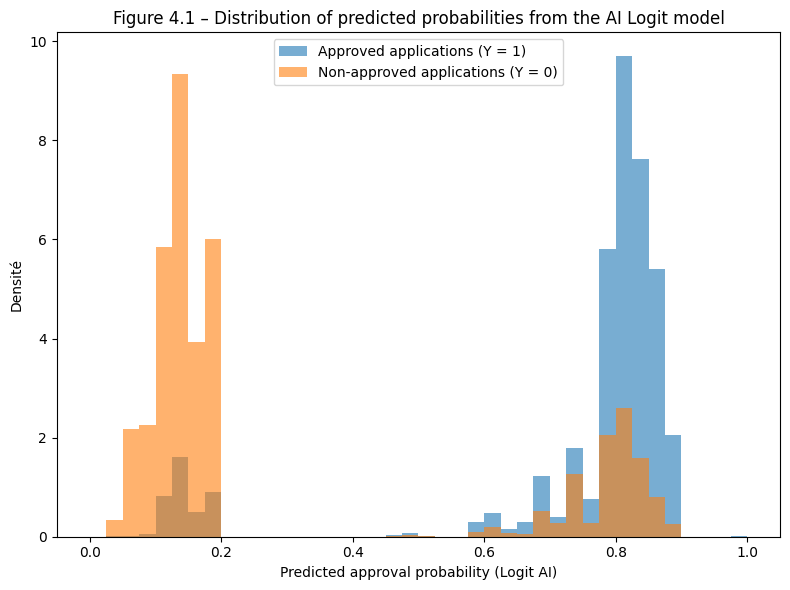

✅ Figure 4.1 saved in: C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures\fig_4_1_logit_ia_predicted_probs.png


In [3]:
if "y_test_ia" not in globals() or "y_proba_logit_ia" not in globals():
    raise RuntimeError("Exécute d'abord le Bloc 0 (préparation IA).")

plt.figure(figsize=(8, 6))

# Bins communs entre 0 et 1
bins = np.linspace(0, 1, 41)

plt.hist(
    y_proba_logit_ia[y_test_ia == 1],
    bins=bins,
    density=True,
    alpha=0.6,
    label="Approved applications (Y = 1)"
)
plt.hist(
    y_proba_logit_ia[y_test_ia == 0],
    bins=bins,
    density=True,
    alpha=0.6,
    label="Non-approved applications (Y = 0)"
)

plt.xlabel("Predicted approval probability (Logit AI)")
plt.ylabel("Densité")
plt.title("Figure 4.1 – Distribution of predicted probabilities from the AI Logit model")
plt.legend()
plt.tight_layout()

fig_4_1_path = os.path.join(FIG_DIR, "fig_4_1_logit_ia_predicted_probs.png")
plt.savefig(fig_4_1_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure 4.1 saved in:", fig_4_1_path)


In [ ]:
'''
\textbf{Figure 4.1 – Distribution des probabilités prédites par le logit IA (jeu de test).} 
Les dossiers approuvés (Y=1) présentent des probabilités fortement concentrées entre 0.75 et 0.90, tandis que les dossiers non approuvés (Y=0) se situent presque exclusivement entre 0.05 et 0.25. L’absence de recouvrement entre les deux distributions dans la zone intermédiaire reflète la bonne capacité discriminante du modèle (AUC = 0.858).
'''

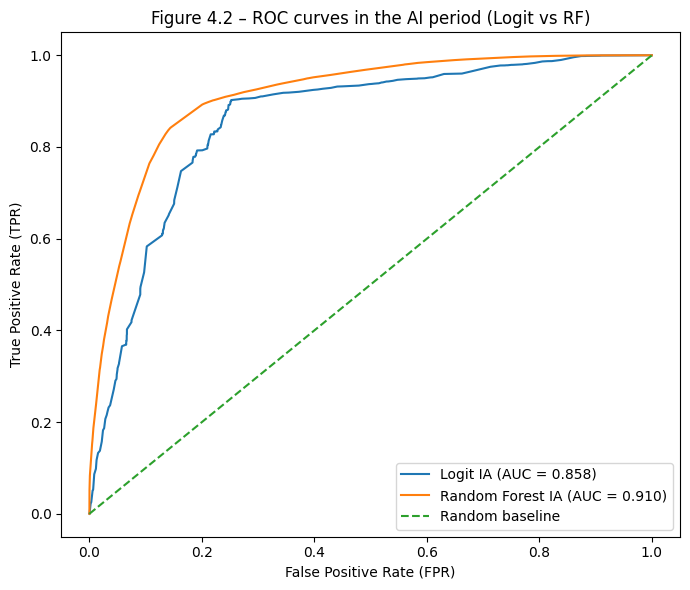

✅ Figure 4.2 saved in: C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures\fig_4_2_roc_ia_logit_vs_rf.png


In [4]:
# %% [code]
"""
Figure 4.2 – Courbes ROC en période IA (Logit vs Random Forest)
➡️ Nécessite le Bloc 0 (y_test_ia, y_proba_logit_ia, y_proba_rf_ia, auc_logit_ia, auc_rf_ia).
"""

from sklearn.metrics import roc_curve

for v in ["y_test_ia", "y_proba_logit_ia", "y_proba_rf_ia", "auc_logit_ia", "auc_rf_ia"]:
    if v not in globals():
        raise RuntimeError("Exécute d'abord le Bloc 0 (préparation IA).")

fpr_logit, tpr_logit, _ = roc_curve(y_test_ia, y_proba_logit_ia)
fpr_rf, tpr_rf, _ = roc_curve(y_test_ia, y_proba_rf_ia)

plt.figure(figsize=(7, 6))
plt.plot(fpr_logit, tpr_logit, label=f"Logit IA (AUC = {auc_logit_ia:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest IA (AUC = {auc_rf_ia:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random baseline")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Figure 4.2 – ROC curves in the AI period (Logit vs RF)")
plt.legend(loc="lower right")
plt.tight_layout()

fig_4_2_path = os.path.join(FIG_DIR, "fig_4_2_roc_ia_logit_vs_rf.png")
plt.savefig(fig_4_2_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure 4.2 saved in:", fig_4_2_path)


In [ ]:
'''
\textbf{Figure 4.2 – Courbes ROC en période IA (Logit vs Random Forest).}
Courbes ROC du modèle logit IA et du Random Forest IA sur le jeu de test, comparées à la ligne de classification aléatoire. Le Random Forest présente une aire sous la courbe plus élevée (AUC = 0{,}910) que le logit (AUC = 0{,}858), indiquant une meilleure capacité de discrimination entre dossiers approuvés et non approuvés.
'''

C:\Users\33669\AppData\Local\Temp\ipykernel_20508\1048918794.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_income.groupby("income_group")["approved"]


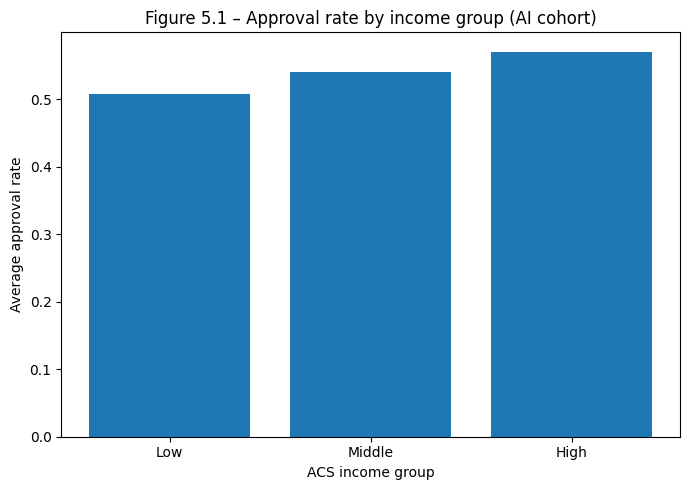

✅ Figure 5.1 saved in: C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures\fig_5_1_approval_by_income_group.png


In [5]:
# %% [code]
"""
Figure 5.1 – Taux d’approbation par groupe de revenu ACS (cohorte IA)
➡️ Nécessite le Bloc 0 (hmda_acs_ia avec income_group & approved).
"""

if "hmda_acs_ia" not in globals():
    raise RuntimeError("Exécute d'abord le Bloc 0 (préparation IA).")

if "income_group" not in hmda_acs_ia.columns:
    raise ValueError("La colonne 'income_group' est absente de hmda_acs_ia.")

df_income = hmda_acs_ia.dropna(subset=["income_group", "approved"]).copy()
df_income["approved"] = df_income["approved"].astype(int)

order_income = ["Low", "Middle", "High"]
group_rates = (
    df_income.groupby("income_group")["approved"]
    .mean()
    .reindex(order_income)
)

plt.figure(figsize=(7, 5))
plt.bar(group_rates.index, group_rates.values)
plt.ylabel("Average approval rate")
plt.xlabel("ACS income group")
plt.title("Figure 5.1 – Approval rate by income group (AI cohort)")
plt.tight_layout()

fig_5_1_path = os.path.join(FIG_DIR, "fig_5_1_approval_by_income_group.png")
plt.savefig(fig_5_1_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure 5.1 saved in:", fig_5_1_path)


In [ ]:
'''
\textbf{Figure 5.1 – Taux d’approbation par groupe de revenu (cohorte IA).}
Taux moyens d’approbation pour les groupes de revenu ACS \emph{Low}, \emph{Middle} et \emph{High} dans la cohorte IA. On observe une progression monotone du taux d’approbation à mesure que le revenu augmente, ce qui reflète l’importance du revenu comme déterminant de l’éligibilité au crédit.
'''

X_fair shape : (520486, 6) | y_fair shape : (520486,)
RF fairness IA entraîné sur la cohorte complète.

Fairness de base par race (aperçu) :
                        race       n   PP_rate       TPR       FNR       PPV     Brier
0         Race Not Available  115935  0.514970  0.781999  0.218001  0.616451  0.212108
1                      White  320041  0.598726  0.909880  0.090120  0.894889  0.086784
2  Black or African American   33768  0.482883  0.908187  0.091813  0.907519  0.068369
3                      Asian   39644  0.560665  0.881883  0.118117  0.909300  0.100741
4                      Joint    7939  0.627661  0.915309  0.084691  0.902268  0.091661


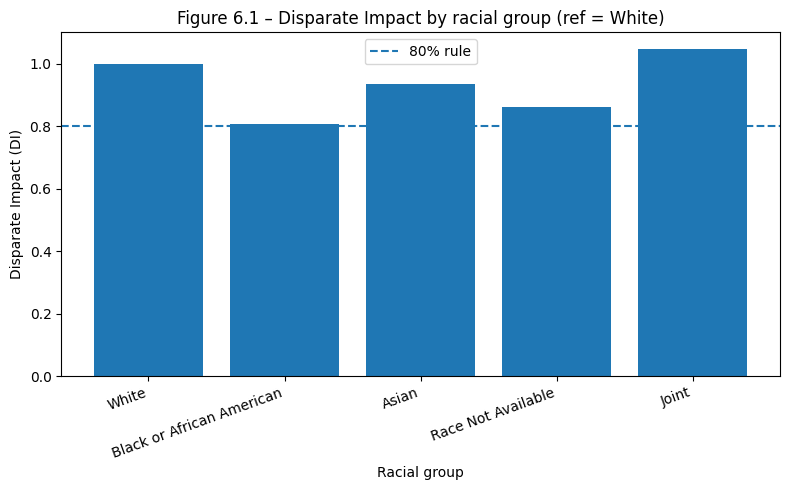

✅ Figure 6.1 saved in: C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures\fig_6_1_disparate_impact_by_race.png


In [6]:
# %% [code]
"""
Fairness Random Forest IA par race + Figure 6.1 (Disparate Impact)
➡️ Utilise hmda_acs_ia, entraîne un RF sur toute la cohorte IA.
"""

from sklearn.metrics import confusion_matrix, brier_score_loss

if "hmda_acs_ia" not in globals():
    raise RuntimeError("Exécute d'abord le Bloc 0 (préparation IA).")

if "derived_race" not in hmda_acs_ia.columns:
    raise ValueError("Colonne 'derived_race' absente – impossible de calculer la fairness par race.")

fair_ml_cols = ["loan_purpose", "loan_type", "hoepa_status", "state_code", "year", "approved"]
fair_ml_cols = [c for c in fair_ml_cols if c in hmda_acs_ia.columns]

fair_df = hmda_acs_ia[fair_ml_cols + ["derived_race"]].dropna(
    subset=["approved", "derived_race"]
).copy()
fair_df["approved"] = fair_df["approved"].astype(int)

X_fair = pd.get_dummies(
    fair_df.drop(columns=["approved", "derived_race"]),
    drop_first=True
)
y_fair = fair_df["approved"]
race_fair = fair_df["derived_race"]

print("X_fair shape :", X_fair.shape, "| y_fair shape :", y_fair.shape)

rf_fair = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_fair.fit(X_fair, y_fair)

y_pred_fair = rf_fair.predict(X_fair)
y_proba_fair = rf_fair.predict_proba(X_fair)[:, 1]

print("RF fairness IA entraîné sur la cohorte complète.")

def group_stats(y_true, y_pred, y_proba, mask, min_n=50):
    n = int(mask.sum())
    if n < min_n:
        return None

    y_g = y_true[mask]
    yhat_g = y_pred[mask]
    p_g = y_proba[mask]

    cm = confusion_matrix(y_g, yhat_g)
    if cm.shape != (2, 2):
        return None
    tn, fp, fn, tp = cm.ravel()

    total = tn + fp + fn + tp
    pp_rate = (tp + fp) / total if total > 0 else np.nan
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    fnr = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan

    try:
        brier = brier_score_loss(y_g, p_g)
    except Exception:
        brier = np.nan

    return {
        "n": n,
        "PP_rate": pp_rate,
        "TPR": tpr,
        "FNR": fnr,
        "PPV": ppv,
        "Brier": brier,
    }

group_rows = []
races = race_fair.dropna().unique()

for grp in races:
    mask = (race_fair == grp).values
    stats = group_stats(y_fair.values, y_pred_fair, y_proba_fair, mask)
    if stats is None:
        group_rows.append({
            "race": grp,
            "n": int(mask.sum()),
            "PP_rate": np.nan,
            "TPR": np.nan,
            "FNR": np.nan,
            "PPV": np.nan,
            "Brier": np.nan,
        })
    else:
        group_rows.append({
            "race": grp,
            "n": stats["n"],
            "PP_rate": stats["PP_rate"],
            "TPR": stats["TPR"],
            "FNR": stats["FNR"],
            "PPV": stats["PPV"],
            "Brier": stats["Brier"],
        })

fairness_race_df = pd.DataFrame(group_rows)
print("\nFairness de base par race (aperçu) :")
print(fairness_race_df.head())

# Calcul DI vs White
ref_grp = "White"
if ref_grp not in list(fairness_race_df["race"]):
    raise ValueError("Groupe de référence 'White' absent dans derived_race.")

ref_row = fairness_race_df[fairness_race_df["race"] == ref_grp].iloc[0]

def compute_di(row, ref_row):
    if pd.isna(row["PP_rate"]) or pd.isna(ref_row["PP_rate"]) or ref_row["PP_rate"] <= 0:
        return np.nan
    return row["PP_rate"] / ref_row["PP_rate"]

fairness_race_df["DI"] = fairness_race_df.apply(
    lambda r: compute_di(r, ref_row),
    axis=1
)

# Pour les figures, on se concentre sur les groupes majoritaires
major_groups_order = [
    "White",
    "Black or African American",
    "Asian",
    "Race Not Available",
    "Joint",
]

major_df = (
    fairness_race_df.set_index("race")
    .reindex(major_groups_order)
    .dropna(subset=["DI"])
    .reset_index()
)

# Figure 6.1 – DI par groupe racial
plt.figure(figsize=(8, 5))
plt.bar(major_df["race"], major_df["DI"])
plt.axhline(0.8, linestyle="--", label="80% rule")
plt.ylabel("Disparate Impact (DI)")
plt.xlabel("Racial group")
plt.title("Figure 6.1 – Disparate Impact by racial group (ref = White)")
plt.xticks(rotation=20, ha="right")
plt.legend()
plt.tight_layout()

fig_6_1_path = os.path.join(FIG_DIR, "fig_6_1_disparate_impact_by_race.png")
plt.savefig(fig_6_1_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure 6.1 saved in:", fig_6_1_path)


In [ ]:
'''
\textbf{Figure 6.1 – Disparate Impact par groupe racial (réf. = White).}
Disparate Impact (DI) du modèle Random Forest IA par groupe racial, calculé comme le ratio entre le taux d’approbation du groupe et celui des emprunteurs blancs. La ligne horizontale en pointillés représente la « règle des 80~\% » : un DI inférieur à 0{,}8 indique un désavantage marqué du groupe concerné en termes de probabilité d’approbation.
'''

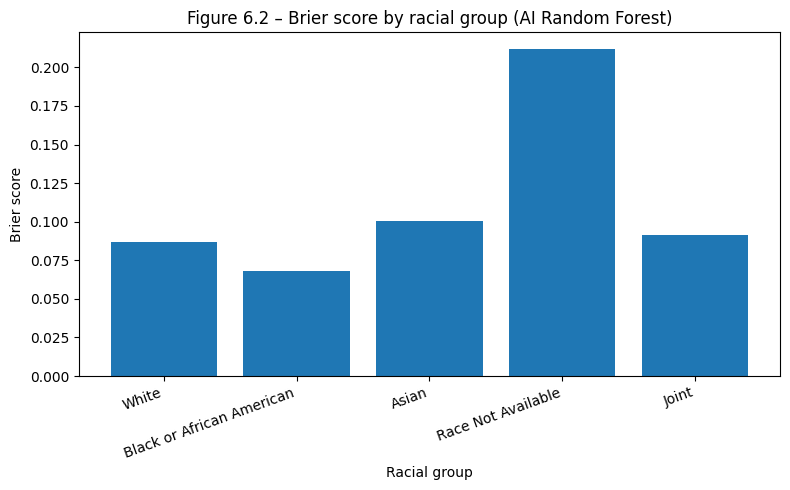

✅ Figure 6.2 saved in: C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures\fig_6_2_brier_by_race.png


In [26]:
# %% [code]
"""
Figure 6.2 – Score de Brier par groupe racial (Random Forest IA)
➡️ Nécessite le Bloc 4 (fairness_race_df + major_df).
"""

if "major_df" not in globals():
    raise RuntimeError("Exécute d'abord le Bloc 4 (fairness par race).")

plt.figure(figsize=(8, 5))
plt.bar(major_df["race"], major_df["Brier"])
plt.ylabel("Brier score")
plt.xlabel("Racial group")
plt.title("Figure 6.2 – Brier score by racial group (AI Random Forest)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()

fig_6_2_path = os.path.join(FIG_DIR, "fig_6_2_brier_by_race.png")
plt.savefig(fig_6_2_path, dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure 6.2 saved in:", fig_6_2_path)
